# Pytorch classifier notebook

V1 : only 1 split. First implementation  
All folds V1 : with all folds  
All folds V2 : add activation stats plot  
All folds V2.1 : back to  best MLP found so far, and backport fix of activation layers stats. Add weight decay and scheduler (fit one cycle) code

All folds autoencoder MLP V1  
All folds autoencoder MLP V2 : with weights and biases

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
#import torch.optim as optim
import torch_optimizer as optim  # Custom optimizers (not officially pytorch) : to use RAdam https://pypi.org/project/torch-optimizer/#radam
import torchvision.transforms as transforms
import torchvision.utils as utils

from torch.utils.tensorboard import SummaryWriter
import io
import PIL.Image

import datetime

import faiss

torch.set_printoptions(edgeitems=2)
torch.manual_seed(42)

DATASET_INPUT_FILE = 'train.csv'

#FEATURES_LIST_TOTRAIN = ['feature_'+str(i) for i in range(130)] + ['cross_41_42_43', 'cross_1_2']
FEATURES_LIST_TOTRAIN = ['feature_'+str(i) for i in range(130)]

# For custom non-overlaped folds generation
TRAIN_PERCENT = 0.70  
TEST_PERCENT = 0.30

# If subsplit of training set : percentage of second training set  
TRAIN1_PERCENT = 0.20  

ACT_N = False  # Add N previous predictions to input of MLP <= Does not work, logic is not right
ACT_N_SIZE = 5

CLUSTERING = False

pd.set_option('display.max_rows', 500)

In [2]:
# Deterministic Behavior
seed = 42
#os.environ['PYTHONHASHSEED'] = str(seed)
# Torch RNG
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
# Python RNG
np.random.seed(seed)
#random.seed(seed)
# CuDA Determinism
torch.backends.cudnn.deterministic = True
#torch.backends.cudnn.benchmark = False

In [3]:
DO_SWEEP = True
DO_SINGLE_TRAIN = False
#BATCH_SIZE = 50000
#BATCH_SIZE = 4096 # Gave once better results than 50000
#BATCH_SIZE = 2048

#BATCH_SIZE = 300000

#BATCH_SIZE = 4096
#BATCH_SIZE = 8192
#BATCH_SIZE = 32768
BATCH_SIZE = 195837
WEIGHT_DECAY = 0.00012 # Remettre à 1e-5
LEARNING_RATE = 0.0008602
DROPOUT = 0.4019
USE_AUTOENC = 'None'

EARLY_STOPPING = True

NUM_EPOCHS = 1000
#NUM_EPOCHS = 36

MODEL_FILE = f'model_NN_allfolds_V1.pt'

BATCH_SIZE_AE = 40960
NUM_EPOCHS_AE = 1000
LEARNING_RATE_AE = 1e-3
WEIGHT_DECAY_AE = 1e-4
MODEL_FILE_AE = f'model_NN_AE_allfolds_V1.pt'

RETRAIN_MODEl_AE = False

MODEL_COMMENT_AE = f'All folds MLP autoenc, 2 layers 64 32, good model reloaded, batch size {BATCH_SIZE_AE}, lr={LEARNING_RATE_AE}, patience 5, standard scale, weight decay {WEIGHT_DECAY_AE}, dropout 0.5, with cross features, no scheduler, no std scale'
MODEL_COMMENT = f'All folds MLP withOUT autoenc  5 layers 130, 200, 100, 75, 50 (instead of 130, 200 and 100) , good model reloaded, batch size {BATCH_SIZE}, lr={LEARNING_RATE}, patience 20, standard scale, weight decay {WEIGHT_DECAY}, 0.7 dropout, without cross features, no scheduler, no std scale'

In [4]:
'''
sweep_config = {
    'method': 'bayes', #grid, random, bayes
    'metric': {
      'name': 'Best utility',
      'goal': 'maximize'   
    },
    'parameters': {
        'batch_size': {
            'values': [524288, 262144, 131072, 65536, 32768, 16384, 8192, 4096, 2048, 1024, 512]
        },
        'dropout': {
            'values': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
        },
        'learning_rate': {
            #'values': [1e-2, 1e-3, 1e-4, 3e-4, 1e-5]
            #'values': [1e-2, 1e-3, 1e-4]
            'values': [1e-2, 1e-3]
        },

        'weight_decay': {
            'values': [1e-2, 1e-3, 1e-4, 1e-5]
        },
    
        'use_autoenc': {
            'values': ['encoder-decoder', 'encoder', 'encoder-only', 'None']
            #'values': ['encoder-decoder', 'None']
        },
        
        'activation_function': {
            'values': ['relu', 'leakyrelu']
        },
        
    }
}
'''

sweep_config = {
    'method': 'bayes', #grid, random, bayes
    'metric': {
      'name': 'Best utility',
      'goal': 'maximize'   
    },
    'parameters': {
        'batch_size': {
            'min': 4096,
            'max': 300000,
            
            
            #'min': 300000,
            #'max': 300001,
            'distribution': 'int_uniform',
        },
        'dropout': {
            'min': 0.3,
            'max': 0.5,
            'distribution': 'uniform',
        },
        'learning_rate': {
            'min': 0.0005,
            'max': 0.002,
            'distribution': 'uniform',
        },

        'weight_decay': {
            'min': 0.00001,
            'max': 0.0002,
            'distribution': 'uniform',

        },
    
        'use_autoenc': {
            #'values': ['encoder-only']
            #'values': ['encoder', 'encoder-only']
            #'values': ['encoder-decoder', 'None']
            'values': ['None']
        },
        
        'activation_function': {
            'values': ['leakyrelu']
        },

        'hidden_size': {
            'min': 128,
            'max': 512,
            #'max': 256,
            'distribution': 'int_uniform',
        },

        
        
    }
}

In [5]:
import wandb

wandb.login()

wandb: Currently logged in as: fboyer (use `wandb login --relogin` to force relogin)


True

In [6]:
def display_memory():
    torch.cuda.empty_cache()
    memory = torch.cuda.memory_allocated('cuda')
    print("{:.3f} GB".format(memory / 1024 ** 3))

In [7]:
def pyStandardScale(tensor, mean, std):
    return((tensor - mean) / std)

In [8]:
from sklearn.model_selection import KFold
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from sklearn.utils.validation import _deprecate_positional_args

# modified code for group gaps; source
# https://github.com/getgaurav2/scikit-learn/blob/d4a3af5cc9da3a76f0266932644b884c99724c57/sklearn/model_selection/_split.py#L2243
class PurgedGroupTimeSeriesSplit(_BaseKFold):
    """Time Series cross-validator variant with non-overlapping groups.
    Allows for a gap in groups to avoid potentially leaking info from
    train into test if the model has windowed or lag features.
    Provides train/test indices to split time series data samples
    that are observed at fixed time intervals according to a
    third-party provided group.
    In each split, test indices must be higher than before, and thus shuffling
    in cross validator is inappropriate.
    This cross-validation object is a variation of :class:`KFold`.
    In the kth split, it returns first k folds as train set and the
    (k+1)th fold as test set.
    The same group will not appear in two different folds (the number of
    distinct groups has to be at least equal to the number of folds).
    Note that unlike standard cross-validation methods, successive
    training sets are supersets of those that come before them.
    Read more in the :ref:`User Guide <cross_validation>`.
    Parameters
    ----------
    n_splits : int, default=5
        Number of splits. Must be at least 2.
    max_train_group_size : int, default=Inf
        Maximum group size for a single training set.
    group_gap : int, default=None
        Gap between train and test
    max_test_group_size : int, default=Inf
        We discard this number of groups from the end of each train split
    """

    @_deprecate_positional_args
    def __init__(self,
                 n_splits=5,
                 *,
                 max_train_group_size=np.inf,
                 max_test_group_size=np.inf,
                 group_gap=None,
                 verbose=False
                 ):
        super().__init__(n_splits, shuffle=False, random_state=None)
        self.max_train_group_size = max_train_group_size
        self.group_gap = group_gap
        self.max_test_group_size = max_test_group_size
        self.verbose = verbose

    def split(self, X, y=None, groups=None):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        groups : array-like of shape (n_samples,)
            Group labels for the samples used while splitting the dataset into
            train/test set.
        Yields
        ------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        if groups is None:
            raise ValueError(
                "The 'groups' parameter should not be None")
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        group_gap = self.group_gap
        max_test_group_size = self.max_test_group_size
        max_train_group_size = self.max_train_group_size
        n_folds = n_splits + 1
        group_dict = {}
        u, ind = np.unique(groups, return_index=True)
        unique_groups = u[np.argsort(ind)]
        n_samples = _num_samples(X)
        n_groups = _num_samples(unique_groups)
        for idx in np.arange(n_samples):
            if (groups[idx] in group_dict):
                group_dict[groups[idx]].append(idx)
            else:
                group_dict[groups[idx]] = [idx]
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds={0} greater than"
                 " the number of groups={1}").format(n_folds,
                                                     n_groups))

        group_test_size = min(n_groups // n_folds, max_test_group_size)
        group_test_starts = range(n_groups - n_splits * group_test_size,
                                  n_groups, group_test_size)
        for group_test_start in group_test_starts:
            train_array = []
            test_array = []

            group_st = max(0, group_test_start - group_gap - max_train_group_size)
            for train_group_idx in unique_groups[group_st:(group_test_start - group_gap)]:
                train_array_tmp = group_dict[train_group_idx]
                
                train_array = np.sort(np.unique(
                                      np.concatenate((train_array,
                                                      train_array_tmp)),
                                      axis=None), axis=None)

            train_end = train_array.size
 
            for test_group_idx in unique_groups[group_test_start:
                                                group_test_start +
                                                group_test_size]:
                test_array_tmp = group_dict[test_group_idx]
                test_array = np.sort(np.unique(
                                              np.concatenate((test_array,
                                                              test_array_tmp)),
                                     axis=None), axis=None)

            test_array  = test_array[group_gap:]
            
            
            if self.verbose > 0:
                    pass
                    
            yield [int(i) for i in train_array], [int(i) for i in test_array]

from matplotlib.colors import ListedColormap
    
# this is code slightly modified from the sklearn docs here:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py
def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""
    
    cmap_cv = plt.cm.coolwarm

    jet = plt.cm.get_cmap('jet', 256)
    seq = np.linspace(0, 1, 256)
    _ = np.random.shuffle(seq)   # inplace
    cmap_data = ListedColormap(jet(seq))

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)

    # Plot the data classes and groups at the end
    ax.scatter(range(len(X)), [ii + 1.5] * len(X),
               c=y, marker='_', lw=lw, cmap=plt.cm.Set3)

    ax.scatter(range(len(X)), [ii + 2.5] * len(X),
               c=group, marker='_', lw=lw, cmap=cmap_data)

    # Formatting
    yticklabels = list(range(n_splits)) + ['target', 'day']
    ax.set(yticks=np.arange(n_splits+2) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+2.2, -.2], xlim=[0, len(y)])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    return ax


def plot_cv_indices_custom(cv_custom, X, y, group, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""
    
    cmap_cv = plt.cm.coolwarm

    jet = plt.cm.get_cmap('jet', 256)
    seq = np.linspace(0, 1, 256)
    _ = np.random.shuffle(seq)   # inplace
    cmap_data = ListedColormap(jet(seq))

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv_custom):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)

    # Plot the data classes and groups at the end
    ax.scatter(range(len(X)), [ii + 1.5] * len(X),
               c=y, marker='_', lw=lw, cmap=plt.cm.Set3)

    ax.scatter(range(len(X)), [ii + 2.5] * len(X),
               c=group, marker='_', lw=lw, cmap=cmap_data)

    # Formatting
    yticklabels = list(range(n_splits)) + ['target', 'day']
    ax.set(yticks=np.arange(n_splits+2) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+2.2, -.2], xlim=[0, len(y)])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    return ax

In [9]:
# This function accounts for variable instance counts in each split by dividing utility_pi by number of instances (but this has been removed)
# It also does some copy of dataframe to prevent memory overwrite
def utility_function(df_test, df_test_predictions):
    df_test_copy = df_test.copy(deep=True)
    df_test_copy.loc[:, 'utility_pj'] = df_test_copy['weight'] * df_test_copy['resp'] * df_test_predictions
    #df_test_utility_pi = df_test_copy.groupby('date')['utility_pj'].sum() / df_test_copy.groupby('date')['utility_pj'].count()
    df_test_utility_pi = df_test_copy.groupby('date')['utility_pj'].sum()

    nb_unique_dates = df_test_utility_pi.shape[0]

    if (np.sqrt(df_test_utility_pi.pow(2).sum()) == 0):
        t = 0

    else:
        t = (df_test_utility_pi.sum() / np.sqrt(df_test_utility_pi.pow(2).sum())) * (np.sqrt(250 / np.abs(nb_unique_dates)))

    u = min(max(t, 0), 6) * df_test_utility_pi.sum()
    del df_test_copy
    
    return(u)

In [10]:
from bisect import bisect_left

# The aim of this function is to return closest date from an index
# So that split indices correspond to start or end of a new day
# myList contains list of instances that correspond to start of a new da

def take_closest(myList, myNumber):
    """
    Assumes myList is sorted. Returns closest value to myNumber.

    If two numbers are equally close, return the smallest number.
    """
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return myList[0]
    if pos == len(myList):
        return myList[-1]
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
       return after
    else:
       return before

In [11]:
class SaveOutputActivationStats:
    def __init__(self):
        self.outputs = []
        
    def __call__(self, module, module_in, module_out):
        #self.outputs.append(module_out)
        #print('Save output callback :')
        #print(module)
        #print({'mean': module_out.mean().item(), 'std': module_out.std().item(),'near_zero': (module_out<=0.05).long().sum().item()/module_out.numel()})
        self.outputs.append({'mean': module_out.mean().item(), 'std': module_out.std().item(),'near_zero': (module_out<=0.05).long().sum().item()/module_out.numel()})
        
    def clear(self):
        self.outputs = []

In [12]:
#fig, ax = plt.subplots(1, 1)
#
#plot_cv_indices(cv, df.loc[:, FEATURES_LIST_TOTRAIN], (df['resp'] > 0), df['date'], 
#                         ax, 5, lw=20);

In [13]:
torch.device

torch.device

In [14]:
torch.cuda.is_available()

True

In [15]:
torch.cuda.current_device()

0

In [16]:
torch.cuda.get_device_name(0)

'GeForce RTX 3090'

# Load data

In [17]:
# Load data
    
df = pd.read_csv(DATASET_INPUT_FILE)
df['resp_positive'] = ((df['resp'])>0)*1  # Target to predict

print('Data loaded')


Data loaded


# Feature engineering

In [18]:
#df['cross_41_42_43'] = df['feature_41'] + df['feature_42'] + df['feature_43']

In [19]:
#df['cross_1_2'] = df['feature_1'] / (df['feature_2'] + 1e-5)

# Non overlap fold generation

In [20]:
date_indexes_list = df.groupby('date')['ts_id'].first().to_list()

In [21]:
base_train_split_size = int((df.shape[0] // 5) * TRAIN_PERCENT)

In [22]:
base_test_split_size = int((df.shape[0] // 5) * TEST_PERCENT)

In [23]:
train_split_start_indexes = [take_closest(date_indexes_list, (base_train_split_size + base_test_split_size)*fold_indice) for fold_indice in range(5)]

In [24]:
#test_split_start_indexes = [take_closest(date_indexes_list, (base_train_split_size + base_test_split_size)*fold_indice) for fold_indice in range(5)]

In [25]:
train_split_start_indexes

[0, 477711, 958233, 1435933, 1913985]

In [26]:
df.shape[0] - 1

2390490

In [27]:
# We'll have 5 folds of 3 subsets each (2 training sets and 1 test set per fold)
# (1st training set of each fold will be used for 1st model, ie auto encoder)

NB_FOLDS = 5
last_index = df.shape[0] - 1

cv_table = []

for fold_indice in range(NB_FOLDS):
    fold_train_start_index = train_split_start_indexes[fold_indice]
    
    if (fold_indice == NB_FOLDS - 1):    
        nextfold_train_start_index = last_index
        
    else:
        nextfold_train_start_index = train_split_start_indexes[fold_indice + 1]
    
    fold_test_start_index = take_closest(date_indexes_list, int(TRAIN_PERCENT * (nextfold_train_start_index - fold_train_start_index) + fold_train_start_index  ))
    fold_train2_start_index = take_closest(date_indexes_list, int(TRAIN1_PERCENT * (fold_test_start_index - fold_train_start_index) + fold_train_start_index  ))
    
    cv_table.append(fold_train_start_index)
    cv_table.append(fold_train2_start_index)
    cv_table.append(fold_test_start_index)

In [28]:
cv_table.append(last_index)

In [29]:
cv_table

[0,
 66091,
 336609,
 477711,
 546983,
 815783,
 958233,
 1024471,
 1290282,
 1435933,
 1505171,
 1771833,
 1913985,
 1980610,
 2248510,
 2390490]

In [30]:
cv_table

[0,
 66091,
 336609,
 477711,
 546983,
 815783,
 958233,
 1024471,
 1290282,
 1435933,
 1505171,
 1771833,
 1913985,
 1980610,
 2248510,
 2390490]

In [31]:
NB_FOLDS

5

In [32]:
cv_tuples = []

for i in range(0, NB_FOLDS*3, 3):
    cv_tuples.append([df.loc[cv_table[i]:cv_table[i+1]-1, :].index.to_list(), df.loc[cv_table[i+1]:cv_table[i+2]-1, :].index.to_list(),
                      df.loc[cv_table[i+2]:cv_table[i+3]-1, :].index.to_list()])

In [33]:
len(cv_tuples[0][2])

141102

In [34]:
cv_tuples_generator = iter(cv_tuples)

In [35]:
#fig, ax = plt.subplots(1, 1)

#plot_cv_indices_custom(cv_tuples_generator, df.loc[:, FEATURES_LIST_TOTRAIN], (df['resp'] > 0), df['date'], 
#                         ax, 5, lw=20); 

#cv_tuples_generator = iter(cv_tuples)

In [36]:
# Size of training set :
#train_sets_table =  [cv_tuples[i][0] for i in range(5)]
#sum([len(train_set_table) for train_set_table in train_sets_table])

In [37]:
# Our old time series split (with overlap : required 1 neural network trained per split)
# But in this script it's not needed because we're training 1 unique network, with a different fold strategy (non overlaped)
#cv = PurgedGroupTimeSeriesSplit(
#    n_splits=5,
#    max_train_group_size=180,
#    group_gap=20,
#    max_test_group_size=60
#)

In [38]:
#train_index, test_index = next(cv.split(df, (df['resp'] > 0)*1, df['date']))

In [39]:
#(df.loc[train_index, 'resp'] > 0).astype(np.byte)

In [40]:
f_mean = df.loc[:, FEATURES_LIST_TOTRAIN].mean(axis=0)

In [41]:
f_mean.shape

(130,)

In [42]:
df.fillna(f_mean, inplace=True)

In [43]:
#print('Sum of model parameters:')
#[print(p.sum()) for p in model.parameters()]

In [44]:
#writer = SummaryWriter()

#writer.add_text('test', 'test:'  + str(model).replace('\n', '<BR>'))

#writer.flush()
#writer.close()

In [45]:
#str([p.numel() for p in model.parameters()])

In [46]:
folds_list = []

for fold, (train1_index, train2_index, test_index) in enumerate(cv_tuples_generator):
    folds_list.append((train1_index, train2_index, test_index))

In [47]:
folds_list_train1 = [folds_list[i][0] for i in range(5)]
folds_list_train1_flat = [folds_list_train1_item for sublist in folds_list_train1 for folds_list_train1_item in sublist]
folds_list_train1_unique = list(set(folds_list_train1_flat))

folds_list_train2 = [folds_list[i][1] for i in range(5)]
folds_list_train2_flat = [folds_list_train2_item for sublist in folds_list_train2 for folds_list_train2_item in sublist]
folds_list_train2_unique = list(set(folds_list_train2_flat))

In [48]:
len(folds_list_train1_unique)

337464

In [49]:
len(folds_list_train2_unique)

1339691

In [50]:
np.sum([len(folds_list_train1_item) for folds_list_train1_item in folds_list_train1])

337464

In [51]:
np.sum([len(folds_list_train2_item) for folds_list_train2_item in folds_list_train2])

1339691

In [52]:
len(folds_list_train1_flat)

337464

In [53]:
folds_list_test = [folds_list[i][2] for i in range(5)]
folds_list_test_flat = [folds_list_test_item for sublist in folds_list_test for folds_list_test_item in sublist]
folds_list_test_unique = set(folds_list_test_flat)

In [54]:
np.sum([len(folds_list_test_item) for folds_list_test_item in folds_list_test])

713335

In [55]:
len(folds_list_test_flat)

713335

In [56]:
len(folds_list_train1_flat) + len(folds_list_train2_flat) + len(folds_list_test_flat)

2390490

In [57]:
df.loc[folds_list_test[4], FEATURES_LIST_TOTRAIN].to_numpy().shape

(141980, 130)

In [58]:
df.loc[(folds_list_train1_unique + folds_list_train2_unique), FEATURES_LIST_TOTRAIN].to_numpy().mean(axis=0)

array([ 0.00880718,  0.39574469,  0.33059838,  0.00919269,  0.00341737,
       -0.00498373, -0.01455459,  0.05534631,  0.02511896,  0.2646538 ,
        0.16705702,  0.09489698,  0.04450428,  0.15251293,  0.07996651,
        0.22166532,  0.12827658,  0.12181565,  0.10958852,  0.29772963,
        0.26463247,  0.1881408 ,  0.17251055,  0.25474009,  0.23267903,
        0.29794049,  0.2685417 ,  0.13985131,  0.16285107,  0.33060734,
        0.34385913,  0.22684687,  0.25190658,  0.31637359,  0.3359838 ,
        0.35284181,  0.36773315,  0.02650339,  0.0186391 ,  0.04320553,
        0.05298663,  0.45417433,  0.37762691,  0.41617323,  0.43927675,
        0.48651095,  0.49207956,  0.36839975,  0.50144387,  0.54379067,
        0.53074971,  0.45673965,  0.05646874,  0.38900233,  0.37690587,
        0.77549302,  0.92466193,  0.78590429,  0.80847667,  0.89895923,
        0.55335406,  0.55554392,  0.55922873,  0.56139559,  0.44231975,
        0.61884351,  0.61715568,  0.59770334,  0.59814018,  0.37

In [59]:
len(list(set(folds_list_train1_unique + folds_list_train2_unique)))

1677155

In [60]:
torch.mean(torch.tensor(df.loc[(folds_list_train1_unique + folds_list_train2_unique), FEATURES_LIST_TOTRAIN].to_numpy(), device='cpu'), axis=0)

tensor([ 0.0088,  0.3957,  0.3306,  0.0092,  0.0034, -0.0050, -0.0146,  0.0553,
         0.0251,  0.2647,  0.1671,  0.0949,  0.0445,  0.1525,  0.0800,  0.2217,
         0.1283,  0.1218,  0.1096,  0.2977,  0.2646,  0.1881,  0.1725,  0.2547,
         0.2327,  0.2979,  0.2685,  0.1399,  0.1629,  0.3306,  0.3439,  0.2268,
         0.2519,  0.3164,  0.3360,  0.3528,  0.3677,  0.0265,  0.0186,  0.0432,
         0.0530,  0.4542,  0.3776,  0.4162,  0.4393,  0.4865,  0.4921,  0.3684,
         0.5014,  0.5438,  0.5307,  0.4567,  0.0565,  0.3890,  0.3769,  0.7755,
         0.9247,  0.7859,  0.8085,  0.8990,  0.5534,  0.5555,  0.5592,  0.5614,
         0.4423,  0.6188,  0.6172,  0.5977,  0.5981,  0.3774,  0.2389,  0.3080,
         0.0041, -0.0322, -0.0016, -0.0199, -0.0316, -0.0932, -0.0081, -0.0358,
        -0.0025, -0.0149, -0.0350, -0.1015,  0.3934,  0.5416,  0.3924,  0.4281,
         0.4976,  0.3994,  0.4332,  0.5235,  0.4224,  0.4221,  0.4348,  0.4547,
         0.3984,  0.5422,  0.3973,  0.42

In [61]:
torch.tensor(f_mean)

tensor([ 9.8386e-03,  3.8558e-01,  3.5769e-01,  8.9192e-03,  4.1501e-03,
        -3.7146e-03, -1.2589e-02,  5.1777e-02,  2.6828e-02,  2.4881e-01,
         1.8235e-01,  8.9122e-02,  4.9486e-02,  1.4311e-01,  8.9027e-02,
         2.1168e-01,  1.4630e-01,  1.2122e-01,  1.1358e-01,  2.9381e-01,
         2.6877e-01,  1.8691e-01,  1.7698e-01,  2.5244e-01,  2.3856e-01,
         2.9407e-01,  2.7318e-01,  1.3548e-01,  1.6088e-01,  3.2189e-01,
         3.4253e-01,  2.2056e-01,  2.5013e-01,  3.0822e-01,  3.3535e-01,
         3.4145e-01,  3.6583e-01,  2.9320e-02,  2.2892e-02,  4.0022e-02,
         5.0750e-02,  4.4505e-01,  3.6018e-01,  3.4603e-01,  4.1153e-01,
         4.3803e-01,  4.7612e-01,  3.4787e-01,  4.9963e-01,  5.6400e-01,
         5.1226e-01,  4.5739e-01,  4.5744e-02,  3.6270e-01,  3.5887e-01,
         6.5260e-01,  8.0495e-01,  6.6135e-01,  6.7981e-01,  7.6259e-01,
         5.5640e-01,  5.5817e-01,  5.4554e-01,  5.4678e-01,  4.3506e-01,
         6.0757e-01,  6.0850e-01,  5.9519e-01,  5.9

# Training KMeans clusterer

In [62]:
class FaissKMeans:
    def __init__(self, n_clusters=8, n_init=10, max_iter=300):
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.kmeans = None
        self.cluster_centers_ = None
        self.inertia_ = None

    def fit(self, X):
        self.kmeans = faiss.Kmeans(d=X.shape[1],
                                   k=self.n_clusters,
                                   niter=self.max_iter,
                                   nredo=self.n_init)
        self.kmeans.train(X.astype(np.float32))
        self.cluster_centers_ = self.kmeans.centroids
        self.inertia_ = self.kmeans.obj[-1]

    def predict(self, X):
        return self.kmeans.index.search(X.astype(np.float32), 1)[1]



In [64]:
df_forclustering = df.loc[folds_list_train1_unique, FEATURES_LIST_TOTRAIN].astype({'feature_0': np.float32})

In [64]:
df_forclustering = np.copy(df_forclustering[FEATURES_LIST_TOTRAIN].to_numpy(), order='C')

In [65]:
NB_CLUSTERS = 5

clusterer = FaissKMeans(n_clusters=NB_CLUSTERS, n_init=10, max_iter=3000)
clusterer.fit(df_forclustering)

In [66]:
df_full = df.loc[:, FEATURES_LIST_TOTRAIN].astype({'feature_0': np.float32})
df_full = np.copy(df_full[FEATURES_LIST_TOTRAIN].to_numpy(), order='C')

In [67]:
y_clusters = clusterer.predict(df_full)

In [68]:
df['cluster'] = y_clusters + 1  # +1 to avoid cluster indice 0 (less practical for gradients)

In [69]:
if (CLUSTERING == True):
    FEATURES_LIST_TOTRAIN = FEATURES_LIST_TOTRAIN + ['cluster']

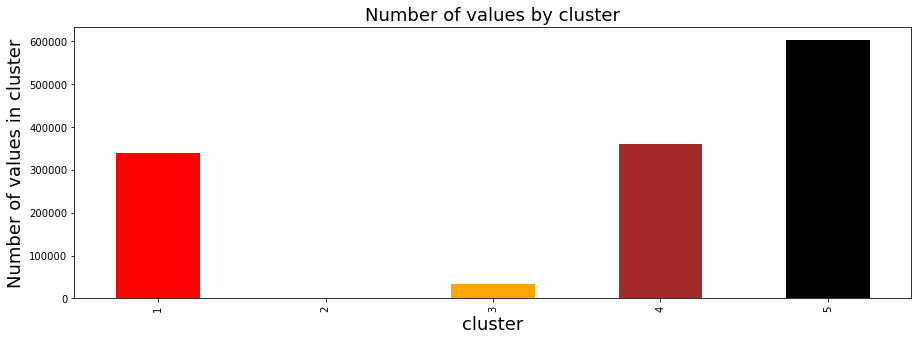

In [70]:
colors = ['red', 'blue', 'orange', 'brown', 'black']

fig, ax = plt.subplots(figsize=(15, 5))
#ax = axes.ravel()
#fig.tight_layout(pad=10.0)

ax.set_xlabel('Cluster', fontsize=18)
ax.set_ylabel('Number of values in cluster', fontsize=18)
ax.set_title('Number of values by cluster', fontsize=18)

df.loc[folds_list_train2_unique, :].groupby(by='cluster')['resp'].count().plot.bar(figsize=(15,5), ax=ax, color=colors);

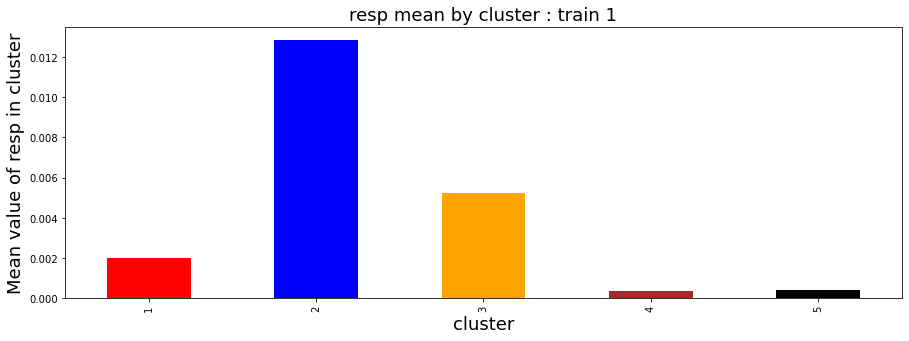

In [71]:
fig, ax = plt.subplots(figsize=(15, 5))
#ax = axes.ravel()
#fig.tight_layout(pad=10.0)

ax.set_xlabel('Cluster', fontsize=18)
ax.set_ylabel('Mean value of resp in cluster', fontsize=18)
ax.set_title('resp mean by cluster : train 1', fontsize=18)

df.loc[folds_list_train1_unique, :].groupby(by='cluster')['resp'].mean().plot.bar(figsize=(15,5), ax=ax, color=colors);

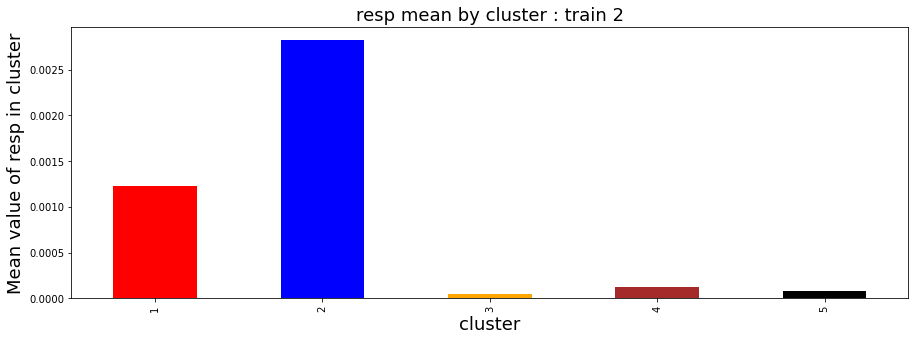

In [72]:
fig, ax = plt.subplots(figsize=(15, 5))
#ax = axes.ravel()
#fig.tight_layout(pad=10.0)

ax.set_xlabel('Cluster', fontsize=18)
ax.set_ylabel('Mean value of resp in cluster', fontsize=18)
ax.set_title('resp mean by cluster : train 2', fontsize=18)

df.loc[folds_list_train2_unique, :].groupby(by='cluster')['resp'].mean().plot.bar(figsize=(15,5), ax=ax, color=colors);

# Training auto encoder

In [62]:
torch.manual_seed(seed)  

ENCODER_SIZE = 32
    
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder,self).__init__()
        
        self.encoder = nn.Sequential(
            #nn.Dropout(0.5),  # Noise layer
            nn.Linear(len(FEATURES_LIST_TOTRAIN), 64),
            nn.ReLU(),
            nn.Linear(64, ENCODER_SIZE),
            nn.ReLU(),
        )
        
        self.decoder = nn.Sequential(             
            nn.Linear(ENCODER_SIZE, 64),
            nn.ReLU(),
            nn.Linear(64, len(FEATURES_LIST_TOTRAIN)),
        )
        
    def forward(self,x):
        if self.training:
            x = x + 0.1 * torch.randn(x.shape[0], x.shape[1]).double(). to('cuda')  # 0.1 = noise variance
            
        x = self.encoder(x)
        x = self.decoder(x)
        return x        

model = AutoEncoder().double().to('cuda')
    
#print('Number of model parameters :')
#numel_list = [p.numel() for p in model.parameters()]
#sum(numel_list), numel_list
    
if (RETRAIN_MODEl_AE == False):
    model_AE = model
    model_AE.load_state_dict(torch.load(MODEL_FILE_AE,map_location=torch.device('cuda')))
    print('Model AE loaded')

else:    
    print('Training started')
    patience=5

    utility_scores = [None] * 5
    accuracy_scores = [None] * 5

    today = datetime.datetime.now()
    now_str = today.strftime("%b%d_%H-%M-%S")
    tensorboard_dir_AE = 'runs_AE/' + now_str
    writer = SummaryWriter(log_dir=tensorboard_dir_AE)

    ts_train = torch.tensor(df.loc[folds_list_train1_unique, FEATURES_LIST_TOTRAIN].to_numpy(), device='cuda')
    #ts_train_y = torch.tensor((df.loc[folds_list_train_unique, 'resp'] > 0).astype(np.byte).to_numpy(), device='cuda')

    # Normalize data
    ts_train_mean = torch.mean(ts_train, axis=0)
    ts_train_std = torch.std(ts_train, axis=0)
    #ts_train_mean = torch.tensor(f_mean)
    # If you want to use Standard scale : calculate mean from f_mean and std scale from whole dataset
    #ts_train = pyStandardScale(ts_train, ts_train_mean, ts_train_std)

    train_dataset = torch.utils.data.TensorDataset(ts_train)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE_AE, shuffle=True)

    ts_test = [None] * 5
    #ts_test_y = [None] * 5    
    test_dataset = [None] * 5
    test_loader = [None] * 5

    for fold_indice in range(5):
        ts_test[fold_indice] = torch.tensor(df.loc[folds_list_test[fold_indice], FEATURES_LIST_TOTRAIN].to_numpy(), device='cuda')
        #ts_test_y[fold_indice] = torch.tensor((df.loc[folds_list_test[fold_indice], 'resp'] > 0).astype(np.byte).to_numpy(), device='cuda')

        # Normalize
        #ts_test[fold_indice] = pyStandardScale(ts_test[fold_indice], ts_train_mean, ts_train_std)

        test_dataset[fold_indice] = torch.utils.data.TensorDataset(ts_test[fold_indice])
        test_loader[fold_indice] = torch.utils.data.DataLoader(test_dataset[fold_indice], batch_size=BATCH_SIZE_AE)

    loss_fn = nn.MSELoss().to('cuda')
    #optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) 
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE_AE, weight_decay=WEIGHT_DECAY_AE) 

    scheduler = None
    #scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e3,
    #                                                         max_lr=1e-4, epochs=NUM_EPOCHS, steps_per_epoch=len(train_loader))

    #model.eval()
    #start_accuracy = accuracy_score(ts_test_y.cpu().numpy(), (model(ts_test).squeeze() > 0.5).cpu().numpy())
    #start_utility_score = utility_function(df.loc[test_index], (model(ts_test).squeeze() > 0.5).cpu().numpy())
    #print('Start Validation Accuracy: {:.4f}'.format(start_accuracy))
    #print('Start Validation Utility: {:.4f}'.format(start_utility_score))

    Val_Loss = 0
    N_Samples = 0

    the_last_loss = 10000
    the_last_utility_score = 0
    the_last_accuracy = 0
    trigger_times=0
    early_stopping_met = False

    for epoch in range(NUM_EPOCHS_AE): 
        running_loss = 0.0        

        ### Call back to save activation stats (mean, std dev and near 0 values after activation functions)
        # Setting hook for activation layers stats

        hook_handles = []
        save_output_activation_stats = []

        for layer in model.modules():
            if ('activation' in str(type(layer))):
                save_output_activation_stats_1layer = SaveOutputActivationStats()
                handle = layer.register_forward_hook(save_output_activation_stats_1layer)
                save_output_activation_stats.append(save_output_activation_stats_1layer)
                hook_handles.append(handle)    

        model.train()

        for batch in train_loader:
            #inputs, labels = batch[0], batch[1]
            inputs = batch[0].to('cuda')
            optimizer.zero_grad()

            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                loss = loss_fn(outputs, inputs.double())
                loss.backward()
                optimizer.step()

                if scheduler:
                    scheduler.step()

        # update local train loss
            running_loss += loss.item() * inputs.size(0)

        # update global train loss
        epoch_loss = running_loss / len(train_loader.dataset)
        print('Epoch({}) - Training Loss: {:.4f}'.format(epoch, epoch_loss))

        writer.add_scalar(f"Global train/loss", epoch_loss, epoch)

        # Write activation stats graphs
        for layer_number,save_output_activation_stats_layer in enumerate(save_output_activation_stats):
            df_stats_layer = pd.DataFrame(save_output_activation_stats_layer.outputs)

            fig, ax = plt.subplots(1, 3, figsize=(25, 4))

            ax[0].set_title(f'Layer {layer_number} : Mean activation value', fontsize=16)
            ax[0].set_xlabel('Batch instances')
            ax[0].set_ylabel('Mean')
            ax[0].plot(range(df_stats_layer.shape[0]), df_stats_layer['mean'])

            ax[1].set_title(f'Layer {layer_number} : Std deviation activation value', fontsize=16)
            ax[1].set_xlabel('Batch instances')
            ax[1].set_ylabel('Standard deviation')
            ax[1].plot(range(df_stats_layer.shape[0]), df_stats_layer['std'])

            ax[2].set_title(f'Layer {layer_number} : Percentage of activation values near zero', fontsize=16)
            ax[2].set_xlabel('Batch instances')
            ax[2].set_ylabel('Percentage')
            ax[2].plot(range(df_stats_layer.shape[0]), df_stats_layer['near_zero']);

            plot_buf = io.BytesIO()
            plt.savefig(plot_buf, format='jpeg')
            plt.close()

            plot_buf.seek(0)
            image = PIL.Image.open(plot_buf)
            image = transforms.ToTensor()(image)
            writer.add_image("Train activation stats/Activation stats layer " + str(layer_number), image, epoch)

        # Validation 
        model.eval()

        vrunning_loss = [None] * 5
        num_samples = [None] * 5
        vepoch_loss_folds = [None] * 5
        vepoch_accuracy_folds = [None] * 5
        vepoch_utility_score_folds = [None] * 5

        for fold_indice in range(5):    
            vrunning_loss[fold_indice] = 0.0
            num_samples[fold_indice] = 0

            for batch in test_loader[fold_indice]:
                inputs = batch[0].to('cuda')

                optimizer.zero_grad()
                with torch.no_grad():
                    outputs = model(inputs)
                    loss = loss_fn(outputs, inputs.double())

                vrunning_loss[fold_indice] += loss.item() * inputs.size(0)
                num_samples[fold_indice] += inputs.size(0)

                vepoch_loss_folds[fold_indice] = vrunning_loss[fold_indice] / num_samples[fold_indice]

            print('Epoch({}) - Fold {} - Validation Loss : {:.4f}'.format(epoch, fold_indice, vepoch_loss_folds[fold_indice]))        

        # update epoch loss
        vepoch_loss = sum(vepoch_loss_folds) / len(vepoch_loss_folds)
        print('Epoch({}) - GLOBAL - Validation Loss: {:.4f}'.format(epoch, vepoch_loss))

        #print(f'Sum of model parameters ({epoch}):')
        #[print(p.sum()) for p in model.parameters()]

        writer.add_scalar("Global valid/Loss", vepoch_loss, epoch)

        for fold_indice in range(5):
            writer.add_scalar("Fold valid Loss/Loss fold "+str(fold_indice), vepoch_loss_folds[fold_indice], epoch)        

        writer.flush()

        # Check if Early Stopping

        if (vepoch_loss > the_last_loss):
            if (EARLY_STOPPING == True):
                trigger_times += 1

                print(f'Intermediate early stopping : vepoch_loss = {vepoch_loss:.4f}, the_last_loss={the_last_loss:.4f}')

                if trigger_times >= patience:
                    print('Meet Early stopping!')
                    early_stopping_met = True
                    ##torch.save(model.state_dict(), f'model_{fold}.pt')
                    break
        else:
            trigger_times = 0
            the_last_loss = vepoch_loss

            the_best_epoch = epoch

            # Save model for the best version so far
            print(f'Saving model corresponding to last_loss == {the_last_loss}')
            torch.save(model.state_dict(), MODEL_FILE_AE)

        print('\n')

    if (early_stopping_met == False):
        print("Didn't meet early stopping : saving final model")
        # Save model if don't meet early stopping
        torch.save(model.state_dict(), MODEL_FILE_AE)

    writer.add_text(f"Global valid/Loss", f"Best loss: {the_last_loss}", the_best_epoch)

    scores_results = {'Loss': the_last_loss, 'Loss folds': vepoch_loss_folds, 'Loss_std': np.std(vepoch_loss_folds)}

    writer.add_text('Final score', str(scores_results))
    writer.add_text('Batch size', str(BATCH_SIZE_AE))
    writer.add_text('Patience', str(patience))
    writer.add_text('Number of epochs', str(NUM_EPOCHS_AE))
    writer.add_text('Best epoch', str(the_best_epoch))
    writer.add_text('Number of parameters per layer', str([p.numel() for p in model.parameters()]))
    writer.add_text('Model architecture', str(model).replace('\n', '<BR>'))
    writer.add_text('Comment', MODEL_COMMENT_AE)

    writer.close()

    print('Training summary:')
    print(scores_results)

    model_AE = model
    model_AE.eval()
    print('Training ended')

Model AE loaded


With noise 0.01 and clustering :  
{'Loss': 0.3849842190821132, 'Loss folds': [0.4477343427193263, 0.36315438263176464, 0.3901575283001523, 0.4046033569269988, 0.31993053528058724], 'Loss_std': 0.0425621624935266}  

With noise 0.1 without clustering :
{'Loss': 0.4013562969953418, 'Loss folds': [0.4683083206738427, 0.38134665501868015, 0.4085802369265447, 0.4217434697302297, 0.3315976695350142], 'Loss_std': 0.04519391402025046}

In [63]:
df[FEATURES_LIST_TOTRAIN].mean().mean()

0.3105054402961592

In [65]:
1.08 / df[FEATURES_LIST_TOTRAIN].mean().mean()

3.4781999277368514

In [64]:
#ts_train.mean(axis=0)

In [65]:
#loss_fn(ts_train[0:5, :], model_AE(ts_train[0:5, :]))

In [66]:
#model_AE(ts_train[0:5, :])[0, 5]

In [67]:
#ts_train[0, 5]

In [68]:
#loss_fn(ts_train[50, 5], model_AE(ts_train[:, :])[50, 5])

# Training main model

In [75]:

config_MLP = dict(
    epochs=NUM_EPOCHS,
    batch_size=300000,
    learning_rate=LEARNING_RATE,
    weight_decay = WEIGHT_DECAY,
    dropout = DROPOUT,
    use_autoenc = USE_AUTOENC,
    activation_function = 'leakyrelu',
    hidden_size = 262,
    )


print('Training started')
patience=20

print('Run config :')
print("config:", dict(config_MLP))

utility_scores = [None] * 5
accuracy_scores = [None] * 5

writer = SummaryWriter()

ts_train = torch.tensor(df.loc[folds_list_train2_unique, FEATURES_LIST_TOTRAIN].to_numpy(), device='cuda')
ts_train_y = torch.tensor((df.loc[folds_list_train2_unique, 'resp'] > 0).astype(np.byte).to_numpy(), device='cuda')

# Normalize data
ts_train_mean = torch.mean(ts_train, axis=0)
ts_train_std = torch.std(ts_train, axis=0)
#ts_train = pyStandardScale(ts_train, ts_train_mean, ts_train_std)

train_dataset = torch.utils.data.TensorDataset(ts_train, ts_train_y)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config_MLP['batch_size'], shuffle=True) # pin_memory : VOIR RESULTAT

ts_test = [None] * 5
ts_test_y = [None] * 5    
test_dataset = [None] * 5
test_loader = [None] * 5

for fold_indice in range(5):
    ts_test[fold_indice] = torch.tensor(df.loc[folds_list_test[fold_indice], FEATURES_LIST_TOTRAIN].to_numpy(), device='cuda')
    ts_test_y[fold_indice] = torch.tensor((df.loc[folds_list_test[fold_indice], 'resp'] > 0).astype(np.byte).to_numpy(), device='cuda')

    # Normalize
    #ts_test[fold_indice] = pyStandardScale(ts_test[fold_indice], ts_train_mean, ts_train_std)

    test_dataset[fold_indice] = torch.utils.data.TensorDataset(ts_test[fold_indice], ts_test_y[fold_indice])
    test_loader[fold_indice] = torch.utils.data.DataLoader(test_dataset[fold_indice], batch_size=config_MLP['batch_size'])

torch.manual_seed(seed)


class Model_Resnet(nn.Module):
    def __init__(self):
        super(Model_Resnet, self).__init__()
        self.batch_norm0 = nn.BatchNorm1d(len(FEATURES_LIST_TOTRAIN))
        self.dropout0 = nn.Dropout(0.2)

        dropout_rate = config_MLP['dropout']
        hidden_size = config_MLP['hidden_size']
        self.dense1 = nn.Linear(len(FEATURES_LIST_TOTRAIN), hidden_size)
        self.batch_norm1 = nn.BatchNorm1d(hidden_size)
        self.dropout1 = nn.Dropout(dropout_rate)

        self.cat1 = lambda a,b : torch.cat([a, b], 1)

        self.dense2 = nn.Linear(hidden_size+len(FEATURES_LIST_TOTRAIN), hidden_size)
        self.batch_norm2 = nn.BatchNorm1d(hidden_size)
        self.dropout2 = nn.Dropout(dropout_rate)

        self.cat2 = lambda a,b : torch.cat([a, b], 1)

        self.dense3 = nn.Linear(hidden_size+hidden_size, hidden_size)
        self.batch_norm3 = nn.BatchNorm1d(hidden_size)
        self.dropout3 = nn.Dropout(dropout_rate)

        self.cat3 = lambda a,b : torch.cat([a, b], 1)            

        self.dense4 = nn.Linear(hidden_size+hidden_size, hidden_size)
        self.batch_norm4 = nn.BatchNorm1d(hidden_size)
        self.dropout4 = nn.Dropout(dropout_rate)

        self.cat4 = lambda a,b : torch.cat([a, b], 1)            

        self.dense5 = nn.Linear(hidden_size+hidden_size, 1)
        self.act5 = nn.Sigmoid()

        self.LeakyReLU1 = nn.LeakyReLU(negative_slope=0.01)
        self.LeakyReLU2 = nn.LeakyReLU(negative_slope=0.01)
        self.LeakyReLU3 = nn.LeakyReLU(negative_slope=0.01)
        self.LeakyReLU4 = nn.LeakyReLU(negative_slope=0.01)

    def forward(self, x):
        x = self.dropout0(self.batch_norm0(x))

        x1 = self.dropout1(self.LeakyReLU1(self.batch_norm1(self.dense1(x))))
        x = self.cat1(x, x1)

        x2 = self.dropout2(self.LeakyReLU2(self.batch_norm2(self.dense2(x))))
        x = self.cat2(x1, x2)

        x3 = self.dropout3(self.LeakyReLU3(self.batch_norm3(self.dense3(x))))
        x = self.cat3(x2, x3)

        x4 = self.dropout4(self.LeakyReLU4(self.batch_norm4(self.dense4(x))))

        x = self.cat4(x3, x4)

        x = self.act5(self.dense5(x))

        return x        

#model = MLP(model_AE).double().to('cuda')

#for param in model.AEncoder.parameters():
    #param.requires_grad = False

model = Model_Resnet().double().to('cuda')

'''
model = nn.Sequential(
        #nn.Dropout(0.2),
        nn.Linear(len(FEATURES_LIST_TOTRAIN), 200),
        #nn.BatchNorm1d(130),
        nn.ReLU(),
        nn.Dropout(0.7),

        nn.Linear(200, 100),
        #nn.BatchNorm1d(130),
        nn.ReLU(),
        nn.Dropout(0.7),

        nn.Linear(100, 1),
        nn.Sigmoid(),
    ).double().to('cuda')
'''

#print('Number of model parameters :')
#numel_list = [p.numel() for p in model.parameters()]
#sum(numel_list), numel_list

loss_fn = nn.BCELoss().to('cuda')

#optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) 
#optimizer = torch.optim.Adam(model.parameters(), lr=config_MLP.learning_rate, weight_decay=config_MLP.weight_decay) 

# According to this, Adam can sometimes update parameters even if they are frozen with requires_grad : 
# https://discuss.pytorch.org/t/why-is-it-when-i-call-require-grad-false-on-all-my-params-my-weights-in-the-network-would-still-update/22126/14
# So we exclude frozen parameters when calling the optimizer, with a filter
optimizer = optim.RAdam(filter(lambda p: p.requires_grad, model.parameters()), lr=config_MLP['learning_rate'], weight_decay=config_MLP['weight_decay']) 

scheduler = None
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e3,
#                                                         max_lr=1e-4, epochs=config_MLP.epochs, steps_per_epoch=len(train_loader))

#if (DO_SWEEP == False):
####wandb.watch(model, loss_fn, log="all", log_freq=1)

model.eval()
#start_accuracy = accuracy_score(ts_test_y.cpu().numpy(), (model(ts_test).squeeze() > 0.5).cpu().numpy())
#start_utility_score = utility_function(df.loc[test_index], (model(ts_test).squeeze() > 0.5).cpu().numpy())
#print('Start Validation Accuracy: {:.4f}'.format(start_accuracy))
#print('Start Validation Utility: {:.4f}'.format(start_utility_score))


Val_Loss = 0
N_Samples = 0

the_last_loss = 100
the_last_utility_score = 0
the_last_accuracy = 0
trigger_times=0
early_stopping_met = False

for epoch in range(config_MLP['epochs']): 
    running_loss = 0.0        

    ### Call back to save activation stats (mean, std dev and near 0 values after activation functions)
    # Setting hook for activation layers stats

    hook_handles = []
    save_output_activation_stats = []

    for layer in model.modules():
        if ('activation' in str(type(layer))):
            save_output_activation_stats_1layer = SaveOutputActivationStats()
            handle = layer.register_forward_hook(save_output_activation_stats_1layer)
            save_output_activation_stats.append(save_output_activation_stats_1layer)
            hook_handles.append(handle)    

    model.train()

    for batch in train_loader:
        #inputs, labels = batch[0], batch[1]
        inputs, labels = batch[0].to('cuda'), batch[1].to('cuda')

        optimizer.zero_grad()

        # with torch.set_grad_enabled(True):  # A enlever ? (réactive les gradients de l'auto encoder ?)
        # Ce with couvrait jusqu'à scheduler.step()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels.unsqueeze(-1).double())

        #loss.backward(retain_graph=True)
        loss.backward()
        optimizer.step()


        if scheduler:
            scheduler.step()

    # update local train loss
        running_loss += loss.item() * inputs.size(0)

    # update global train loss
    epoch_loss = running_loss / len(train_loader.dataset)
    print('Epoch({}) - Training Loss: {:.4f}'.format(epoch, epoch_loss))

    writer.add_scalar(f"Global train/loss", epoch_loss, epoch)
    #####wandb.log({'Global train/loss' : epoch_loss}, step=epoch)

    # Write activation stats graphs
    for layer_number,save_output_activation_stats_layer in enumerate(save_output_activation_stats):
        df_stats_layer = pd.DataFrame(save_output_activation_stats_layer.outputs)

        if ((df_stats_layer.shape[0] == 0) and (df_stats_layer.shape[1] == 0)):
            print(f'Activation stats: No data returned for stats at layer {layer_number}')

        else:
            fig, ax = plt.subplots(1, 3, figsize=(25, 4))

            ax[0].set_title(f'Layer {layer_number} : Mean activation value', fontsize=16)
            ax[0].set_xlabel('Batch instances')
            ax[0].set_ylabel('Mean')
            ax[0].plot(range(df_stats_layer.shape[0]), df_stats_layer['mean'])

            ax[1].set_title(f'Layer {layer_number} : Std deviation activation value', fontsize=16)
            ax[1].set_xlabel('Batch instances')
            ax[1].set_ylabel('Standard deviation')
            ax[1].plot(range(df_stats_layer.shape[0]), df_stats_layer['std'])

            ax[2].set_title(f'Layer {layer_number} : Percentage of activation values near zero', fontsize=16)
            ax[2].set_xlabel('Batch instances')
            ax[2].set_ylabel('Percentage')
            ax[2].plot(range(df_stats_layer.shape[0]), df_stats_layer['near_zero']);

            plot_buf = io.BytesIO()
            plt.savefig(plot_buf, format='jpeg')
            plt.close()

            plot_buf.seek(0)
            image = PIL.Image.open(plot_buf)
            image = transforms.ToTensor()(image)
            writer.add_image("Train activation stats/Activation stats layer " + str(layer_number), image, epoch)
            ####wandb.log({'Train activation stats/Activation stats layer' + str(layer_number) : wandb.Image(image)}, step=epoch)

    # Validation 
    model.eval()

    vrunning_loss = [None] * 5
    num_samples = [None] * 5
    vepoch_loss_folds = [None] * 5
    vepoch_accuracy_folds = [None] * 5
    vepoch_utility_score_folds = [None] * 5

    for fold_indice in range(5):    
        #print('Loop fold indice')
        vrunning_loss[fold_indice] = 0.0
        num_samples[fold_indice] = 0

        for batch in test_loader[fold_indice]:
            inputs, labels = batch[0].to('cuda'), batch[1].to('cuda')

            optimizer.zero_grad()
            with torch.no_grad():
                #display_memory()
                outputs = model(inputs)
                #display_memory()
                loss = loss_fn(outputs, labels.unsqueeze(-1).double())

            vrunning_loss[fold_indice] += loss.item() * inputs.size(0)
            num_samples[fold_indice] += labels.size(0)

            vepoch_loss_folds[fold_indice] = vrunning_loss[fold_indice] / num_samples[fold_indice]

        print('Epoch({}) - Fold {} - Validation Loss : {:.4f}'.format(epoch, fold_indice, vepoch_loss_folds[fold_indice]))

        model.eval()
        with torch.no_grad():
            vepoch_accuracy_folds[fold_indice] = accuracy_score(ts_test_y[fold_indice].cpu().numpy(), (model(ts_test[fold_indice]).squeeze() > 0.5).cpu().numpy())
            vepoch_utility_score_folds[fold_indice] = utility_function(df.loc[folds_list_test[fold_indice]], (model(ts_test[fold_indice]).squeeze() > 0.5).cpu().numpy())
        print('Epoch({}) - Fold {} - Validation Accuracy : {:.4f}'.format(epoch, fold_indice, vepoch_accuracy_folds[fold_indice]))
        print('Epoch({}) - Fold {} - Validation Utility score : {:.4f}'.format(epoch, fold_indice, vepoch_utility_score_folds[fold_indice]))


    # update epoch loss
    vepoch_loss = sum(vepoch_loss_folds) / len(vepoch_loss_folds)
    vepoch_accuracy = sum(vepoch_accuracy_folds) / len(vepoch_accuracy_folds)
    vepoch_utility_score = sum(vepoch_utility_score_folds) #/ len(vepoch_utility_score_folds)
    print('Epoch({}) - GLOBAL - Validation Loss: {:.4f}'.format(epoch, vepoch_loss))
    print('Epoch({}) - GLOBAL - Validation Accuracy: {:.4f}'.format(epoch, vepoch_accuracy))
    print('Epoch({}) - GLOBAL - Validation Utility score: {:.4f}'.format(epoch, vepoch_utility_score))

    #print(f'Sum of model parameters ({epoch}):')
    #[print(p.sum()) for p in model.parameters()]

    writer.add_scalar("Global valid/Loss", vepoch_loss, epoch)
    writer.add_scalar("Global valid/Accuracy", vepoch_accuracy, epoch)
    writer.add_scalar("Global valid/Utility", vepoch_utility_score, epoch)


    for fold_indice in range(5):
        writer.add_scalar("Fold valid Loss/Loss fold "+str(fold_indice), vepoch_loss_folds[fold_indice], epoch)
        writer.add_scalar("Fold valid Accuracy/Accuracy fold "+str(fold_indice), vepoch_accuracy_folds[fold_indice], epoch)
        writer.add_scalar("Fold valid Utility/Utility fold "+str(fold_indice), vepoch_utility_score_folds[fold_indice], epoch)



    writer.flush()

    # Check if Early Stopping
    #if vepoch_loss > the_last_loss:
    #if (vepoch_utility_score < the_last_utility_score) and (vepoch_loss > the_last_loss) and (vepoch_accuracy < the_last_accuracy):

    if (vepoch_loss > the_last_loss):
        if (EARLY_STOPPING == True):
            trigger_times += 1

            print(f'Intermediate early stopping : vepoch_loss = {vepoch_loss:.4f}, the_last_loss={the_last_loss:.4f}')
            #print(f'Intermediate early stopping : vepoch_accuracy = {vepoch_accuracy:.4f}, the_last_utility_score={the_last_accuracy:.4f}')
            #print(f'Intermediate early stopping : vepoch_utility_score = {vepoch_utility_score:.4f}, the_last_utility_score={the_last_utility_score:.4f}')

            if trigger_times >= patience:
                print('Meet Early stopping!')
                early_stopping_met = True
                ##torch.save(model.state_dict(), f'model_{fold}.pt')
                break
    else:
        trigger_times = 0
        the_last_loss = vepoch_loss
        the_last_utility_score = vepoch_utility_score
        the_last_accuracy = vepoch_accuracy

        the_last_utility_score_folds = vepoch_utility_score_folds
        the_last_accuracy_folds = vepoch_accuracy_folds

        the_best_epoch = epoch

        # Save model for the best version so far
        print(f'Saving model corresponding to last_utility_score == {the_last_utility_score}')
        torch.save(model.state_dict(), MODEL_FILE + '.test')
        #wandb.save(MODE_FILE)
        #torch.onnx.export(model, batch, MODEL_FILE_ONNX)
        #wandb.save(MODEL_FILE_ONNX)


    print('\n')

if (early_stopping_met == False):
    print("Didn't meet early stopping : saving final model")
    # Save model if don't meet early stopping
    torch.save(model.state_dict(), MODEL_FILE + '.test')
    ###wandb.save(MODE_FILE)
    #torch.onnx.export(model, test_loader[0], MODEL_FILE_ONNX)
    #wandb.save(MODEL_FILE_ONNX)


#utility_scores.append(the_last_utility_score)
#accuracy_scores.append(the_last_accuracy)
writer.add_text(f"Global valid/Utility", f"Best utility: {the_last_utility_score}", the_best_epoch)

scores_results = {'utility_score': the_last_utility_score, 'utility_scores': the_last_utility_score_folds, 'utility_score_std': np.std(the_last_utility_score_folds), 'accuracy_scores': the_last_accuracy_folds}

writer.add_text('Final utility score', str(scores_results))
writer.add_text('Batch size', str(config_MLP['batch_size']))
writer.add_text('Patience', str(patience))
writer.add_text('Number of epochs', str(NUM_EPOCHS))
writer.add_text('Best epoch', str(the_best_epoch))
writer.add_text('Number of parameters per layer', str([p.numel() for p in model.parameters()]))
writer.add_text('Model architecture', str(model).replace('\n', '<BR>'))
writer.add_text('Comment', MODEL_COMMENT)


writer.close()
#run.finish()

print('Training summary:')
print(scores_results)

Training started
Run config :
config: {'epochs': 1000, 'batch_size': 300000, 'learning_rate': 0.0008602, 'weight_decay': 0.00012, 'dropout': 0.4019, 'use_autoenc': 'None', 'activation_function': 'leakyrelu', 'hidden_size': 262}
Epoch(0) - Training Loss: 0.7209
Epoch(0) - Fold 0 - Validation Loss : 0.6951
Epoch(0) - Fold 0 - Validation Accuracy : 0.4960
Epoch(0) - Fold 0 - Validation Utility score : -0.0000
Epoch(0) - Fold 1 - Validation Loss : 0.6949
Epoch(0) - Fold 1 - Validation Accuracy : 0.4944
Epoch(0) - Fold 1 - Validation Utility score : -0.0000
Epoch(0) - Fold 2 - Validation Loss : 0.6946
Epoch(0) - Fold 2 - Validation Accuracy : 0.4946
Epoch(0) - Fold 2 - Validation Utility score : -0.0000
Epoch(0) - Fold 3 - Validation Loss : 0.6949
Epoch(0) - Fold 3 - Validation Accuracy : 0.4931
Epoch(0) - Fold 3 - Validation Utility score : -0.0000
Epoch(0) - Fold 4 - Validation Loss : 0.6945
Epoch(0) - Fold 4 - Validation Accuracy : 0.4997
Epoch(0) - Fold 4 - Validation Utility score : 25

KeyboardInterrupt: 

In [64]:
if (DO_SWEEP == True):
    sweep_id = wandb.sweep(sweep_config, entity='fboyer', project="janestreet-mlp")

Create sweep with ID: njv5udn4
Sweep URL: https://wandb.ai/fboyer/janestreet-mlp/sweeps/njv5udn4


In [65]:
def train():
    config_MLP = dict(
        epochs=NUM_EPOCHS,
        batch_size=BATCH_SIZE,
        learning_rate=LEARNING_RATE,
        weight_decay = WEIGHT_DECAY,
        dropout = DROPOUT,
        use_autoenc = USE_AUTOENC,
        activation_function = 'leakyrelu',
        hidden_size = 256,
        )

    if (DO_SWEEP == True):
        #run = wandb.init()
        #config_MLP = run.config
        wandb.init(config=config_MLP) # this config_MLP is ignored when sweep
        config_MLP = wandb.config

    else:
        wandb.init(project='janestreet-mlp', config=config_MLP)
        config_MLP = wandb.config

    print('Training started')
    patience=20

    print('Run config :')
    print("config:", dict(config_MLP))

    utility_scores = [None] * 5
    accuracy_scores = [None] * 5

    writer = SummaryWriter()

    ts_train = torch.tensor(df.loc[folds_list_train2_unique, FEATURES_LIST_TOTRAIN].to_numpy(), device='cuda')
    ts_train_y = torch.tensor((df.loc[folds_list_train2_unique, 'resp'] > 0).astype(np.byte).to_numpy(), device='cuda')

    # Normalize data
    ts_train_mean = torch.mean(ts_train, axis=0)
    ts_train_std = torch.std(ts_train, axis=0)
    #ts_train = pyStandardScale(ts_train, ts_train_mean, ts_train_std)

    train_dataset = torch.utils.data.TensorDataset(ts_train, ts_train_y)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config_MLP.batch_size, shuffle=True) # pin_memory : VOIR RESULTAT

    ts_test = [None] * 5
    ts_test_y = [None] * 5    
    test_dataset = [None] * 5
    test_loader = [None] * 5

    for fold_indice in range(5):
        ts_test[fold_indice] = torch.tensor(df.loc[folds_list_test[fold_indice], FEATURES_LIST_TOTRAIN].to_numpy(), device='cuda')
        ts_test_y[fold_indice] = torch.tensor((df.loc[folds_list_test[fold_indice], 'resp'] > 0).astype(np.byte).to_numpy(), device='cuda')

        # Normalize
        #ts_test[fold_indice] = pyStandardScale(ts_test[fold_indice], ts_train_mean, ts_train_std)

        test_dataset[fold_indice] = torch.utils.data.TensorDataset(ts_test[fold_indice], ts_test_y[fold_indice])
        test_loader[fold_indice] = torch.utils.data.DataLoader(test_dataset[fold_indice], batch_size=config_MLP.batch_size)

    torch.manual_seed(seed)

    class MLP(nn.Module):
        def __init__(self, AEncoder):
        #def __init__(self):
            super(MLP,self).__init__()

            #self.act_n = torch.zeros((config_MLP.batch_size, ACT_N_SIZE))
            if (ACT_N == True):
                self.act_n = torch.zeros(ACT_N_SIZE, device='cuda').unsqueeze(0)
                act_n_size = ACT_N_SIZE

            else:
                act_n_size = 0
                
            self.AEncoder = AEncoder

            if (config_MLP.use_autoenc == 'encoder-decoder'):
                #self.layer1 = nn.Linear(len(FEATURES_LIST_TOTRAIN) + self.AEncoder.decoder[0].in_features, 200)
                self.layer1 = nn.Linear(len(FEATURES_LIST_TOTRAIN) * 2 + act_n_size, 200) # <= % near 0 élevé

            elif (config_MLP.use_autoenc == 'encoder'):
                self.layer1 = nn.Linear(len(FEATURES_LIST_TOTRAIN) + ENCODER_SIZE + act_n_size, 200) # <= % near 0 élevé

            elif (config_MLP.use_autoenc == 'encoder-only'):
                self.layer1 = nn.Linear(ENCODER_SIZE + act_n_size, 200) # <= % near 0 élevé
                
            else:
                self.layer1 = nn.Linear(len(FEATURES_LIST_TOTRAIN) + act_n_size, 200) # <= % near 0 élevé

            if (config_MLP.activation_function == 'relu'):
                self.act1 = nn.ReLU()
                
            elif (config_MLP.activation_function == 'leakyrelu'):
                self.act1 = nn.LeakyReLU()
                
            self.dropout1 = nn.Dropout(config_MLP.dropout)

            self.layer2 = nn.Linear(200, 100)

            if (config_MLP.activation_function == 'relu'):
                self.act2 = nn.ReLU()
                
            elif (config_MLP.activation_function == 'leakyrelu'):
                self.act2 = nn.LeakyReLU()

            self.dropout2 = nn.Dropout(config_MLP.dropout)

            self.layer3 = nn.Linear(100, 75)

            if (config_MLP.activation_function == 'relu'):
                self.act3 = nn.ReLU()
                
            elif (config_MLP.activation_function == 'leakyrelu'):
                self.act3 = nn.LeakyReLU()

            self.dropout3 = nn.Dropout(config_MLP.dropout)
            
            self.layer4 = nn.Linear(75, 50)

            if (config_MLP.activation_function == 'relu'):
                self.act4 = nn.ReLU()
                
            elif (config_MLP.activation_function == 'leakyrelu'):
                self.act4 = nn.LeakyReLU()

            self.dropout4 = nn.Dropout(config_MLP.dropout)

            self.layer5 = nn.Linear(50, 1)
            self.act5 = nn.Sigmoid()

        def encoder(self, x):
            self.AEncoder.eval()

            encoded = self.AEncoder.encoder(x)

            return encoded

        def encoder_decoder(self, x):
            self.AEncoder.eval()

            encoded_decoded = self.AEncoder(x)

            return encoded_decoded

        def forward(self,x):
            #x_encoded = self.encoder(x)

            #x = torch.cat((x, x_encoded), dim=1)
            if (config_MLP.use_autoenc == 'encoder-decoder'):
                x_decoded = self.encoder_decoder(x)
                x = torch.cat((x, x_decoded), dim=1)

            elif (config_MLP.use_autoenc == 'encoder'):
                x_decoded = self.encoder(x)
                x = torch.cat((x, x_decoded), dim=1)

            elif (config_MLP.use_autoenc == 'encoder-only'):
                x_decoded = self.encoder(x)
                x = x_decoded
                
            else:
                pass

            if (ACT_N == True):
                x = torch.cat((x, self.act_n.expand(x.shape[0], ACT_N_SIZE)), dim=1)    

            x = self.dropout1(self.act1(self.layer1(x)))
            x = self.dropout2(self.act2(self.layer2(x)))
            
            x = self.dropout3(self.act3(self.layer3(x)))
            x = self.dropout4(self.act4(self.layer4(x)))

            x = self.act5(self.layer5(x))            

            # Remove oldest previously saved output (located at the end of tensor => index -1 for not selecting it) of NN and replace by new one (which is x, that we assign at start of tensor)
            # expand() because self.act_n when first assigned has only 1 line, but here it expands to number of lines in x (batch size)
            if (ACT_N == True):
                self.act_n = torch.cat((x, self.act_n[:, :-1].expand(x.shape[0], ACT_N_SIZE-1)), dim=1)


            #print('self.act_n:')
            #print(self.act_n)

            return x        

    class Model_Resnet(nn.Module):
        def __init__(self):
            super(Model_Resnet, self).__init__()
            self.batch_norm0 = nn.BatchNorm1d(len(FEATURES_LIST_TOTRAIN))
            self.dropout0 = nn.Dropout(0.2)

            dropout_rate = config_MLP.dropout
            hidden_size = config_MLP.hidden_size
            self.dense1 = nn.Linear(len(FEATURES_LIST_TOTRAIN), hidden_size)
            self.batch_norm1 = nn.BatchNorm1d(hidden_size)
            self.dropout1 = nn.Dropout(dropout_rate)
            
            self.cat1 = lambda a,b : torch.cat([a, b], 1)

            self.dense2 = nn.Linear(hidden_size+len(FEATURES_LIST_TOTRAIN), hidden_size)
            self.batch_norm2 = nn.BatchNorm1d(hidden_size)
            self.dropout2 = nn.Dropout(dropout_rate)

            self.cat2 = lambda a,b : torch.cat([a, b], 1)
            
            self.dense3 = nn.Linear(hidden_size+hidden_size, hidden_size)
            self.batch_norm3 = nn.BatchNorm1d(hidden_size)
            self.dropout3 = nn.Dropout(dropout_rate)

            self.cat3 = lambda a,b : torch.cat([a, b], 1)            
            
            self.dense4 = nn.Linear(hidden_size+hidden_size, hidden_size)
            self.batch_norm4 = nn.BatchNorm1d(hidden_size)
            self.dropout4 = nn.Dropout(dropout_rate)

            self.cat4 = lambda a,b : torch.cat([a, b], 1)            
            
            self.dense5 = nn.Linear(hidden_size+hidden_size, 1)
            self.act5 = nn.Sigmoid()

            self.LeakyReLU1 = nn.LeakyReLU(negative_slope=0.01)
            self.LeakyReLU2 = nn.LeakyReLU(negative_slope=0.01)
            self.LeakyReLU3 = nn.LeakyReLU(negative_slope=0.01)
            self.LeakyReLU4 = nn.LeakyReLU(negative_slope=0.01)

        def forward(self, x):
            x = self.dropout0(self.batch_norm0(x))

            x1 = self.dropout1(self.LeakyReLU1(self.batch_norm1(self.dense1(x))))
            x = self.cat1(x, x1)

            x2 = self.dropout2(self.LeakyReLU2(self.batch_norm2(self.dense2(x))))
            x = self.cat2(x1, x2)

            x3 = self.dropout3(self.LeakyReLU3(self.batch_norm3(self.dense3(x))))
            x = self.cat3(x2, x3)

            x4 = self.dropout4(self.LeakyReLU4(self.batch_norm4(self.dense4(x))))

            x = self.cat4(x3, x4)

            x = self.act5(self.dense5(x))

            return x        
    
    #model = MLP(model_AE).double().to('cuda')
    
    #for param in model.AEncoder.parameters():
        #param.requires_grad = False

    model = Model_Resnet().double().to('cuda')
        
    '''
    model = nn.Sequential(
            #nn.Dropout(0.2),
            nn.Linear(len(FEATURES_LIST_TOTRAIN), 200),
            #nn.BatchNorm1d(130),
            nn.ReLU(),
            nn.Dropout(0.7),

            nn.Linear(200, 100),
            #nn.BatchNorm1d(130),
            nn.ReLU(),
            nn.Dropout(0.7),

            nn.Linear(100, 1),
            nn.Sigmoid(),
        ).double().to('cuda')
    '''

    #print('Number of model parameters :')
    #numel_list = [p.numel() for p in model.parameters()]
    #sum(numel_list), numel_list

    loss_fn = nn.BCELoss().to('cuda')

    #optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) 
    #optimizer = torch.optim.Adam(model.parameters(), lr=config_MLP.learning_rate, weight_decay=config_MLP.weight_decay) 
    
    # According to this, Adam can sometimes update parameters even if they are frozen with requires_grad : 
    # https://discuss.pytorch.org/t/why-is-it-when-i-call-require-grad-false-on-all-my-params-my-weights-in-the-network-would-still-update/22126/14
    # So we exclude frozen parameters when calling the optimizer, with a filter
    optimizer = optim.RAdam(filter(lambda p: p.requires_grad, model.parameters()), lr=config_MLP.learning_rate, weight_decay=config_MLP.weight_decay) 

    scheduler = None
    #scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e3,
    #                                                         max_lr=1e-4, epochs=config_MLP.epochs, steps_per_epoch=len(train_loader))

    #if (DO_SWEEP == False):
    wandb.watch(model, loss_fn, log="all", log_freq=1)

    model.eval()
    #start_accuracy = accuracy_score(ts_test_y.cpu().numpy(), (model(ts_test).squeeze() > 0.5).cpu().numpy())
    #start_utility_score = utility_function(df.loc[test_index], (model(ts_test).squeeze() > 0.5).cpu().numpy())
    #print('Start Validation Accuracy: {:.4f}'.format(start_accuracy))
    #print('Start Validation Utility: {:.4f}'.format(start_utility_score))


    Val_Loss = 0
    N_Samples = 0

    the_last_loss = 100
    the_last_utility_score = 0
    the_last_accuracy = 0
    trigger_times=0
    early_stopping_met = False

    for epoch in range(config_MLP.epochs): 
        running_loss = 0.0        

        ### Call back to save activation stats (mean, std dev and near 0 values after activation functions)
        # Setting hook for activation layers stats

        hook_handles = []
        save_output_activation_stats = []

        for layer in model.modules():
            if ('activation' in str(type(layer))):
                save_output_activation_stats_1layer = SaveOutputActivationStats()
                handle = layer.register_forward_hook(save_output_activation_stats_1layer)
                save_output_activation_stats.append(save_output_activation_stats_1layer)
                hook_handles.append(handle)    

        model.train()

        for batch in train_loader:
            #inputs, labels = batch[0], batch[1]
            inputs, labels = batch[0].to('cuda'), batch[1].to('cuda')

            optimizer.zero_grad()

            # with torch.set_grad_enabled(True):  # A enlever ? (réactive les gradients de l'auto encoder ?)
            # Ce with couvrait jusqu'à scheduler.step()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels.unsqueeze(-1).double())

            #loss.backward(retain_graph=True)
            loss.backward()
            optimizer.step()


            if scheduler:
                scheduler.step()

        # update local train loss
            running_loss += loss.item() * inputs.size(0)

        # update global train loss
        epoch_loss = running_loss / len(train_loader.dataset)
        print('Epoch({}) - Training Loss: {:.4f}'.format(epoch, epoch_loss))

        writer.add_scalar(f"Global train/loss", epoch_loss, epoch)
        wandb.log({'Global train/loss' : epoch_loss}, step=epoch)

        # Write activation stats graphs
        for layer_number,save_output_activation_stats_layer in enumerate(save_output_activation_stats):
            df_stats_layer = pd.DataFrame(save_output_activation_stats_layer.outputs)

            if ((df_stats_layer.shape[0] == 0) and (df_stats_layer.shape[1] == 0)):
                print(f'Activation stats: No data returned for stats at layer {layer_number}')

            else:
                fig, ax = plt.subplots(1, 3, figsize=(25, 4))

                ax[0].set_title(f'Layer {layer_number} : Mean activation value', fontsize=16)
                ax[0].set_xlabel('Batch instances')
                ax[0].set_ylabel('Mean')
                ax[0].plot(range(df_stats_layer.shape[0]), df_stats_layer['mean'])

                ax[1].set_title(f'Layer {layer_number} : Std deviation activation value', fontsize=16)
                ax[1].set_xlabel('Batch instances')
                ax[1].set_ylabel('Standard deviation')
                ax[1].plot(range(df_stats_layer.shape[0]), df_stats_layer['std'])

                ax[2].set_title(f'Layer {layer_number} : Percentage of activation values near zero', fontsize=16)
                ax[2].set_xlabel('Batch instances')
                ax[2].set_ylabel('Percentage')
                ax[2].plot(range(df_stats_layer.shape[0]), df_stats_layer['near_zero']);

                plot_buf = io.BytesIO()
                plt.savefig(plot_buf, format='jpeg')
                plt.close()

                plot_buf.seek(0)
                image = PIL.Image.open(plot_buf)
                image = transforms.ToTensor()(image)
                writer.add_image("Train activation stats/Activation stats layer " + str(layer_number), image, epoch)
                wandb.log({'Train activation stats/Activation stats layer' + str(layer_number) : wandb.Image(image)}, step=epoch)
                
        # Validation 
        model.eval()

        vrunning_loss = [None] * 5
        num_samples = [None] * 5
        vepoch_loss_folds = [None] * 5
        vepoch_accuracy_folds = [None] * 5
        vepoch_utility_score_folds = [None] * 5

        for fold_indice in range(5):    
            #print('Loop fold indice')
            vrunning_loss[fold_indice] = 0.0
            num_samples[fold_indice] = 0

            for batch in test_loader[fold_indice]:
                inputs, labels = batch[0].to('cuda'), batch[1].to('cuda')

                optimizer.zero_grad()
                with torch.no_grad():
                    #display_memory()
                    outputs = model(inputs)
                    #display_memory()
                    loss = loss_fn(outputs, labels.unsqueeze(-1).double())

                vrunning_loss[fold_indice] += loss.item() * inputs.size(0)
                num_samples[fold_indice] += labels.size(0)

                vepoch_loss_folds[fold_indice] = vrunning_loss[fold_indice] / num_samples[fold_indice]

            print('Epoch({}) - Fold {} - Validation Loss : {:.4f}'.format(epoch, fold_indice, vepoch_loss_folds[fold_indice]))

            model.eval()
            with torch.no_grad():
                vepoch_accuracy_folds[fold_indice] = accuracy_score(ts_test_y[fold_indice].cpu().numpy(), (model(ts_test[fold_indice]).squeeze() > 0.5).cpu().numpy())
                vepoch_utility_score_folds[fold_indice] = utility_function(df.loc[folds_list_test[fold_indice]], (model(ts_test[fold_indice]).squeeze() > 0.5).cpu().numpy())
            print('Epoch({}) - Fold {} - Validation Accuracy : {:.4f}'.format(epoch, fold_indice, vepoch_accuracy_folds[fold_indice]))
            print('Epoch({}) - Fold {} - Validation Utility score : {:.4f}'.format(epoch, fold_indice, vepoch_utility_score_folds[fold_indice]))


        # update epoch loss
        vepoch_loss = sum(vepoch_loss_folds) / len(vepoch_loss_folds)
        vepoch_accuracy = sum(vepoch_accuracy_folds) / len(vepoch_accuracy_folds)
        vepoch_utility_score = sum(vepoch_utility_score_folds) #/ len(vepoch_utility_score_folds)
        print('Epoch({}) - GLOBAL - Validation Loss: {:.4f}'.format(epoch, vepoch_loss))
        print('Epoch({}) - GLOBAL - Validation Accuracy: {:.4f}'.format(epoch, vepoch_accuracy))
        print('Epoch({}) - GLOBAL - Validation Utility score: {:.4f}'.format(epoch, vepoch_utility_score))

        #print(f'Sum of model parameters ({epoch}):')
        #[print(p.sum()) for p in model.parameters()]

        writer.add_scalar("Global valid/Loss", vepoch_loss, epoch)
        writer.add_scalar("Global valid/Accuracy", vepoch_accuracy, epoch)
        writer.add_scalar("Global valid/Utility", vepoch_utility_score, epoch)
        wandb.log({'Global valid/Loss' : vepoch_loss}, step=epoch)
        wandb.log({'Global valid/Accuracy' : vepoch_accuracy}, step=epoch)
        wandb.log({'Global valid/Utility' : vepoch_utility_score}, step=epoch)

        for fold_indice in range(5):
            writer.add_scalar("Fold valid Loss/Loss fold "+str(fold_indice), vepoch_loss_folds[fold_indice], epoch)
            writer.add_scalar("Fold valid Accuracy/Accuracy fold "+str(fold_indice), vepoch_accuracy_folds[fold_indice], epoch)
            writer.add_scalar("Fold valid Utility/Utility fold "+str(fold_indice), vepoch_utility_score_folds[fold_indice], epoch)

            wandb.log({"Fold valid Loss/Loss fold "+str(fold_indice) : vepoch_loss_folds[fold_indice]}, step=epoch)
            wandb.log({"Fold valid Accuracy/Accuracy fold "+str(fold_indice) : vepoch_accuracy_folds[fold_indice]}, step=epoch)
            wandb.log({"Fold valid Utility/Utility fold "+str(fold_indice) : vepoch_utility_score_folds[fold_indice]}, step=epoch)

        writer.flush()

        # Check if Early Stopping
        #if vepoch_loss > the_last_loss:
        #if (vepoch_utility_score < the_last_utility_score) and (vepoch_loss > the_last_loss) and (vepoch_accuracy < the_last_accuracy):

        if (vepoch_loss > the_last_loss):
            if (EARLY_STOPPING == True):
                trigger_times += 1

                print(f'Intermediate early stopping : vepoch_loss = {vepoch_loss:.4f}, the_last_loss={the_last_loss:.4f}')
                #print(f'Intermediate early stopping : vepoch_accuracy = {vepoch_accuracy:.4f}, the_last_utility_score={the_last_accuracy:.4f}')
                #print(f'Intermediate early stopping : vepoch_utility_score = {vepoch_utility_score:.4f}, the_last_utility_score={the_last_utility_score:.4f}')

                if trigger_times >= patience:
                    print('Meet Early stopping!')
                    early_stopping_met = True
                    ##torch.save(model.state_dict(), f'model_{fold}.pt')
                    break
        else:
            trigger_times = 0
            the_last_loss = vepoch_loss
            the_last_utility_score = vepoch_utility_score
            the_last_accuracy = vepoch_accuracy

            the_last_utility_score_folds = vepoch_utility_score_folds
            the_last_accuracy_folds = vepoch_accuracy_folds

            the_best_epoch = epoch

            # Save model for the best version so far
            print(f'Saving model corresponding to last_utility_score == {the_last_utility_score}')
            torch.save(model.state_dict(), MODEL_FILE + '.' + wandb.run.name)
            #wandb.save(MODE_FILE)
            #torch.onnx.export(model, batch, MODEL_FILE_ONNX)
            #wandb.save(MODEL_FILE_ONNX)
            wandb.log({"Best accuracy" : the_last_accuracy}, step=epoch)
            wandb.log({"Best utility" : the_last_utility_score}, step=epoch)

        print('\n')

    if (early_stopping_met == False):
        print("Didn't meet early stopping : saving final model")
        # Save model if don't meet early stopping
        torch.save(model.state_dict(), MODEL_FILE + '.' + wandb.run.name)
        ###wandb.save(MODE_FILE)
        #torch.onnx.export(model, test_loader[0], MODEL_FILE_ONNX)
        #wandb.save(MODEL_FILE_ONNX)
        wandb.log({"Best accuracy" : the_last_accuracy}, step=epoch)
        wandb.log({"Best utility" : the_last_utility_score}, step=epoch)

    #utility_scores.append(the_last_utility_score)
    #accuracy_scores.append(the_last_accuracy)
    writer.add_text(f"Global valid/Utility", f"Best utility: {the_last_utility_score}", the_best_epoch)

    scores_results = {'utility_score': the_last_utility_score, 'utility_scores': the_last_utility_score_folds, 'utility_score_std': np.std(the_last_utility_score_folds), 'accuracy_scores': the_last_accuracy_folds}

    writer.add_text('Final utility score', str(scores_results))
    writer.add_text('Batch size', str(config_MLP.batch_size))
    writer.add_text('Patience', str(patience))
    writer.add_text('Number of epochs', str(NUM_EPOCHS))
    writer.add_text('Best epoch', str(the_best_epoch))
    writer.add_text('Number of parameters per layer', str([p.numel() for p in model.parameters()]))
    writer.add_text('Model architecture', str(model).replace('\n', '<BR>'))
    writer.add_text('Comment', MODEL_COMMENT)


    wandb.run.summary['Final utility score'] = str(scores_results)
    wandb.run.summary['Batch size'] = str(config_MLP.batch_size)
    wandb.run.summary['Patience'] = str(patience)
    wandb.run.summary['Number of epochs'] = str(NUM_EPOCHS)
    wandb.run.summary['Best epoch'] = str(the_best_epoch)
    wandb.run.summary['Number of parameters per layer'] = str([p.numel() for p in model.parameters()])
    wandb.run.summary['Model architecture'] = str(model).replace('\n', '<BR>')
    wandb.log({"Best accuracy" : the_last_accuracy}, step=epoch)
    wandb.log({"Best utility" : the_last_utility_score}, step=epoch)

    #wandb.log({"Comment" : MODEL_COMMENT})
    wandb.run.summary['comment'] = MODEL_COMMENT

    writer.close()
    wandb.run.finish()
    #run.finish()

    print('Training summary:')
    print(scores_results)

In [ ]:
if (DO_SWEEP == True):
    wandb.agent(sweep_id, function=train, project="janestreet-mlp")

wandb: Agent Starting Run: kzmjb1ts with config:
wandb: 	activation_function: leakyrelu
wandb: 	batch_size: 249851
wandb: 	dropout: 0.37689202592225585
wandb: 	hidden_size: 339
wandb: 	learning_rate: 0.0011670610322438756
wandb: 	use_autoenc: None
wandb: 	weight_decay: 0.00016139166507820192
wandb: wandb version 0.10.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Training started
Run config :
config: {'activation_function': 'leakyrelu', 'batch_size': 249851, 'dropout': 0.37689202592225585, 'hidden_size': 339, 'learning_rate': 0.0011670610322438756, 'use_autoenc': 'None', 'weight_decay': 0.00016139166507820192, 'epochs': 1000}
Epoch(0) - Training Loss: 0.7166
Epoch(0) - Fold 0 - Validation Loss : 0.6939
Epoch(0) - Fold 0 - Validation Accuracy : 0.4999
Epoch(0) - Fold 0 - Validation Utility score : -0.0000
Epoch(0) - Fold 1 - Validation Loss : 0.6942
Epoch(0) - Fold 1 - Validation Accuracy : 0.4960
Epoch(0) - Fold 1 - Validation Utility score : -0.0000
Epoch(0) - Fold 2 - Validation Loss : 0.6941
Epoch(0) - Fold 2 - Validation Accuracy : 0.4999
Epoch(0) - Fold 2 - Validation Utility score : -0.0000
Epoch(0) - Fold 3 - Validation Loss : 0.6945
Epoch(0) - Fold 3 - Validation Accuracy : 0.4919
Epoch(0) - Fold 3 - Validation Utility score : -0.0000
Epoch(0) - Fold 4 - Validation Loss : 0.6938
Epoch(0) - Fold 4 - Validation Accuracy : 0.4988
Epoch(0) 

Global train/loss,0.69074
Global valid/Loss,0.69229
Global valid/Accuracy,0.51831
Global valid/Utility,2903.46204
Fold valid Loss/Loss fold 0,0.69198
Fold valid Accuracy/Accuracy fold 0,0.52397
Fold valid Utility/Utility fold 0,467.3475
Fold valid Loss/Loss fold 1,0.6908
Fold valid Accuracy/Accuracy fold 1,0.52343
Fold valid Utility/Utility fold 1,891.10863
Fold valid Loss/Loss fold 2,0.69497


Global train/loss,█▇▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Global valid/Loss,█▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂
Global valid/Accuracy,▁▅▆▆▇▇▇▇▇▇▇▇▇▇▇██████████████████████
Global valid/Utility,▁▂▄▅▅▄▄▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█
Fold valid Loss/Loss fold 0,█▃▂▄▄▃▃▂▂▃▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂
Fold valid Accuracy/Accuracy fold 0,▁▆▇▅▆▆▆▇▇▇▇▇▇████▇████████████▇▇▇█▇██
Fold valid Utility/Utility fold 0,▁▁▄▃▄▄▄▅▆▆▇▇▇▆▆▇▇▇▇▇▆▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇
Fold valid Loss/Loss fold 1,█▅▄▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Fold valid Accuracy/Accuracy fold 1,▁▄▆▆▇▇▆▇▇▇▇▇▇▇▇▇███▇████████████▇████
Fold valid Utility/Utility fold 1,▁▁▃▅▄▃▃▅▅▅▅▆▇▆▇▇▇▆▇▆▆▆▆▇▆▆▇▇▇▇▇▇▇▇▇▇█
Fold valid Loss/Loss fold 2,▃▁▂▄▃▂▂▄▄▅▅▅▅▅▅▅▅▅▆▆▅▆▆▆▅▆▆▆▆▆▆▆▇█▇▇▇


Training summary:
{'utility_score': 2376.385424793903, 'utility_scores': [449.36453287541383, 711.8171851448062, -0.0, -0.0, 1215.2037067736828], 'utility_score_std': 459.5412277469201, 'accuracy_scores': [0.5229975478731698, 0.5218111618111618, 0.5033745048094418, 0.511881647813608, 0.5258205381039583]}


wandb: Agent Starting Run: xns2pll9 with config:
wandb: 	activation_function: leakyrelu
wandb: 	batch_size: 291573
wandb: 	dropout: 0.3658806160223215
wandb: 	hidden_size: 362
wandb: 	learning_rate: 0.0006018033935343317
wandb: 	use_autoenc: None
wandb: 	weight_decay: 8.437954839703815e-05
wandb: wandb version 0.10.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Training started
Run config :
config: {'activation_function': 'leakyrelu', 'batch_size': 291573, 'dropout': 0.3658806160223215, 'hidden_size': 362, 'learning_rate': 0.0006018033935343317, 'use_autoenc': 'None', 'weight_decay': 8.437954839703815e-05, 'epochs': 1000}
Epoch(0) - Training Loss: 0.7236
Epoch(0) - Fold 0 - Validation Loss : 0.6960
Epoch(0) - Fold 0 - Validation Accuracy : 0.4958
Epoch(0) - Fold 0 - Validation Utility score : -0.0000
Epoch(0) - Fold 1 - Validation Loss : 0.6948
Epoch(0) - Fold 1 - Validation Accuracy : 0.5012
Epoch(0) - Fold 1 - Validation Utility score : -0.0000
Epoch(0) - Fold 2 - Validation Loss : 0.6938
Epoch(0) - Fold 2 - Validation Accuracy : 0.5045
Epoch(0) - Fold 2 - Validation Utility score : -0.0000
Epoch(0) - Fold 3 - Validation Loss : 0.6952
Epoch(0) - Fold 3 - Validation Accuracy : 0.4927
Epoch(0) - Fold 3 - Validation Utility score : -0.0000
Epoch(0) - Fold 4 - Validation Loss : 0.6942
Epoch(0) - Fold 4 - Validation Accuracy : 0.5030
Epoch(0) - 

Global train/loss,0.69215
Global valid/Loss,0.69223
Global valid/Accuracy,0.51733
Global valid/Utility,2431.47836
Fold valid Loss/Loss fold 0,0.69184
Fold valid Accuracy/Accuracy fold 0,0.52149
Fold valid Utility/Utility fold 0,420.66548
Fold valid Loss/Loss fold 1,0.69103
Fold valid Accuracy/Accuracy fold 1,0.52337
Fold valid Utility/Utility fold 1,630.55447
Fold valid Loss/Loss fold 2,0.69468


Global train/loss,█▇▆▅▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Global valid/Loss,█▆▅▅▄▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Global valid/Accuracy,▁▂▄▅▆▆▇▇▇█▇▇▇█▇▇██▇█▇▇██████████████████
Global valid/Utility,▁▁▂▄▅▅▅▅▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇██████████████
Fold valid Loss/Loss fold 0,█▅▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▁▂▂▂▁▂▁▁▁
Fold valid Accuracy/Accuracy fold 0,▁▃▆▆▆▆▇▇██▇█▇▇██████████████████████████
Fold valid Utility/Utility fold 0,▁▁▁▂▂▂▄▄▅▆▆▆▆▆▆▆▇▇▇█▇▇▇▇▆▇█▇▇▇▇▇▇▇█▇▇▇▇▇
Fold valid Loss/Loss fold 1,█▇▅▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Fold valid Accuracy/Accuracy fold 1,▁▂▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇█████▇████
Fold valid Utility/Utility fold 1,▁▁▂▄▇▅▅▅▆▇▆▇▆▇▆▆▇▆▆▆▆▆▆▇▆▆▇▇▇▇▆█▆▇▆▇▇█▇█
Fold valid Loss/Loss fold 2,▃▁▃▆▆█▄▃▃▂▂▃▄▄▄▄▄▄▅▄▅▅▅▆▆▆▆▆▇▇▇█▇▇▇███▇█


Training summary:
{'utility_score': 2278.1709136774825, 'utility_scores': [455.5737958092698, 525.0723519783206, -0.0, -0.0, 1297.524765889892], 'utility_score_std': 475.14343812211314, 'accuracy_scores': [0.5217927456733427, 0.5213478413478414, 0.5057431806166796, 0.510664640666329, 0.5253134244259755]}


wandb: Agent Starting Run: j0v5cjbf with config:
wandb: 	activation_function: leakyrelu
wandb: 	batch_size: 297869
wandb: 	dropout: 0.3146150838354758
wandb: 	hidden_size: 266
wandb: 	learning_rate: 0.000922097688533295
wandb: 	use_autoenc: None
wandb: 	weight_decay: 2.807184463130184e-05
wandb: wandb version 0.10.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Training started
Run config :
config: {'activation_function': 'leakyrelu', 'batch_size': 297869, 'dropout': 0.3146150838354758, 'hidden_size': 266, 'learning_rate': 0.000922097688533295, 'use_autoenc': 'None', 'weight_decay': 2.807184463130184e-05, 'epochs': 1000}
Epoch(0) - Training Loss: 0.7243
Epoch(0) - Fold 0 - Validation Loss : 0.6965
Epoch(0) - Fold 0 - Validation Accuracy : 0.4924
Epoch(0) - Fold 0 - Validation Utility score : -0.0000
Epoch(0) - Fold 1 - Validation Loss : 0.6953
Epoch(0) - Fold 1 - Validation Accuracy : 0.4964
Epoch(0) - Fold 1 - Validation Utility score : -0.0000
Epoch(0) - Fold 2 - Validation Loss : 0.6946
Epoch(0) - Fold 2 - Validation Accuracy : 0.4973
Epoch(0) - Fold 2 - Validation Utility score : -0.0000
Epoch(0) - Fold 3 - Validation Loss : 0.6946
Epoch(0) - Fold 3 - Validation Accuracy : 0.5012
Epoch(0) - Fold 3 - Validation Utility score : -0.0000
Epoch(0) - Fold 4 - Validation Loss : 0.6953
Epoch(0) - Fold 4 - Validation Accuracy : 0.4918
Epoch(0) - F

Global train/loss,0.69306
Global valid/Loss,0.69237
Global valid/Accuracy,0.5166
Global valid/Utility,2311.38969
Fold valid Loss/Loss fold 0,0.69212
Fold valid Accuracy/Accuracy fold 0,0.52069
Fold valid Utility/Utility fold 0,415.67038
Fold valid Loss/Loss fold 1,0.69129
Fold valid Accuracy/Accuracy fold 1,0.52035
Fold valid Utility/Utility fold 1,625.70371
Fold valid Loss/Loss fold 2,0.69459


Global train/loss,█▇▆▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
Global valid/Loss,█▅▅▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Global valid/Accuracy,▁▃▅▆▆▇▇▇███████████████████████
Global valid/Utility,▁▁▂▄▅▆▇▆▇▇▆▇▇▇▇▇▇▇▇▇▇██▇███████
Fold valid Loss/Loss fold 0,█▅▃▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▂▁▁▁
Fold valid Accuracy/Accuracy fold 0,▁▃▆▆▆▆▇▇█████▇▇███████▇▇▇▇▇█▇██
Fold valid Utility/Utility fold 0,▁▁▁▂▂▂▃▃▃▄▄▆▅▆▆▇▇▇▇▇▇▇▇▇▆▆▇▆▇█▇
Fold valid Loss/Loss fold 1,█▆▄▄▃▂▂▂▂▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Fold valid Accuracy/Accuracy fold 1,▁▄▆▇▇▇████████▇█▇██████▇███████
Fold valid Utility/Utility fold 1,▁▁▂▅▇▇▇▇▇▆▆▅▅▅▅▆▅▆▆▆▆▆▇▆█▇▇▇▇▇▇
Fold valid Loss/Loss fold 2,▆▃▆█▅▂▁▁▁▁▂▂▃▃▄▃▃▄▄▄▄▅▅▅▅▅▆▅▆▆▆


Training summary:
{'utility_score': 1835.7811644295184, 'utility_scores': [222.57170251698045, 493.8591974185262, -0.0, -0.0, 1119.3502644940118], 'utility_score_std': 417.69883589116034, 'accuracy_scores': [0.5219770095391986, 0.5202737802737802, 0.5082629024174224, 0.5111218976869829, 0.5215241583321595]}


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tzdmkyeb with config:
wandb: 	activation_function: leakyrelu
wandb: 	batch_size: 226202
wandb: 	dropout: 0.4348034980436071
wandb: 	hidden_size: 188
wandb: 	learning_rate: 0.0007360775449418073
wandb: 	use_autoenc: None
wandb: 	weight_decay: 2.5798013529614115e-05
wandb: wandb version 0.10.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Training started
Run config :
config: {'activation_function': 'leakyrelu', 'batch_size': 226202, 'dropout': 0.4348034980436071, 'hidden_size': 188, 'learning_rate': 0.0007360775449418073, 'use_autoenc': 'None', 'weight_decay': 2.5798013529614115e-05, 'epochs': 1000}
Epoch(0) - Training Loss: 0.7177
Epoch(0) - Fold 0 - Validation Loss : 0.6935
Epoch(0) - Fold 0 - Validation Accuracy : 0.5068
Epoch(0) - Fold 0 - Validation Utility score : -0.0000
Epoch(0) - Fold 1 - Validation Loss : 0.6935
Epoch(0) - Fold 1 - Validation Accuracy : 0.5066
Epoch(0) - Fold 1 - Validation Utility score : 58.8924
Epoch(0) - Fold 2 - Validation Loss : 0.6945
Epoch(0) - Fold 2 - Validation Accuracy : 0.4991
Epoch(0) - Fold 2 - Validation Utility score : -0.0000
Epoch(0) - Fold 3 - Validation Loss : 0.6935
Epoch(0) - Fold 3 - Validation Accuracy : 0.5087
Epoch(0) - Fold 3 - Validation Utility score : -0.0000
Epoch(0) - Fold 4 - Validation Loss : 0.6937
Epoch(0) - Fold 4 - Validation Accuracy : 0.5035
Epoch(0) -

Global train/loss,0.69116
Global valid/Loss,0.69199
Global valid/Accuracy,0.51873
Global valid/Utility,2582.04003
Fold valid Loss/Loss fold 0,0.69166
Fold valid Accuracy/Accuracy fold 0,0.52187
Fold valid Utility/Utility fold 0,404.12896
Fold valid Loss/Loss fold 1,0.69074
Fold valid Accuracy/Accuracy fold 1,0.52406
Fold valid Utility/Utility fold 1,711.67977
Fold valid Loss/Loss fold 2,0.69424


Global train/loss,██▆▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Global valid/Loss,██▅▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Global valid/Accuracy,▁▂▄▄▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇██▇█▇████████████████
Global valid/Utility,▁▁▄▅▇▇▆▇▇▇▆▇▇▇▇▇█▇███▇██████████████████
Fold valid Loss/Loss fold 0,██▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Fold valid Accuracy/Accuracy fold 0,▁▁▃▄▆▆▇▇▇▇▇▇█▇████████▇▇▇████▇███▇███▇██
Fold valid Utility/Utility fold 0,▁▁▄▇▆▆▆███▇▇▇▆▆▆▆▇▇▇▇██▇▇██▇▇█▇▇▇▇██▇▇▇█
Fold valid Loss/Loss fold 1,██▆▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁
Fold valid Accuracy/Accuracy fold 1,▁▂▄▅▅▅▆▆▆▆▆▆▇▇▇██▇▇█▇▇▇▇▇▇▇▇▇▇███▇▇▇▇███
Fold valid Utility/Utility fold 1,▁▂▅▆█▆▆▆▅▅▅▆▆▆▆▆▇▆▆▆▆▆▆▆▇▆▆▆▆▇▇▆▆▇▆▆▆▆▆▆
Fold valid Loss/Loss fold 2,█▇▄▄▃▂▁▁▁▁▁▂▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▆▆▆▆


Training summary:
{'utility_score': 2482.399869736441, 'utility_scores': [399.76204843887183, 676.0066464803888, -0.0, 15.680773136092286, 1390.950401681088], 'utility_score_std': 513.6772849537207, 'accuracy_scores': [0.521580133520432, 0.5227378027378028, 0.5073291635484823, 0.5146603635545051, 0.5256303704747147]}


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: o1b8robt with config:
wandb: 	activation_function: leakyrelu
wandb: 	batch_size: 248505
wandb: 	dropout: 0.39617416366414004
wandb: 	hidden_size: 251
wandb: 	learning_rate: 0.001003456962364604
wandb: 	use_autoenc: None
wandb: 	weight_decay: 0.00018532127134645232
wandb: wandb version 0.10.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Training started
Run config :
config: {'activation_function': 'leakyrelu', 'batch_size': 248505, 'dropout': 0.39617416366414004, 'hidden_size': 251, 'learning_rate': 0.001003456962364604, 'use_autoenc': 'None', 'weight_decay': 0.00018532127134645232, 'epochs': 1000}
Epoch(0) - Training Loss: 0.7276
Epoch(0) - Fold 0 - Validation Loss : 0.6955
Epoch(0) - Fold 0 - Validation Accuracy : 0.5033
Epoch(0) - Fold 0 - Validation Utility score : -0.0000
Epoch(0) - Fold 1 - Validation Loss : 0.6938
Epoch(0) - Fold 1 - Validation Accuracy : 0.5074
Epoch(0) - Fold 1 - Validation Utility score : 57.2862
Epoch(0) - Fold 2 - Validation Loss : 0.6942
Epoch(0) - Fold 2 - Validation Accuracy : 0.5027
Epoch(0) - Fold 2 - Validation Utility score : -0.0000
Epoch(0) - Fold 3 - Validation Loss : 0.6947
Epoch(0) - Fold 3 - Validation Accuracy : 0.5000
Epoch(0) - Fold 3 - Validation Utility score : -0.0000
Epoch(0) - Fold 4 - Validation Loss : 0.6941
Epoch(0) - Fold 4 - Validation Accuracy : 0.5053
Epoch(0) -

Global train/loss,0.691
Global valid/Loss,0.69213
Global valid/Accuracy,0.51817
Global valid/Utility,2810.00749
Fold valid Loss/Loss fold 0,0.69163
Fold valid Accuracy/Accuracy fold 0,0.52294
Fold valid Utility/Utility fold 0,457.72797
Fold valid Loss/Loss fold 1,0.69068
Fold valid Accuracy/Accuracy fold 1,0.52345
Fold valid Utility/Utility fold 1,962.03949
Fold valid Loss/Loss fold 2,0.69476


Global train/loss,█▇▆▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Global valid/Loss,█▅▅▄▄▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Global valid/Accuracy,▁▃▄▅▆▆▇▇▇▆▇▇▇▇▇▇▇▇▇▇▇███████████████████
Global valid/Utility,▁▃▃▅▆▆▆▇▇▆▆▆▆▆▆▇▆▇▇▇▇█▇▇▇▇▇▇████████████
Fold valid Loss/Loss fold 0,█▄▄▄▄▃▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Fold valid Accuracy/Accuracy fold 0,▁▄▅▄▆▇▇▇▇▇▇▇▇▇▇▇██▇██████▇██████████████
Fold valid Utility/Utility fold 0,▁▃▂▃▅▆▅▆▇▇▆▆▆▆▆▇▇▇█▇▆▇▇▇▇▇██▇█▇▇▇█▇▇▇██▇
Fold valid Loss/Loss fold 1,█▆▅▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Fold valid Accuracy/Accuracy fold 1,▁▃▅▅▆▆▆▅▆▅▅▅▆▆▆▆▆▆▇▇▇▇███▇█▇██████▇██▇▇█
Fold valid Utility/Utility fold 1,▁▃▃▅▅▄▅▄▅▄▄▄▅▅▆▅▅▅▅▆▇▇▇▆▆▆▇▇▇▇█▇▇▇███▇▇▇
Fold valid Loss/Loss fold 2,▄▂▄▂▂▁▁▁▂▂▂▃▃▄▅▄▅▅▅▅▆▅▆▆▆▆▇▇▇▇█▇▇▇█▇████


Training summary:
{'utility_score': 2498.0058217592805, 'utility_scores': [469.5892830912777, 756.5712184441356, -0.0, 0.04175391913272605, 1271.8035663047342], 'utility_score_std': 482.16009774190206, 'accuracy_scores': [0.5213958696545761, 0.5231168831168831, 0.5039924202374169, 0.5125077381957341, 0.5259684462600366]}


wandb: Agent Starting Run: dqe8q11o with config:
wandb: 	activation_function: leakyrelu
wandb: 	batch_size: 172271
wandb: 	dropout: 0.3992156332846983
wandb: 	hidden_size: 273
wandb: 	learning_rate: 0.0008337048171518085
wandb: 	use_autoenc: None
wandb: 	weight_decay: 0.00019753241688319685
wandb: wandb version 0.10.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Training started
Run config :
config: {'activation_function': 'leakyrelu', 'batch_size': 172271, 'dropout': 0.3992156332846983, 'hidden_size': 273, 'learning_rate': 0.0008337048171518085, 'use_autoenc': 'None', 'weight_decay': 0.00019753241688319685, 'epochs': 1000}
Epoch(0) - Training Loss: 0.7236
Epoch(0) - Fold 0 - Validation Loss : 0.6939
Epoch(0) - Fold 0 - Validation Accuracy : 0.5024
Epoch(0) - Fold 0 - Validation Utility score : 26.7887
Epoch(0) - Fold 1 - Validation Loss : 0.6940
Epoch(0) - Fold 1 - Validation Accuracy : 0.4988
Epoch(0) - Fold 1 - Validation Utility score : -0.0000
Epoch(0) - Fold 2 - Validation Loss : 0.6941
Epoch(0) - Fold 2 - Validation Accuracy : 0.5027
Epoch(0) - Fold 2 - Validation Utility score : -0.0000
Epoch(0) - Fold 3 - Validation Loss : 0.6939
Epoch(0) - Fold 3 - Validation Accuracy : 0.5030
Epoch(0) - Fold 3 - Validation Utility score : -0.0000
Epoch(0) - Fold 4 - Validation Loss : 0.6939
Epoch(0) - Fold 4 - Validation Accuracy : 0.5002
Epoch(0) -

Global train/loss,0.69039
Global valid/Loss,0.69231
Global valid/Accuracy,0.51797
Global valid/Utility,2742.82804
Fold valid Loss/Loss fold 0,0.69189
Fold valid Accuracy/Accuracy fold 0,0.52308
Fold valid Utility/Utility fold 0,415.07966
Fold valid Loss/Loss fold 1,0.69093
Fold valid Accuracy/Accuracy fold 1,0.52276
Fold valid Utility/Utility fold 1,886.17032
Fold valid Loss/Loss fold 2,0.69502


Global train/loss,█▇▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Global valid/Loss,███▄▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▂▁▁▂▂▂
Global valid/Accuracy,▁▃▄▅▆▇▇▇▇▇▇▇██▇█████████████████████████
Global valid/Utility,▁▄▃▄▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇█▇▇██
Fold valid Loss/Loss fold 0,█▆█▄▄▃▃▂▃▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▂▁▂
Fold valid Accuracy/Accuracy fold 0,▁▃▃▄▅▇▇▇███▇▇█████▇▇▇▇▇███▇█▇█▇███▇███▇█
Fold valid Utility/Utility fold 0,▁▇▂▅▄▇▇██▇▇▅▆▆▆▆▆▆▅▅▆▆▅▅▅▅▅▆▆▆▆▇▆▇▆▇▇▇▇▇
Fold valid Loss/Loss fold 1,██▇▄▄▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Fold valid Accuracy/Accuracy fold 1,▁▃▃▄▅▆▆▇▆▇▇▇▇▇▇▇▇▇██▇██▇▇████▇▇█▇▇██████
Fold valid Utility/Utility fold 1,▁▃▄▄▄▅▅▆▆▇▆▇▆▆▆▇▆▆▅▇▆▆▆▆▆▆▇▆▆▇▆▇▇▇▇█▆▇█▇
Fold valid Loss/Loss fold 2,▄▆█▃▁▁▁▂▂▃▄▃▃▄▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▆▇▇█


Training summary:
{'utility_score': 2646.9182436070405, 'utility_scores': [332.2816290868218, 879.6059924149339, -0.0, -0.0, 1435.0306221052847], 'utility_score_std': 555.3729254532989, 'accuracy_scores': [0.5231322022366799, 0.525005265005265, 0.5054960144454895, 0.5123951826214194, 0.526665727567263]}


wandb: Agent Starting Run: 3ymqt24q with config:
wandb: 	activation_function: leakyrelu
wandb: 	batch_size: 193601
wandb: 	dropout: 0.466217031045826
wandb: 	hidden_size: 222
wandb: 	learning_rate: 0.0005891002218250932
wandb: 	use_autoenc: None
wandb: 	weight_decay: 0.00019936716427892837
wandb: wandb version 0.10.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Training started
Run config :
config: {'activation_function': 'leakyrelu', 'batch_size': 193601, 'dropout': 0.466217031045826, 'hidden_size': 222, 'learning_rate': 0.0005891002218250932, 'use_autoenc': 'None', 'weight_decay': 0.00019936716427892837, 'epochs': 1000}
Epoch(0) - Training Loss: 0.7212
Epoch(0) - Fold 0 - Validation Loss : 0.6944
Epoch(0) - Fold 0 - Validation Accuracy : 0.5010
Epoch(0) - Fold 0 - Validation Utility score : 9.2920
Epoch(0) - Fold 1 - Validation Loss : 0.6945
Epoch(0) - Fold 1 - Validation Accuracy : 0.4941
Epoch(0) - Fold 1 - Validation Utility score : -0.0000
Epoch(0) - Fold 2 - Validation Loss : 0.6940
Epoch(0) - Fold 2 - Validation Accuracy : 0.5019
Epoch(0) - Fold 2 - Validation Utility score : -0.0000
Epoch(0) - Fold 3 - Validation Loss : 0.6943
Epoch(0) - Fold 3 - Validation Accuracy : 0.4983
Epoch(0) - Fold 3 - Validation Utility score : -0.0000
Epoch(0) - Fold 4 - Validation Loss : 0.6938
Epoch(0) - Fold 4 - Validation Accuracy : 0.5031
Epoch(0) - F

Global train/loss,0.6913
Global valid/Loss,0.69201
Global valid/Accuracy,0.51803
Global valid/Utility,2699.78617
Fold valid Loss/Loss fold 0,0.69168
Fold valid Accuracy/Accuracy fold 0,0.52252
Fold valid Utility/Utility fold 0,433.36436
Fold valid Loss/Loss fold 1,0.69092
Fold valid Accuracy/Accuracy fold 1,0.52279
Fold valid Utility/Utility fold 1,825.08989
Fold valid Loss/Loss fold 2,0.69413


Global train/loss,██▆▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Global valid/Loss,██▆▅▄▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Global valid/Accuracy,▁▂▄▄▅▆▆▆▇▇▇▇▇▇▇▇▇▇██████████████████████
Global valid/Utility,▁▁▃▄▅▆▆▆▆▆▇▇▆▇▇▆▇▇▇▇▇▇█▇▇▇█▇▇▇▇█████████
Fold valid Loss/Loss fold 0,█▇▆▅▄▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Fold valid Accuracy/Accuracy fold 0,▁▂▄▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████████
Fold valid Utility/Utility fold 0,▁▁▄▅▇█▆▇▇▆▇▆▆▆▆▅▅▅▅▆▆▆▆▆▆▅▇▆▆▆▆▆▆▆▆▆▆▆▆▆
Fold valid Loss/Loss fold 1,█▇▆▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Fold valid Accuracy/Accuracy fold 1,▁▂▄▄▅▅▆▆▇▇▇▇▇▇▇▇▇▇█▇▇███████████████████
Fold valid Utility/Utility fold 1,▁▁▂▃▅▅▅▅▆▆▆▆▆▅▆▅▅▆▆▆▇▇▇▇▇▇▇▇▆▆▇▇███▇▇▇██
Fold valid Loss/Loss fold 2,▅▅█▆▄▃▂▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅


Training summary:
{'utility_score': 2569.288466606158, 'utility_scores': [448.2091566836316, 711.5423006839903, -0.0, -0.0, 1409.5370092385363], 'utility_score_std': 524.1621560707623, 'accuracy_scores': [0.5221187509744724, 0.5226746226746227, 0.505214519639412, 0.5126976757273904, 0.5270953655444429]}


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1iowyrcn with config:
wandb: 	activation_function: leakyrelu
wandb: 	batch_size: 43062
wandb: 	dropout: 0.4390561799286084
wandb: 	hidden_size: 216
wandb: 	learning_rate: 0.0007194974089589279
wandb: 	use_autoenc: None
wandb: 	weight_decay: 0.000181482897054535
wandb: wandb version 0.10.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Training started
Run config :
config: {'activation_function': 'leakyrelu', 'batch_size': 43062, 'dropout': 0.4390561799286084, 'hidden_size': 216, 'learning_rate': 0.0007194974089589279, 'use_autoenc': 'None', 'weight_decay': 0.000181482897054535, 'epochs': 1000}
Epoch(0) - Training Loss: 0.7154
Epoch(0) - Fold 0 - Validation Loss : 0.6923
Epoch(0) - Fold 0 - Validation Accuracy : 0.5143
Epoch(0) - Fold 0 - Validation Utility score : 210.2120
Epoch(0) - Fold 1 - Validation Loss : 0.6925
Epoch(0) - Fold 1 - Validation Accuracy : 0.5132
Epoch(0) - Fold 1 - Validation Utility score : 99.5317
Epoch(0) - Fold 2 - Validation Loss : 0.6935
Epoch(0) - Fold 2 - Validation Accuracy : 0.5060
Epoch(0) - Fold 2 - Validation Utility score : -0.0000
Epoch(0) - Fold 3 - Validation Loss : 0.6935
Epoch(0) - Fold 3 - Validation Accuracy : 0.5096
Epoch(0) - Fold 3 - Validation Utility score : 0.0067
Epoch(0) - Fold 4 - Validation Loss : 0.6925
Epoch(0) - Fold 4 - Validation Accuracy : 0.5135
Epoch(0) - Fo

Global train/loss,0.68982
Global valid/Loss,0.69224
Global valid/Accuracy,0.51798
Global valid/Utility,2825.68178
Fold valid Loss/Loss fold 0,0.69178
Fold valid Accuracy/Accuracy fold 0,0.52288
Fold valid Utility/Utility fold 0,545.84331
Fold valid Loss/Loss fold 1,0.69092
Fold valid Accuracy/Accuracy fold 1,0.52274
Fold valid Utility/Utility fold 1,874.01962
Fold valid Loss/Loss fold 2,0.69454


Global train/loss,█▅▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Global valid/Loss,█▄▃▂▃▂▂▁▂▂▁▁▁▂▂▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃
Global valid/Accuracy,▁▅▆▆▆▇▆▇▇█▇▇▇▇▇▇█▇▇▇▇▇▇▇▆█▇▇▇▇▇▇█▇█▇▇
Global valid/Utility,▁▃▅▅▅▆▅▆▆▇▆▆▆▆▆▆▇▆▆▆▆▇▆▆▆▇▇▇▇▇▇█▇▇█▇▇
Fold valid Loss/Loss fold 0,█▇▄▄▄▃▃▂▂▃▂▂▂▂▃▂▁▂▃▂▂▄▂▃▄▃▃▃▄▄▃▃▃▄▃▅▄
Fold valid Accuracy/Accuracy fold 0,▁▄▆▆▅▇▆▇▇▇▇▆▇▇▇▆▇▆▆▆▆▇▇▇▅█▇▇▇▆▇██▇█▇▇
Fold valid Utility/Utility fold 0,▁▃▅▅▃▅▃▄▃▆▄▃▃▄▄▂▄▃▃▃▃▄▃▅▄▄▅▄▃▄▆▆▅▇█▇▆
Fold valid Loss/Loss fold 1,█▅▅▅▄▄▄▃▃▃▂▂▂▂▂▂▁▂▂▂▁▁▁▂▂▁▂▂▁▂▂▁▂▂▂▂▂
Fold valid Accuracy/Accuracy fold 1,▁▆▅▆▅▆▆▆▆▇▇▆▆▇▆▆▇▇▇▆▇▇▆▆▆▇▆▆▇▇▆█▇▆▇▆▇
Fold valid Utility/Utility fold 1,▁▃▄▃▄▅▅▆▅▆▆▆▆▆▆▆▇▆▆▆▇▇▆▇▇▆▇▇█▇▆█▇▆▇▆▇
Fold valid Loss/Loss fold 2,▂▁▁▁▁▁▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▅▆▆▇▆█▇▆▆▇▇▇▇▇▇


Training summary:
{'utility_score': 2657.002038722426, 'utility_scores': [380.89354402799154, 848.4825865722727, -0.0, 0.7361511082472015, 1426.889757013914], 'utility_score_std': 545.7262217326987, 'accuracy_scores': [0.5227565874332043, 0.5238259038259038, 0.5071300574661348, 0.5138724745343013, 0.5254683758275813]}


wandb: Agent Starting Run: hyw5sm34 with config:
wandb: 	activation_function: leakyrelu
wandb: 	batch_size: 72073
wandb: 	dropout: 0.4145371663137715
wandb: 	hidden_size: 310
wandb: 	learning_rate: 0.0005758032465345655
wandb: 	use_autoenc: None
wandb: 	weight_decay: 0.00017312834201527142
wandb: wandb version 0.10.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Training started
Run config :
config: {'activation_function': 'leakyrelu', 'batch_size': 72073, 'dropout': 0.4145371663137715, 'hidden_size': 310, 'learning_rate': 0.0005758032465345655, 'use_autoenc': 'None', 'weight_decay': 0.00017312834201527142, 'epochs': 1000}
Epoch(0) - Training Loss: 0.7348
Epoch(0) - Fold 0 - Validation Loss : 0.6972
Epoch(0) - Fold 0 - Validation Accuracy : 0.5066
Epoch(0) - Fold 0 - Validation Utility score : 309.2468
Epoch(0) - Fold 1 - Validation Loss : 0.6990
Epoch(0) - Fold 1 - Validation Accuracy : 0.4991
Epoch(0) - Fold 1 - Validation Utility score : 7.6911
Epoch(0) - Fold 2 - Validation Loss : 0.6992
Epoch(0) - Fold 2 - Validation Accuracy : 0.4998
Epoch(0) - Fold 2 - Validation Utility score : -0.0000
Epoch(0) - Fold 3 - Validation Loss : 0.6987
Epoch(0) - Fold 3 - Validation Accuracy : 0.5018
Epoch(0) - Fold 3 - Validation Utility score : 70.2868
Epoch(0) - Fold 4 - Validation Loss : 0.6977
Epoch(0) - Fold 4 - Validation Accuracy : 0.5072
Epoch(0) - 

Global train/loss,0.6903
Global valid/Loss,0.69238
Global valid/Accuracy,0.51762
Global valid/Utility,2712.96679
Fold valid Loss/Loss fold 0,0.69195
Fold valid Accuracy/Accuracy fold 0,0.52246
Fold valid Utility/Utility fold 0,498.36585
Fold valid Loss/Loss fold 1,0.69107
Fold valid Accuracy/Accuracy fold 1,0.52153
Fold valid Utility/Utility fold 1,802.76758
Fold valid Loss/Loss fold 2,0.69511


Global train/loss,█▅▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Global valid/Loss,█▆▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Global valid/Accuracy,▁▂▄▄▅▆▇▇▇▇▇▇▇▇██████████▇███████████████
Global valid/Utility,▁▂▃▄▄▅▆▆▇▇▆▇▇▇▇▇▇▇▇▇▇▇█▇▇▇████▇█▇▇▇▇█▇▇█
Fold valid Loss/Loss fold 0,█▇▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Fold valid Accuracy/Accuracy fold 0,▁▂▃▃▅▆▆▇█▇██████▇▇█▇▇██▇▇▇▇███▇█▇▇▇▇████
Fold valid Utility/Utility fold 0,▄▁▃▅▄▅▅█▆█▅▆▅▆▇▅▆▆▅▅▆▅▆▆█▇▅▆▅▆▆▆▆▆▇▅▅▇▆█
Fold valid Loss/Loss fold 1,█▆▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Fold valid Accuracy/Accuracy fold 1,▁▃▄▄▅▆▆▇▇▇▇▇▇▇▇▇█▇▇▇▇██▇▇▇███▇███▇▇▇▇▇▇▇
Fold valid Utility/Utility fold 1,▁▂▂▃▄▄▅▅▆▆▆▇▇▆▅▆▆▆▆▆▆▇█▇▆▇█▇█▇▇█▇▆▆▇▇▇▇▇
Fold valid Loss/Loss fold 2,█▇▄▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂


Training summary:
{'utility_score': 2385.485931204318, 'utility_scores': [421.02733161917337, 646.5950131500717, -0.0, -0.0, 1317.863586435073], 'utility_score_std': 488.67267815126917, 'accuracy_scores': [0.5217643973862879, 0.520919620919621, 0.5077548386210874, 0.5123670437278406, 0.5270108465981124]}


wandb: Agent Starting Run: zyap7hfz with config:
wandb: 	activation_function: leakyrelu
wandb: 	batch_size: 91117
wandb: 	dropout: 0.46067787187858883
wandb: 	hidden_size: 210
wandb: 	learning_rate: 0.0009157954305092656
wandb: 	use_autoenc: None
wandb: 	weight_decay: 0.00016614580285299391
wandb: wandb version 0.10.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Training started
Run config :
config: {'activation_function': 'leakyrelu', 'batch_size': 91117, 'dropout': 0.46067787187858883, 'hidden_size': 210, 'learning_rate': 0.0009157954305092656, 'use_autoenc': 'None', 'weight_decay': 0.00016614580285299391, 'epochs': 1000}
Epoch(0) - Training Loss: 0.7200
Epoch(0) - Fold 0 - Validation Loss : 0.6935
Epoch(0) - Fold 0 - Validation Accuracy : 0.5061
Epoch(0) - Fold 0 - Validation Utility score : -0.0000
Epoch(0) - Fold 1 - Validation Loss : 0.6936
Epoch(0) - Fold 1 - Validation Accuracy : 0.5043
Epoch(0) - Fold 1 - Validation Utility score : 518.3002
Epoch(0) - Fold 2 - Validation Loss : 0.6945
Epoch(0) - Fold 2 - Validation Accuracy : 0.5014
Epoch(0) - Fold 2 - Validation Utility score : -0.0000
Epoch(0) - Fold 3 - Validation Loss : 0.6939
Epoch(0) - Fold 3 - Validation Accuracy : 0.4992
Epoch(0) - Fold 3 - Validation Utility score : -0.0000
Epoch(0) - Fold 4 - Validation Loss : 0.6932
Epoch(0) - Fold 4 - Validation Accuracy : 0.5055
Epoch(0) 

Global train/loss,0.69062
Global valid/Loss,0.69212
Global valid/Accuracy,0.51781
Global valid/Utility,2663.23014
Fold valid Loss/Loss fold 0,0.69174
Fold valid Accuracy/Accuracy fold 0,0.52203
Fold valid Utility/Utility fold 0,455.97322
Fold valid Loss/Loss fold 1,0.69087
Fold valid Accuracy/Accuracy fold 1,0.52211
Fold valid Utility/Utility fold 1,827.32032
Fold valid Loss/Loss fold 2,0.69446


Global train/loss,█▆▅▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Global valid/Loss,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂▂▂▂▂▂▂▂▂▂▂
Global valid/Accuracy,▁▆▇▇▇██▇█████████████████████████████
Global valid/Utility,▁▄▄▆▆▆▇▇█▇▇█▇▇▇▇▇▇███▇█████▇███▇█████
Fold valid Loss/Loss fold 0,█▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▂▂▂▂▂▃▂▂▂▂▂▂▃▂
Fold valid Accuracy/Accuracy fold 0,▁▅▇▇▇▇█▇▇▇██▇▇██▇█▇██▇▇▇▇███▇█▇▇▇███▇
Fold valid Utility/Utility fold 0,▁▄▄▄▆▆▇██▆▇██▇▇▇▇▇▇█▇▆▇▇▇▇█▆▇██▆▇▇▆▆▇
Fold valid Loss/Loss fold 1,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Fold valid Accuracy/Accuracy fold 1,▁▅▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████▇▇▇▇█▇▇▇▇▇▇▇█▇
Fold valid Utility/Utility fold 1,▂▂▁▂▁▂▂▄▆▅▅▅▄▄▄▅▅▅▆▅█▆▆▅▅▆▆▄▅▅▆▆▆▆█▇▆
Fold valid Loss/Loss fold 2,█▂▂▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▆▅▆▆▆▇▆▆▇▇▇▇██


Training summary:
{'utility_score': 2425.1186643192314, 'utility_scores': [399.4277539682435, 730.5660590273731, -0.0, -0.0, 1295.1248513236146], 'utility_score_std': 488.74892747770184, 'accuracy_scores': [0.5223171889838556, 0.5226816426816426, 0.5061757214162622, 0.5144633912994541, 0.5253979433723059]}


wandb: Agent Starting Run: pmf5fkg8 with config:
wandb: 	activation_function: leakyrelu
wandb: 	batch_size: 131113
wandb: 	dropout: 0.4293784909841496
wandb: 	hidden_size: 171
wandb: 	learning_rate: 0.0006164118305285801
wandb: 	use_autoenc: None
wandb: 	weight_decay: 0.00017094893942574203
wandb: wandb version 0.10.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Training started
Run config :
config: {'activation_function': 'leakyrelu', 'batch_size': 131113, 'dropout': 0.4293784909841496, 'hidden_size': 171, 'learning_rate': 0.0006164118305285801, 'use_autoenc': 'None', 'weight_decay': 0.00017094893942574203, 'epochs': 1000}
Epoch(0) - Training Loss: 0.7318
Epoch(0) - Fold 0 - Validation Loss : 0.6953
Epoch(0) - Fold 0 - Validation Accuracy : 0.5022
Epoch(0) - Fold 0 - Validation Utility score : -0.0000
Epoch(0) - Fold 1 - Validation Loss : 0.6941
Epoch(0) - Fold 1 - Validation Accuracy : 0.5078
Epoch(0) - Fold 1 - Validation Utility score : 1.6119
Epoch(0) - Fold 2 - Validation Loss : 0.6941
Epoch(0) - Fold 2 - Validation Accuracy : 0.5052
Epoch(0) - Fold 2 - Validation Utility score : -0.0000
Epoch(0) - Fold 3 - Validation Loss : 0.6953
Epoch(0) - Fold 3 - Validation Accuracy : 0.4979
Epoch(0) - Fold 3 - Validation Utility score : -0.0000
Epoch(0) - Fold 4 - Validation Loss : 0.6947
Epoch(0) - Fold 4 - Validation Accuracy : 0.4995
Epoch(0) - 

Global train/loss,0.69156
Global valid/Loss,0.69205
Global valid/Accuracy,0.51793
Global valid/Utility,2670.55728
Fold valid Loss/Loss fold 0,0.69185
Fold valid Accuracy/Accuracy fold 0,0.52045
Fold valid Utility/Utility fold 0,400.07921
Fold valid Loss/Loss fold 1,0.6908
Fold valid Accuracy/Accuracy fold 1,0.52275
Fold valid Utility/Utility fold 1,820.2789
Fold valid Loss/Loss fold 2,0.69417


Global train/loss,█▇▆▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Global valid/Loss,▆▆█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Global valid/Accuracy,▁▃▃▄▅▆▇▇▇▇▇▇▇▇▇█▇▇██████████████████████
Global valid/Utility,▁▂▂▃▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██▇▇█▇▇█▇▇▇██████
Fold valid Loss/Loss fold 0,█▆█▅▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▂▁▂▁▂▂▁▂▂▂▂▁▂▂▂▂
Fold valid Accuracy/Accuracy fold 0,▁▄▄▅▆▇▇█████████████████████▇▇▇▇▇▇█▇▇▇▇▇
Fold valid Utility/Utility fold 0,▁▁▁▂▃▅▇███████▇▇▇▇▇▇▇▇▇▆▆▇▇▆▆▅▅▅▅▅▆▆▆▆▆▆
Fold valid Loss/Loss fold 1,█▆█▅▄▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Fold valid Accuracy/Accuracy fold 1,▁▃▃▅▆▇▇▇▇▇▇▆▆▆▇▇▇▇▇▇▇▇▇█████████████████
Fold valid Utility/Utility fold 1,▁▃▂▃▄▇▆▇▆▆▇▆▆▆▆▆▇▇▆▆▆▆▇▇▇▆▆▇▆▇█▇▆▇██████
Fold valid Loss/Loss fold 2,▂▄█▅▃▂▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃


Training summary:
{'utility_score': 2631.0732107056047, 'utility_scores': [433.2732928842429, 767.4344762629992, -0.0, -0.0, 1430.3654415583626], 'utility_score_std': 536.3054111361787, 'accuracy_scores': [0.5228983288684781, 0.5234538434538435, 0.5069103542028548, 0.5141186898531149, 0.5253838568812509]}


wandb: Agent Starting Run: baeal98e with config:
wandb: 	activation_function: leakyrelu
wandb: 	batch_size: 136962
wandb: 	dropout: 0.3519687756006758
wandb: 	hidden_size: 172
wandb: 	learning_rate: 0.0008667430651665227
wandb: 	use_autoenc: None
wandb: 	weight_decay: 0.00017591724571655254
wandb: wandb version 0.10.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Training started
Run config :
config: {'activation_function': 'leakyrelu', 'batch_size': 136962, 'dropout': 0.3519687756006758, 'hidden_size': 172, 'learning_rate': 0.0008667430651665227, 'use_autoenc': 'None', 'weight_decay': 0.00017591724571655254, 'epochs': 1000}
Epoch(0) - Training Loss: 0.7220
Epoch(0) - Fold 0 - Validation Loss : 0.6942
Epoch(0) - Fold 0 - Validation Accuracy : 0.5039
Epoch(0) - Fold 0 - Validation Utility score : 61.3093
Epoch(0) - Fold 1 - Validation Loss : 0.6951
Epoch(0) - Fold 1 - Validation Accuracy : 0.5010
Epoch(0) - Fold 1 - Validation Utility score : 19.4365
Epoch(0) - Fold 2 - Validation Loss : 0.6940
Epoch(0) - Fold 2 - Validation Accuracy : 0.5052
Epoch(0) - Fold 2 - Validation Utility score : -0.0000
Epoch(0) - Fold 3 - Validation Loss : 0.6950
Epoch(0) - Fold 3 - Validation Accuracy : 0.5006
Epoch(0) - Fold 3 - Validation Utility score : -0.0000
Epoch(0) - Fold 4 - Validation Loss : 0.6941
Epoch(0) - Fold 4 - Validation Accuracy : 0.5048
Epoch(0) -

Global train/loss,0.69082
Global valid/Loss,0.69207
Global valid/Accuracy,0.51832
Global valid/Utility,2690.06354
Fold valid Loss/Loss fold 0,0.69154
Fold valid Accuracy/Accuracy fold 0,0.5231
Fold valid Utility/Utility fold 0,508.19296
Fold valid Loss/Loss fold 1,0.69072
Fold valid Accuracy/Accuracy fold 1,0.52303
Fold valid Utility/Utility fold 1,725.21094
Fold valid Loss/Loss fold 2,0.6945


Global train/loss,█▇▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Global valid/Loss,█▇▆▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Global valid/Accuracy,▁▁▃▅▅▆▆▇▇▇██▇▇▇▇▇▇██▇███████████████████
Global valid/Utility,▁▁▃▃▃▄▄▅▆▆▆▆▆▆▆▆▆▇▇▇▇▆▇▇▇▇▇▇▇█▇█▇█▇█▇███
Fold valid Loss/Loss fold 0,██▆▄▄▃▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁
Fold valid Accuracy/Accuracy fold 0,▂▁▄▅▅▇▇▇█████▇▇▇▇███▇▇▇▇▇▇▇▇██▇█▇█▇█▇███
Fold valid Utility/Utility fold 0,▂▁▂▁▁▂▃▅▅▅▅▅▅▅▆▅▅▅▆▅▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇██
Fold valid Loss/Loss fold 1,█▇▆▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Fold valid Accuracy/Accuracy fold 1,▁▁▃▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇██▇▇███▇▇█████▇███▇███
Fold valid Utility/Utility fold 1,▁▁▂▃▄▃▄▆▆▆▅▅▅▅▅▆▅▆▅▆▆▅▆▇▇▇████▇▇▇█▇█▇▇█▇
Fold valid Loss/Loss fold 2,▃▄█▂▁▁▁▁▁▁▂▂▃▄▄▄▄▅▄▅▅▅▅▅▆▆▆▆▆▆▆▇▆▇▆██▇▇▇


Training summary:
{'utility_score': 2210.0240615455305, 'utility_scores': [377.09083034977255, 489.2277413065116, -0.0, 17.326388821832396, 1326.379101067414], 'utility_score_std': 482.55191019696895, 'accuracy_scores': [0.5221541863332908, 0.5225903825903826, 0.5071025945582248, 0.5125499465361022, 0.5250809973235667]}


wandb: Agent Starting Run: zj04psm5 with config:
wandb: 	activation_function: leakyrelu
wandb: 	batch_size: 265446
wandb: 	dropout: 0.42057180965924784
wandb: 	hidden_size: 259
wandb: 	learning_rate: 0.0007360698949770158
wandb: 	use_autoenc: None
wandb: 	weight_decay: 0.00019292035827254782
wandb: wandb version 0.10.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Training started
Run config :
config: {'activation_function': 'leakyrelu', 'batch_size': 265446, 'dropout': 0.42057180965924784, 'hidden_size': 259, 'learning_rate': 0.0007360698949770158, 'use_autoenc': 'None', 'weight_decay': 0.00019292035827254782, 'epochs': 1000}
Epoch(0) - Training Loss: 0.7213
Epoch(0) - Fold 0 - Validation Loss : 0.6966
Epoch(0) - Fold 0 - Validation Accuracy : 0.4997
Epoch(0) - Fold 0 - Validation Utility score : -0.0000
Epoch(0) - Fold 1 - Validation Loss : 0.6954
Epoch(0) - Fold 1 - Validation Accuracy : 0.4968
Epoch(0) - Fold 1 - Validation Utility score : -0.0000
Epoch(0) - Fold 2 - Validation Loss : 0.6939
Epoch(0) - Fold 2 - Validation Accuracy : 0.5042
Epoch(0) - Fold 2 - Validation Utility score : -0.0000
Epoch(0) - Fold 3 - Validation Loss : 0.6947
Epoch(0) - Fold 3 - Validation Accuracy : 0.4990
Epoch(0) - Fold 3 - Validation Utility score : -0.0000
Epoch(0) - Fold 4 - Validation Loss : 0.6939
Epoch(0) - Fold 4 - Validation Accuracy : 0.5036
Epoch(0) 

Global train/loss,0.6909
Global valid/Loss,0.69205
Global valid/Accuracy,0.51819
Global valid/Utility,2668.63669
Fold valid Loss/Loss fold 0,0.69148
Fold valid Accuracy/Accuracy fold 0,0.52249
Fold valid Utility/Utility fold 0,374.78962
Fold valid Loss/Loss fold 1,0.69077
Fold valid Accuracy/Accuracy fold 1,0.5231
Fold valid Utility/Utility fold 1,935.34161
Fold valid Loss/Loss fold 2,0.69435


Global train/loss,█▇▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Global valid/Loss,█▅▄▃▃▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Global valid/Accuracy,▁▃▅▆▆▆▆▆▇▇▇▇▇▇▇▇█▇██████████████████████
Global valid/Utility,▁▃▅▆▅▆▆▇▇▇▇▆▇▆▇▇█▇▇█▇█▇▇▇█▇███▇▇██▇▇██▇█
Fold valid Loss/Loss fold 0,█▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁
Fold valid Accuracy/Accuracy fold 0,▁▅▅▆▅▆▆▇▇▇▇▇▇▇▇▇█▇▇██████▇▇██▇▇█▇█▇▇▇▇▇█
Fold valid Utility/Utility fold 0,▁▃▃▂▃▆▅▆▇██▇█▆█▇█▇▇▇▇▇▆▆▇▇█▇██▇█▆▇▆▅▆▇▆▇
Fold valid Loss/Loss fold 1,█▆▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Fold valid Accuracy/Accuracy fold 1,▁▃▅▆▅▅▆▆▆▆▇▇▇▇▇▇█▇██████▇███████████████
Fold valid Utility/Utility fold 1,▁▂▆▇▅▅▆▆▆▆▆▅▅▅▇▆▆▅▆▆▆▇▆▆▇▇▇▇█▇▆▆▇▇▆▆▇█▆█
Fold valid Loss/Loss fold 2,▃▇▅▅▄▂▁▁▁▃▃▃▃▄▃▃▄▃▃▃▄▄▄▄▅▅▄▅▄▄▅▆▇▇▇▇▇▇▇█


Training summary:
{'utility_score': 2633.6049132422345, 'utility_scores': [387.9592493000078, 862.557162354957, -0.0, -0.0, 1383.0885015872698], 'utility_score_std': 532.968305410266, 'accuracy_scores': [0.5213462601522303, 0.5215654615654616, 0.5052625797282545, 0.513921717598064, 0.5270812790533878]}


wandb: Agent Starting Run: 45k10dzh with config:
wandb: 	activation_function: leakyrelu
wandb: 	batch_size: 186523
wandb: 	dropout: 0.4054561562884195
wandb: 	hidden_size: 212
wandb: 	learning_rate: 0.000590240116637635
wandb: 	use_autoenc: None
wandb: 	weight_decay: 0.0001985020237432574
wandb: wandb version 0.10.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Training started
Run config :
config: {'activation_function': 'leakyrelu', 'batch_size': 186523, 'dropout': 0.4054561562884195, 'hidden_size': 212, 'learning_rate': 0.000590240116637635, 'use_autoenc': 'None', 'weight_decay': 0.0001985020237432574, 'epochs': 1000}
Epoch(0) - Training Loss: 0.7262
Epoch(0) - Fold 0 - Validation Loss : 0.6947
Epoch(0) - Fold 0 - Validation Accuracy : 0.4992
Epoch(0) - Fold 0 - Validation Utility score : 0.7317
Epoch(0) - Fold 1 - Validation Loss : 0.6948
Epoch(0) - Fold 1 - Validation Accuracy : 0.4928
Epoch(0) - Fold 1 - Validation Utility score : -0.0000
Epoch(0) - Fold 2 - Validation Loss : 0.6943
Epoch(0) - Fold 2 - Validation Accuracy : 0.4998
Epoch(0) - Fold 2 - Validation Utility score : -0.0000
Epoch(0) - Fold 3 - Validation Loss : 0.6939
Epoch(0) - Fold 3 - Validation Accuracy : 0.5021
Epoch(0) - Fold 3 - Validation Utility score : -0.0000
Epoch(0) - Fold 4 - Validation Loss : 0.6942
Epoch(0) - Fold 4 - Validation Accuracy : 0.4981
Epoch(0) - Fo

Global train/loss,0.69084
Global valid/Loss,0.69216
Global valid/Accuracy,0.51837
Global valid/Utility,2475.80045
Fold valid Loss/Loss fold 0,0.69172
Fold valid Accuracy/Accuracy fold 0,0.52172
Fold valid Utility/Utility fold 0,368.83738
Fold valid Loss/Loss fold 1,0.69081
Fold valid Accuracy/Accuracy fold 1,0.52277
Fold valid Utility/Utility fold 1,779.6002
Fold valid Loss/Loss fold 2,0.69456


Global train/loss,█▇▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Global valid/Loss,██▅▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Global valid/Accuracy,▁▃▅▆▇▇▇▇▇▇▇███▇▇██▇██▇██████████████████
Global valid/Utility,▁▂▅▆▅▆▆▆▇▇▇▇▇▇▇▇█████▇▇▇▇▇█████████████▇
Fold valid Loss/Loss fold 0,██▅▃▃▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂
Fold valid Accuracy/Accuracy fold 0,▁▃▅▆▇▇▇▇▇██████▇████████████▇█████████▇▇
Fold valid Utility/Utility fold 0,▁▃▇▄▃▃▄▄▅▆▅▆▇▅▆▆▆▇▇▇▇▆▇▇▇▆▇▇▇██▇▇██▇▇█▇▇
Fold valid Loss/Loss fold 1,█▇▅▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Fold valid Accuracy/Accuracy fold 1,▁▃▄▆▆▇▇▇▇▇▇▇▇█▇█▇████▇██████████████████
Fold valid Utility/Utility fold 1,▁▁▄▄▅▅▅▅▆▆▆▆▆▆▇███▇▇▇▇▇▇▇▆█▇▇▇▇▇▇▇█▇▇▇▇▇
Fold valid Loss/Loss fold 2,▆▇▅▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇█████


Training summary:
{'utility_score': 2616.3360663870526, 'utility_scores': [400.55462426113, 871.3600717039741, -0.0, 0.011339193913855001, 1344.4100312280343], 'utility_score_std': 521.1732593517316, 'accuracy_scores': [0.5229762866578787, 0.5233836433836434, 0.5072330433707973, 0.5118113005796612, 0.5259543597689815]}


wandb: Agent Starting Run: l2n3xvnd with config:
wandb: 	activation_function: leakyrelu
wandb: 	batch_size: 288461
wandb: 	dropout: 0.47506177958601725
wandb: 	hidden_size: 329
wandb: 	learning_rate: 0.0007352444143616574
wandb: 	use_autoenc: None
wandb: 	weight_decay: 0.0001969099151036867
wandb: wandb version 0.10.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Training started
Run config :
config: {'activation_function': 'leakyrelu', 'batch_size': 288461, 'dropout': 0.47506177958601725, 'hidden_size': 329, 'learning_rate': 0.0007352444143616574, 'use_autoenc': 'None', 'weight_decay': 0.0001969099151036867, 'epochs': 1000}
Epoch(0) - Training Loss: 0.7407
Epoch(0) - Fold 0 - Validation Loss : 0.6961
Epoch(0) - Fold 0 - Validation Accuracy : 0.5007
Epoch(0) - Fold 0 - Validation Utility score : -0.0000
Epoch(0) - Fold 1 - Validation Loss : 0.6950
Epoch(0) - Fold 1 - Validation Accuracy : 0.5062
Epoch(0) - Fold 1 - Validation Utility score : -0.0000
Epoch(0) - Fold 2 - Validation Loss : 0.6959
Epoch(0) - Fold 2 - Validation Accuracy : 0.5012
Epoch(0) - Fold 2 - Validation Utility score : -0.0000
Epoch(0) - Fold 3 - Validation Loss : 0.6967
Epoch(0) - Fold 3 - Validation Accuracy : 0.4999
Epoch(0) - Fold 3 - Validation Utility score : -0.0000
Epoch(0) - Fold 4 - Validation Loss : 0.6959
Epoch(0) - Fold 4 - Validation Accuracy : 0.4996
Epoch(0) -

Global train/loss,0.69157
Global valid/Loss,0.69206
Global valid/Accuracy,0.51844
Global valid/Utility,2801.53733
Fold valid Loss/Loss fold 0,0.69176
Fold valid Accuracy/Accuracy fold 0,0.52198
Fold valid Utility/Utility fold 0,432.44149
Fold valid Loss/Loss fold 1,0.69073
Fold valid Accuracy/Accuracy fold 1,0.52458
Fold valid Utility/Utility fold 1,921.75742
Fold valid Loss/Loss fold 2,0.69436


Global train/loss,█▇▆▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Global valid/Loss,▇▅█▄▄▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Global valid/Accuracy,▁▂▃▄▅▆▆▇▇▇▇▇▇▇▇▇▇▇██████████████████████
Global valid/Utility,▁▁▁▃▃▅▇▇▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇█▇▇████████████
Fold valid Loss/Loss fold 0,▇▅█▅▅▂▂▂▁▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Fold valid Accuracy/Accuracy fold 0,▁▃▃▄▅▆▇█▇▇▇▇▇▇▇▇██████████████▇████████▇
Fold valid Utility/Utility fold 0,▁▁▁▁▁▂▅▅▆▅▆▆▆▇▇▇▇███████▇▇▇▇▆▆▆▆▆▆▅▆▆▆▆▆
Fold valid Loss/Loss fold 1,█▅█▄▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Fold valid Accuracy/Accuracy fold 1,▁▃▃▄▅▆▆▆▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇███████████████
Fold valid Utility/Utility fold 1,▁▁▁▃▃▅▆▅▄▄▄▄▄▄▄▄▄▅▅▆▅▅▅▅▆█▇▆▇▇▇█▇▇█▇█▇██
Fold valid Loss/Loss fold 2,▆▃█▅▄▂▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃


Training summary:
{'utility_score': 2769.53390843488, 'utility_scores': [449.1170142037904, 907.3923264766853, -0.0, -0.0, 1413.0245677544037], 'utility_score_std': 545.4615919896656, 'accuracy_scores': [0.5233022919590083, 0.526016146016146, 0.505502880172467, 0.5130072035567561, 0.5247570080292999]}


wandb: Agent Starting Run: cqiunehn with config:
wandb: 	activation_function: leakyrelu
wandb: 	batch_size: 283879
wandb: 	dropout: 0.4786822238102186
wandb: 	hidden_size: 275
wandb: 	learning_rate: 0.0006406454202358809
wandb: 	use_autoenc: None
wandb: 	weight_decay: 0.0001828714691572726
wandb: wandb version 0.10.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Training started
Run config :
config: {'activation_function': 'leakyrelu', 'batch_size': 283879, 'dropout': 0.4786822238102186, 'hidden_size': 275, 'learning_rate': 0.0006406454202358809, 'use_autoenc': 'None', 'weight_decay': 0.0001828714691572726, 'epochs': 1000}
Epoch(0) - Training Loss: 0.7219
Epoch(0) - Fold 0 - Validation Loss : 0.6935
Epoch(0) - Fold 0 - Validation Accuracy : 0.5086
Epoch(0) - Fold 0 - Validation Utility score : 0.0789
Epoch(0) - Fold 1 - Validation Loss : 0.6945
Epoch(0) - Fold 1 - Validation Accuracy : 0.4988
Epoch(0) - Fold 1 - Validation Utility score : 57.9810
Epoch(0) - Fold 2 - Validation Loss : 0.6945
Epoch(0) - Fold 2 - Validation Accuracy : 0.4979
Epoch(0) - Fold 2 - Validation Utility score : -0.0000
Epoch(0) - Fold 3 - Validation Loss : 0.6941
Epoch(0) - Fold 3 - Validation Accuracy : 0.4995
Epoch(0) - Fold 3 - Validation Utility score : -0.0000
Epoch(0) - Fold 4 - Validation Loss : 0.6932
Epoch(0) - Fold 4 - Validation Accuracy : 0.5070
Epoch(0) - F

Global train/loss,0.69151
Global valid/Loss,0.69203
Global valid/Accuracy,0.51814
Global valid/Utility,2452.60765
Fold valid Loss/Loss fold 0,0.69165
Fold valid Accuracy/Accuracy fold 0,0.52278
Fold valid Utility/Utility fold 0,427.94124
Fold valid Loss/Loss fold 1,0.69088
Fold valid Accuracy/Accuracy fold 1,0.52249
Fold valid Utility/Utility fold 1,716.53534
Fold valid Loss/Loss fold 2,0.69418


Global train/loss,██▇▆▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Global valid/Loss,█▆▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Global valid/Accuracy,▁▃▅▅▆▇▇▇▇▇▇▇▇▇▇▇▇███████████████████████
Global valid/Utility,▁▂▅▄▇▇▇▆▇▇▇▇▆▇▇▇▇█▇▇███▇▇███████████████
Fold valid Loss/Loss fold 0,█▆▂▂▃▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
Fold valid Accuracy/Accuracy fold 0,▁▂▇▇▇████▇▇▇████████████▇▇██████▇▇▇▇▇█▇▇
Fold valid Utility/Utility fold 0,▁▂▆▂▆█▇▆▆▇▆▇▆▇▇▇▇█▇▇███▇▇▇██▇███▇████▇▇▇
Fold valid Loss/Loss fold 1,█▆▅▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Fold valid Accuracy/Accuracy fold 1,▁▃▅▅▇▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇██████████████████
Fold valid Utility/Utility fold 1,▁▁▄▄▆▆▅▅▅▅▆▆▆▆▆▇▇▇▆▆▇▇▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇██
Fold valid Loss/Loss fold 2,█▅▄▄▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆


Training summary:
{'utility_score': 2363.5214845652977, 'utility_scores': [464.6512982691541, 601.760041030438, -0.0, 9.211560538679828, 1287.8985847270258], 'utility_score_std': 473.1885103747235, 'accuracy_scores': [0.5235786877577923, 0.5211723411723411, 0.5064984105842048, 0.5138021273003546, 0.5241653754049866]}


wandb: Agent Starting Run: wqkmkxa8 with config:
wandb: 	activation_function: leakyrelu
wandb: 	batch_size: 198119
wandb: 	dropout: 0.43470371053420054
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.0006787811380934988
wandb: 	use_autoenc: None
wandb: 	weight_decay: 4.248826874204756e-05
wandb: wandb version 0.10.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Training started
Run config :
config: {'activation_function': 'leakyrelu', 'batch_size': 198119, 'dropout': 0.43470371053420054, 'hidden_size': 512, 'learning_rate': 0.0006787811380934988, 'use_autoenc': 'None', 'weight_decay': 4.248826874204756e-05, 'epochs': 1000}
Epoch(0) - Training Loss: 0.7211
Epoch(0) - Fold 0 - Validation Loss : 0.6949
Epoch(0) - Fold 0 - Validation Accuracy : 0.4938
Epoch(0) - Fold 0 - Validation Utility score : -0.0000
Epoch(0) - Fold 1 - Validation Loss : 0.6945
Epoch(0) - Fold 1 - Validation Accuracy : 0.4956
Epoch(0) - Fold 1 - Validation Utility score : -0.0000
Epoch(0) - Fold 2 - Validation Loss : 0.6944
Epoch(0) - Fold 2 - Validation Accuracy : 0.4982
Epoch(0) - Fold 2 - Validation Utility score : -0.0000
Epoch(0) - Fold 3 - Validation Loss : 0.6938
Epoch(0) - Fold 3 - Validation Accuracy : 0.5000
Epoch(0) - Fold 3 - Validation Utility score : -0.0000
Epoch(0) - Fold 4 - Validation Loss : 0.6938
Epoch(0) - Fold 4 - Validation Accuracy : 0.4990
Epoch(0) -

Global train/loss,0.692
Global valid/Loss,0.69223
Global valid/Accuracy,0.5179
Global valid/Utility,2632.05227
Fold valid Loss/Loss fold 0,0.69186
Fold valid Accuracy/Accuracy fold 0,0.52182
Fold valid Utility/Utility fold 0,389.60617
Fold valid Loss/Loss fold 1,0.69105
Fold valid Accuracy/Accuracy fold 1,0.52227
Fold valid Utility/Utility fold 1,779.04965
Fold valid Loss/Loss fold 2,0.69481


Global train/loss,█▇▆▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
Global valid/Loss,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁
Global valid/Accuracy,▁▅▆▇▇▇████████████████████████
Global valid/Utility,▁▄▄▆▇▆▇█▇▇▇█▇▇▇█▇▇▇▇▇▇██▇█████
Fold valid Loss/Loss fold 0,█▃▄▂▁▂▁▁▁▁▂▂▁▁▁▂▁▁▁▂▂▁▁▁▂▂▁▁▂▁
Fold valid Accuracy/Accuracy fold 0,▁▆▆▇▇▇██████████████▇███████▇█
Fold valid Utility/Utility fold 0,▁▂▂▅█▇▅▅▄▅▅▅▅▅▆▇▅▅▅▅▅▅▅▅▅▆▆▆▅▅
Fold valid Loss/Loss fold 1,█▄▃▃▃▃▂▂▂▁▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Fold valid Accuracy/Accuracy fold 1,▁▆▇▇▆▇▇█▇▇▇▇▇▇▇▇▇▇▇██▇████████
Fold valid Utility/Utility fold 1,▁▃▅▅▄▅▆██▇▆██▇▆▇▇▇▇▇▇▇▇▇▆▇▇▇▇█
Fold valid Loss/Loss fold 2,▅▄▂▂▃▁▂▃▃▃▃▃▅▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇██


Training summary:
{'utility_score': 2407.2778953335014, 'utility_scores': [371.2527410286009, 655.1415971747059, -0.0, -0.0, 1380.8835571301947], 'utility_score_std': 512.8120777341649, 'accuracy_scores': [0.5235574265425011, 0.5207651807651807, 0.5064640819493172, 0.5128665090888627, 0.5244541484716158]}


wandb: Agent Starting Run: 2ybifx8a with config:
wandb: 	activation_function: leakyrelu
wandb: 	batch_size: 237050
wandb: 	dropout: 0.4751274033588962
wandb: 	hidden_size: 345
wandb: 	learning_rate: 0.0008519163279010303
wandb: 	use_autoenc: None
wandb: 	weight_decay: 6.30697086288726e-05
wandb: wandb version 0.10.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Training started
Run config :
config: {'activation_function': 'leakyrelu', 'batch_size': 237050, 'dropout': 0.4751274033588962, 'hidden_size': 345, 'learning_rate': 0.0008519163279010303, 'use_autoenc': 'None', 'weight_decay': 6.30697086288726e-05, 'epochs': 1000}
Epoch(0) - Training Loss: 0.7223
Epoch(0) - Fold 0 - Validation Loss : 0.6956
Epoch(0) - Fold 0 - Validation Accuracy : 0.4974
Epoch(0) - Fold 0 - Validation Utility score : -0.0000
Epoch(0) - Fold 1 - Validation Loss : 0.6944
Epoch(0) - Fold 1 - Validation Accuracy : 0.5014
Epoch(0) - Fold 1 - Validation Utility score : -0.0000
Epoch(0) - Fold 2 - Validation Loss : 0.6944
Epoch(0) - Fold 2 - Validation Accuracy : 0.5002
Epoch(0) - Fold 2 - Validation Utility score : -0.0000
Epoch(0) - Fold 3 - Validation Loss : 0.6946
Epoch(0) - Fold 3 - Validation Accuracy : 0.4962
Epoch(0) - Fold 3 - Validation Utility score : -0.0000
Epoch(0) - Fold 4 - Validation Loss : 0.6938
Epoch(0) - Fold 4 - Validation Accuracy : 0.5008
Epoch(0) - F

Global train/loss,0.69097
Global valid/Loss,0.69221
Global valid/Accuracy,0.51749
Global valid/Utility,2422.39111
Fold valid Loss/Loss fold 0,0.69188
Fold valid Accuracy/Accuracy fold 0,0.52121
Fold valid Utility/Utility fold 0,386.03728
Fold valid Loss/Loss fold 1,0.69087
Fold valid Accuracy/Accuracy fold 1,0.52283
Fold valid Utility/Utility fold 1,683.27883
Fold valid Loss/Loss fold 2,0.69458


Global train/loss,█▇▇▅▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Global valid/Loss,█▅▄▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Global valid/Accuracy,▁▃▅▆▆▇▇█████████████████████████████████
Global valid/Utility,▁▂▃▅▄▅▆▇▇▇▇▇▇█▇███▇█████████▇███▇▇▇█████
Fold valid Loss/Loss fold 0,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Fold valid Accuracy/Accuracy fold 0,▁▃▆▅▆▇▆▇▇▇▇▇▇▇██████████████████████████
Fold valid Utility/Utility fold 0,▁▁▃▃▂▄▄▆▆▅▅▆▆▆▆▆▇▇▇▇█▇▇█▇█▇▇▇▆▇▇▇▆▆▆▆▆▆▆
Fold valid Loss/Loss fold 1,█▆▄▃▃▃▃▂▂▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Fold valid Accuracy/Accuracy fold 1,▁▂▇▆▇▇▇█▇▇▇▇▇▇▇▇████████████████████████
Fold valid Utility/Utility fold 1,▁▂▃▆▄▅▅▅▅▅▅▇▆▇▆▇▇█▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇
Fold valid Loss/Loss fold 2,▆▅▄▂▃▁▁▁▂▂▁▁▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▆▆▆▆▇▆▇▇█████


Training summary:
{'utility_score': 2536.8950502165285, 'utility_scores': [520.7038692399941, 630.5943423888144, -0.0, -0.0, 1385.59683858772], 'utility_score_std': 510.1946773606996, 'accuracy_scores': [0.5216793525251237, 0.5226114426114427, 0.5058736294292521, 0.5128102313017052, 0.5260107057332019]}


wandb: Agent Starting Run: i4netacz with config:
wandb: 	activation_function: leakyrelu
wandb: 	batch_size: 139567
wandb: 	dropout: 0.3465740465239727
wandb: 	hidden_size: 340
wandb: 	learning_rate: 0.0013774180290074408
wandb: 	use_autoenc: None
wandb: 	weight_decay: 0.0001665757141785752
wandb: wandb version 0.10.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Training started
Run config :
config: {'activation_function': 'leakyrelu', 'batch_size': 139567, 'dropout': 0.3465740465239727, 'hidden_size': 340, 'learning_rate': 0.0013774180290074408, 'use_autoenc': 'None', 'weight_decay': 0.0001665757141785752, 'epochs': 1000}
Epoch(0) - Training Loss: 0.7150
Epoch(0) - Fold 0 - Validation Loss : 0.6927
Epoch(0) - Fold 0 - Validation Accuracy : 0.5163
Epoch(0) - Fold 0 - Validation Utility score : 19.7768
Epoch(0) - Fold 1 - Validation Loss : 0.6932
Epoch(0) - Fold 1 - Validation Accuracy : 0.5148
Epoch(0) - Fold 1 - Validation Utility score : 125.6460
Epoch(0) - Fold 2 - Validation Loss : 0.6940
Epoch(0) - Fold 2 - Validation Accuracy : 0.5042
Epoch(0) - Fold 2 - Validation Utility score : -0.0000
Epoch(0) - Fold 3 - Validation Loss : 0.6946
Epoch(0) - Fold 3 - Validation Accuracy : 0.5025
Epoch(0) - Fold 3 - Validation Utility score : -0.0000
Epoch(0) - Fold 4 - Validation Loss : 0.6937
Epoch(0) - Fold 4 - Validation Accuracy : 0.5097
Epoch(0) -

Global train/loss,0.69037
Global valid/Loss,0.69244
Global valid/Accuracy,0.51799
Global valid/Utility,2775.6786
Fold valid Loss/Loss fold 0,0.69205
Fold valid Accuracy/Accuracy fold 0,0.52313
Fold valid Utility/Utility fold 0,501.5388
Fold valid Loss/Loss fold 1,0.69105
Fold valid Accuracy/Accuracy fold 1,0.5226
Fold valid Utility/Utility fold 1,779.62506
Fold valid Loss/Loss fold 2,0.6952


Global train/loss,█▆▄▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
Global valid/Loss,█▅▃▁▁▁▂▁▁▁▁▁▁▂▂▁▂▁▂▂▁▂▂▂▂▂
Global valid/Accuracy,▁▄▅▆▇▇▇▆▆▇▇▇▇▇▇▇▇▇███▇▇▇▇█
Global valid/Utility,▁▁▄▆▇▇▇▆▆▇▇▇▆▆▇▇▇▇▇██▇▇▇▇█
Fold valid Loss/Loss fold 0,▅█▃▂▂▂▃▂▂▂▂▂▂▂▃▁▃▂▂▃▁▂▃▃▃▃
Fold valid Accuracy/Accuracy fold 0,▂▁▆▆█▆▇▇▆▅▆▆▆▆▆▆▆▇▇▇█▇▆▇▆▇
Fold valid Utility/Utility fold 0,▁▁▄▅▅▅▄▄▄▄▄▄▅▅▅▆▆▆▆▅█▇▇██▇
Fold valid Loss/Loss fold 1,█▇▄▃▂▂▂▃▂▂▂▂▂▂▂▁▂▂▁▁▁▂▂▂▂▂
Fold valid Accuracy/Accuracy fold 1,▁▁▄▅▇▇▆▅▅▆▇▆▅▆▇▆▆▇███▆▆▆▇▇
Fold valid Utility/Utility fold 1,▁▂▄▅▆▆▆▆▆▆▇▆▅▆▇▇▆▆███▆▆▆▆▇
Fold valid Loss/Loss fold 2,▃▂▄▁▄▄▅▄▆▅▅▆▆▆▇▇▇▇▇███████


Training summary:
{'utility_score': 2520.663194489389, 'utility_scores': [303.2992962661215, 713.3489727092523, -0.0, -0.0, 1504.014925514015], 'utility_score_std': 564.2994822147382, 'accuracy_scores': [0.5220478802568355, 0.5225061425061425, 0.5069790114726298, 0.5119308908773706, 0.523151148049021]}


wandb: Agent Starting Run: k0ttn8dr with config:
wandb: 	activation_function: leakyrelu
wandb: 	batch_size: 48909
wandb: 	dropout: 0.49318821361544135
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.0018123443483494353
wandb: 	use_autoenc: None
wandb: 	weight_decay: 9.523779591116664e-05
wandb: wandb version 0.10.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Training started
Run config :
config: {'activation_function': 'leakyrelu', 'batch_size': 48909, 'dropout': 0.49318821361544135, 'hidden_size': 512, 'learning_rate': 0.0018123443483494353, 'use_autoenc': 'None', 'weight_decay': 9.523779591116664e-05, 'epochs': 1000}
Epoch(0) - Training Loss: 0.7151
Epoch(0) - Fold 0 - Validation Loss : 0.6919
Epoch(0) - Fold 0 - Validation Accuracy : 0.5243
Epoch(0) - Fold 0 - Validation Utility score : 631.2838
Epoch(0) - Fold 1 - Validation Loss : 0.6918
Epoch(0) - Fold 1 - Validation Accuracy : 0.5186
Epoch(0) - Fold 1 - Validation Utility score : 449.2098
Epoch(0) - Fold 2 - Validation Loss : 0.6936
Epoch(0) - Fold 2 - Validation Accuracy : 0.5075
Epoch(0) - Fold 2 - Validation Utility score : -0.0000
Epoch(0) - Fold 3 - Validation Loss : 0.6934
Epoch(0) - Fold 3 - Validation Accuracy : 0.5051
Epoch(0) - Fold 3 - Validation Utility score : -0.0000
Epoch(0) - Fold 4 - Validation Loss : 0.6916
Epoch(0) - Fold 4 - Validation Accuracy : 0.5207
Epoch(0) 

Global train/loss,0.68897
Global valid/Loss,0.69276
Global valid/Accuracy,0.51587
Global valid/Utility,2129.37528
Fold valid Loss/Loss fold 0,0.69268
Fold valid Accuracy/Accuracy fold 0,0.51829
Fold valid Utility/Utility fold 0,358.97352
Fold valid Loss/Loss fold 1,0.69145
Fold valid Accuracy/Accuracy fold 1,0.51908
Fold valid Utility/Utility fold 1,611.92002
Fold valid Loss/Loss fold 2,0.69553


Global train/loss,█▄▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Global valid/Loss,▄▁▁▁▁▁▁▁▂▂▂▃▄▂▂▂▄▄▆▄▄▅▅▆█▅▆
Global valid/Accuracy,▁▃▄▆▅▅▅▃▅▅▁▄▅▆▇█▂▆▄▆▅▆▅█▆▇▂
Global valid/Utility,▂▄▄▄▃▅▅▃▆▃▂▅▆▅▆▅▄▆▃▃▅▇▇▅██▁
Fold valid Loss/Loss fold 0,▃▃▁▂▄▃▃▁▂▃▃▃▄▂▂▃▃▅▅▆▄▄▅▆▆▆█
Fold valid Accuracy/Accuracy fold 0,█▅▇▇▃▄▂▅▄▅▁▅▅█▆█▅▆▅▅▄▆▆▆▇▇▁
Fold valid Utility/Utility fold 0,▆▂▅▂▁▁▁▃▂▃▂▄▂▅▂▄▄▅▄▂▆▆▅▅▄█▂
Fold valid Loss/Loss fold 1,█▅▄▃▃▃▂▃▁▂▃▃▂▂▁▁▄▂▅▃▃▃▄▄▅▃▅
Fold valid Accuracy/Accuracy fold 1,▁▁▂▅▅▆▅▂▆▅▂▃▆▇▇█▄▅▂▄▄▄▄▄▇▅▂
Fold valid Utility/Utility fold 1,▁▇▅▅▅▅▆▃▆▃▂▅▇▄▆▃▆▄▅▂▄▆▅▂█▅▃
Fold valid Loss/Loss fold 2,▁▁▂▂▂▃▃▄▄▄▄▅▄▄▅▄▅▅▆▅▄▆▇▇█▆▆


Training summary:
{'utility_score': 2546.6163152535, 'utility_scores': [298.71098932258815, 862.8918517670139, -0.0, -0.0, 1385.0134741638983], 'utility_score_std': 539.4482357336011, 'accuracy_scores': [0.519326444699579, 0.5217058617058618, 0.5042601835895394, 0.5142382801508245, 0.5251303000422595]}


wandb: Agent Starting Run: k68q6lsm with config:
wandb: 	activation_function: leakyrelu
wandb: 	batch_size: 164173
wandb: 	dropout: 0.47593668856699844
wandb: 	hidden_size: 355
wandb: 	learning_rate: 0.0009077014487066076
wandb: 	use_autoenc: None
wandb: 	weight_decay: 0.00010470493161533238
wandb: wandb version 0.10.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Training started
Run config :
config: {'activation_function': 'leakyrelu', 'batch_size': 164173, 'dropout': 0.47593668856699844, 'hidden_size': 355, 'learning_rate': 0.0009077014487066076, 'use_autoenc': 'None', 'weight_decay': 0.00010470493161533238, 'epochs': 1000}
Epoch(0) - Training Loss: 0.7368
Epoch(0) - Fold 0 - Validation Loss : 0.6941
Epoch(0) - Fold 0 - Validation Accuracy : 0.5002
Epoch(0) - Fold 0 - Validation Utility score : -0.0000
Epoch(0) - Fold 1 - Validation Loss : 0.6938
Epoch(0) - Fold 1 - Validation Accuracy : 0.5059
Epoch(0) - Fold 1 - Validation Utility score : -0.0000
Epoch(0) - Fold 2 - Validation Loss : 0.6937
Epoch(0) - Fold 2 - Validation Accuracy : 0.5034
Epoch(0) - Fold 2 - Validation Utility score : -0.0000
Epoch(0) - Fold 3 - Validation Loss : 0.6945
Epoch(0) - Fold 3 - Validation Accuracy : 0.4975
Epoch(0) - Fold 3 - Validation Utility score : -0.0000
Epoch(0) - Fold 4 - Validation Loss : 0.6938
Epoch(0) - Fold 4 - Validation Accuracy : 0.5004
Epoch(0) 

wandb: Network error (HTTPError), entering retry loop. See /home/francois/coding/OC/PJ9/wandb/run-20210219_033921-k68q6lsm/logs/debug-internal.log for full traceback.


Epoch(14) - Training Loss: 0.6971
Epoch(14) - Fold 0 - Validation Loss : 0.6923
Epoch(14) - Fold 0 - Validation Accuracy : 0.5227
Epoch(14) - Fold 0 - Validation Utility score : 190.1577
Epoch(14) - Fold 1 - Validation Loss : 0.6913
Epoch(14) - Fold 1 - Validation Accuracy : 0.5237
Epoch(14) - Fold 1 - Validation Utility score : 674.7518
Epoch(14) - Fold 2 - Validation Loss : 0.6939
Epoch(14) - Fold 2 - Validation Accuracy : 0.5056
Epoch(14) - Fold 2 - Validation Utility score : -0.0000
Epoch(14) - Fold 3 - Validation Loss : 0.6934
Epoch(14) - Fold 3 - Validation Accuracy : 0.5097
Epoch(14) - Fold 3 - Validation Utility score : -0.0000
Epoch(14) - Fold 4 - Validation Loss : 0.6915
Epoch(14) - Fold 4 - Validation Accuracy : 0.5153
Epoch(14) - Fold 4 - Validation Utility score : 1161.2649
Epoch(14) - GLOBAL - Validation Loss: 0.6925
Epoch(14) - GLOBAL - Validation Accuracy: 0.5154
Epoch(14) - GLOBAL - Validation Utility score: 2026.1744
Intermediate early stopping : vepoch_loss = 0.6925,

wandb: Network error resolved after 0:03:42.585698, resuming normal operation.


Epoch(17) - Fold 0 - Validation Loss : 0.6921
Epoch(17) - Fold 0 - Validation Accuracy : 0.5229
Epoch(17) - Fold 0 - Validation Utility score : 302.3876
Epoch(17) - Fold 1 - Validation Loss : 0.6912
Epoch(17) - Fold 1 - Validation Accuracy : 0.5238
Epoch(17) - Fold 1 - Validation Utility score : 620.8330
Epoch(17) - Fold 2 - Validation Loss : 0.6939
Epoch(17) - Fold 2 - Validation Accuracy : 0.5070
Epoch(17) - Fold 2 - Validation Utility score : -0.0000
Epoch(17) - Fold 3 - Validation Loss : 0.6931
Epoch(17) - Fold 3 - Validation Accuracy : 0.5111
Epoch(17) - Fold 3 - Validation Utility score : -0.0000
Epoch(17) - Fold 4 - Validation Loss : 0.6911
Epoch(17) - Fold 4 - Validation Accuracy : 0.5198
Epoch(17) - Fold 4 - Validation Utility score : 1355.8521
Epoch(17) - GLOBAL - Validation Loss: 0.6923
Epoch(17) - GLOBAL - Validation Accuracy: 0.5169
Epoch(17) - GLOBAL - Validation Utility score: 2279.0727
Saving model corresponding to last_utility_score == 2279.072666852746




wandb: Network error resolved after 0:05:20.990245, resuming normal operation.


Epoch(18) - Training Loss: 0.6955
Epoch(18) - Fold 0 - Validation Loss : 0.6920
Epoch(18) - Fold 0 - Validation Accuracy : 0.5230
Epoch(18) - Fold 0 - Validation Utility score : 279.6663
Epoch(18) - Fold 1 - Validation Loss : 0.6912
Epoch(18) - Fold 1 - Validation Accuracy : 0.5240
Epoch(18) - Fold 1 - Validation Utility score : 587.8037
Epoch(18) - Fold 2 - Validation Loss : 0.6940
Epoch(18) - Fold 2 - Validation Accuracy : 0.5070
Epoch(18) - Fold 2 - Validation Utility score : -0.0000
Epoch(18) - Fold 3 - Validation Loss : 0.6932
Epoch(18) - Fold 3 - Validation Accuracy : 0.5111
Epoch(18) - Fold 3 - Validation Utility score : -0.0000
Epoch(18) - Fold 4 - Validation Loss : 0.6910
Epoch(18) - Fold 4 - Validation Accuracy : 0.5203
Epoch(18) - Fold 4 - Validation Utility score : 1388.9703
Epoch(18) - GLOBAL - Validation Loss: 0.6923
Epoch(18) - GLOBAL - Validation Accuracy: 0.5171
Epoch(18) - GLOBAL - Validation Utility score: 2256.4403
Saving model corresponding to last_utility_score ==

wandb: Network error (ReadTimeout), entering retry loop. See wandb/debug-internal.log for full traceback.


Epoch(21) - Training Loss: 0.6945
Epoch(21) - Fold 0 - Validation Loss : 0.6922
Epoch(21) - Fold 0 - Validation Accuracy : 0.5206
Epoch(21) - Fold 0 - Validation Utility score : 250.6296
Epoch(21) - Fold 1 - Validation Loss : 0.6911
Epoch(21) - Fold 1 - Validation Accuracy : 0.5225
Epoch(21) - Fold 1 - Validation Utility score : 647.4439
Epoch(21) - Fold 2 - Validation Loss : 0.6942
Epoch(21) - Fold 2 - Validation Accuracy : 0.5075
Epoch(21) - Fold 2 - Validation Utility score : -0.0000
Epoch(21) - Fold 3 - Validation Loss : 0.6932
Epoch(21) - Fold 3 - Validation Accuracy : 0.5115
Epoch(21) - Fold 3 - Validation Utility score : -0.0000
Epoch(21) - Fold 4 - Validation Loss : 0.6910
Epoch(21) - Fold 4 - Validation Accuracy : 0.5225
Epoch(21) - Fold 4 - Validation Utility score : 1467.7394
Epoch(21) - GLOBAL - Validation Loss: 0.6923
Epoch(21) - GLOBAL - Validation Accuracy: 0.5169
Epoch(21) - GLOBAL - Validation Utility score: 2365.8129
Intermediate early stopping : vepoch_loss = 0.6923,

wandb: Network error resolved after 0:01:08.011316, resuming normal operation.


Epoch(22) - Training Loss: 0.6944
Epoch(22) - Fold 0 - Validation Loss : 0.6923
Epoch(22) - Fold 0 - Validation Accuracy : 0.5214
Epoch(22) - Fold 0 - Validation Utility score : 256.2310
Epoch(22) - Fold 1 - Validation Loss : 0.6912
Epoch(22) - Fold 1 - Validation Accuracy : 0.5239
Epoch(22) - Fold 1 - Validation Utility score : 651.7223
Epoch(22) - Fold 2 - Validation Loss : 0.6943
Epoch(22) - Fold 2 - Validation Accuracy : 0.5083
Epoch(22) - Fold 2 - Validation Utility score : -0.0000
Epoch(22) - Fold 3 - Validation Loss : 0.6935
Epoch(22) - Fold 3 - Validation Accuracy : 0.5108
Epoch(22) - Fold 3 - Validation Utility score : -0.0000
Epoch(22) - Fold 4 - Validation Loss : 0.6911
Epoch(22) - Fold 4 - Validation Accuracy : 0.5214
Epoch(22) - Fold 4 - Validation Utility score : 1443.7874
Epoch(22) - GLOBAL - Validation Loss: 0.6925
Epoch(22) - GLOBAL - Validation Accuracy: 0.5172
Epoch(22) - GLOBAL - Validation Utility score: 2351.7408
Intermediate early stopping : vepoch_loss = 0.6925,

Global train/loss,0.69103
Global valid/Loss,0.69232
Global valid/Accuracy,0.51724
Global valid/Utility,2413.61717
Fold valid Loss/Loss fold 0,0.69194
Fold valid Accuracy/Accuracy fold 0,0.52113
Fold valid Utility/Utility fold 0,382.65307
Fold valid Loss/Loss fold 1,0.69102
Fold valid Accuracy/Accuracy fold 1,0.52159
Fold valid Utility/Utility fold 1,625.04665
Fold valid Loss/Loss fold 2,0.69469


Global train/loss,█▆▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Global valid/Loss,█▆█▄▃▂▂▂▂▂▂▂▂▂▂▂▂▃▂▁▁▁▂▂▁▁▁▁▂▁▁▁▁▂▂▂▁▂▂▂
Global valid/Accuracy,▁▄▄▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████████████▇█
Global valid/Utility,▁▄▄▃▄▄▅▅▆▆▆▆▇▇▇▇▇▇▇█▇███████▇████████▇▇▇
Fold valid Loss/Loss fold 0,▆▅█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▂▁▂▂▂
Fold valid Accuracy/Accuracy fold 0,▁▃▃▆▆▇▇█████████▇▇██▇█████████████████▇▇
Fold valid Utility/Utility fold 0,▁▄▁▂▂▃▃▃▃▃▃▄▅▆▅▅▅▅▄▅▇▆▆▇▇▆▇▇▇▆▇▇█▇▆▇▇▇▇▇
Fold valid Loss/Loss fold 1,█▇▆▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▂▁▁▂▂
Fold valid Accuracy/Accuracy fold 1,▁▃▃▆▆▇▇███▇▇▇▇▇▇▇▇██▇████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
Fold valid Utility/Utility fold 1,▁▃▆▄▄▅▅▇▇▇▇▇▆▆▆▆▇▆▇█▇█▇█▇▇▇▆▆▆▇▇▆▆▆▆▆▆▆▆
Fold valid Loss/Loss fold 2,▃▃█▂▁▁▂▂▂▃▃▃▃▃▃▄▄▅▄▄▄▄▅▅▅▄▅▅▅▅▅▅▅▆▅▆▅▆▆▆


Training summary:
{'utility_score': 2585.5959225206334, 'utility_scores': [380.8687544061, 753.6158549831661, -0.0, -0.0, 1451.1113131313675], 'utility_score_std': 544.3639688942756, 'accuracy_scores': [0.5234156851072274, 0.5247806247806248, 0.5069446828377423, 0.5117761269626878, 0.5245386674179462]}


wandb: Agent Starting Run: 49fpvl8u with config:
wandb: 	activation_function: leakyrelu
wandb: 	batch_size: 35012
wandb: 	dropout: 0.3993255439674575
wandb: 	hidden_size: 292
wandb: 	learning_rate: 0.001228151702038292
wandb: 	use_autoenc: None
wandb: 	weight_decay: 2.3107088357896806e-05
wandb: wandb version 0.10.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Training started
Run config :
config: {'activation_function': 'leakyrelu', 'batch_size': 35012, 'dropout': 0.3993255439674575, 'hidden_size': 292, 'learning_rate': 0.001228151702038292, 'use_autoenc': 'None', 'weight_decay': 2.3107088357896806e-05, 'epochs': 1000}
Epoch(0) - Training Loss: 0.7091
Epoch(0) - Fold 0 - Validation Loss : 0.6916
Epoch(0) - Fold 0 - Validation Accuracy : 0.5216
Epoch(0) - Fold 0 - Validation Utility score : 226.3588
Epoch(0) - Fold 1 - Validation Loss : 0.6916
Epoch(0) - Fold 1 - Validation Accuracy : 0.5172
Epoch(0) - Fold 1 - Validation Utility score : 690.3032
Epoch(0) - Fold 2 - Validation Loss : 0.6936
Epoch(0) - Fold 2 - Validation Accuracy : 0.5068
Epoch(0) - Fold 2 - Validation Utility score : -0.0000
Epoch(0) - Fold 3 - Validation Loss : 0.6934
Epoch(0) - Fold 3 - Validation Accuracy : 0.5090
Epoch(0) - Fold 3 - Validation Utility score : -0.0000
Epoch(0) - Fold 4 - Validation Loss : 0.6917
Epoch(0) - Fold 4 - Validation Accuracy : 0.5210
Epoch(0) -

Global train/loss,0.68913
Global valid/Loss,0.69278
Global valid/Accuracy,0.51627
Global valid/Utility,2005.43455
Fold valid Loss/Loss fold 0,0.69261
Fold valid Accuracy/Accuracy fold 0,0.51983
Fold valid Utility/Utility fold 0,367.16309
Fold valid Loss/Loss fold 1,0.69159
Fold valid Accuracy/Accuracy fold 1,0.51954
Fold valid Utility/Utility fold 1,450.21584
Fold valid Loss/Loss fold 2,0.6954


Global train/loss,█▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
Global valid/Loss,▄▂▃▁▂▂▁▂▃▃▃▃▄▅▃▃▄▄▅▄▇▅▇█
Global valid/Accuracy,▁▅▄▇▇▇▅▇▄▅▆▅▃▆█▇▅▅▇▇▆█▅▄
Global valid/Utility,▁▂▃▅▅▆▆▆▃▆▅▅▄▄▇▅▇▄▅▇██▃▁
Fold valid Loss/Loss fold 0,▂▁▄▁▂▃▂▂▃▂▅▄▅▅▄▃▃▅▆▇█▅▆█
Fold valid Accuracy/Accuracy fold 0,▅▄▁█▆█▄▇▂▄▅▃▂▆▆▅█▃▆▂▇▇▂▂
Fold valid Utility/Utility fold 0,▁▁▂▃▃▅▄▂▄▃▃▂▄▄▅▄▅▃▄▅█▅▃▃
Fold valid Loss/Loss fold 1,█▆▆▂▃▃▃▁▃▂▂▂▃▃▁▃▂▄▄▃▅▄▅█
Fold valid Accuracy/Accuracy fold 1,▁▃▆▆▅▆▅█▅▇▅▇▅▆█▇▅▆▅▇▆█▆▃
Fold valid Utility/Utility fold 1,▅▃▄▆▅▄▆▇▄█▄▆▄▃▇▄▆▄▃▅▄█▃▁
Fold valid Loss/Loss fold 2,▁▂▂▃▄▄▄▅▅▆▅▅▆▆▆▅▇▅▇▅█▇██


Training summary:
{'utility_score': 2492.9179236171803, 'utility_scores': [380.4212308249069, 761.2973051124776, -0.0, -0.0, 1351.1993876797958], 'utility_score_std': 511.2936006096212, 'accuracy_scores': [0.5231038539496251, 0.5221551421551421, 0.5053037740901195, 0.511902751983792, 0.5257360191576278]}


wandb: Agent Starting Run: soid5qvj with config:
wandb: 	activation_function: leakyrelu
wandb: 	batch_size: 5217
wandb: 	dropout: 0.33591711116600764
wandb: 	hidden_size: 238
wandb: 	learning_rate: 0.0006752339725591381
wandb: 	use_autoenc: None
wandb: 	weight_decay: 8.327597904462764e-05
wandb: wandb version 0.10.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Training started
Run config :
config: {'activation_function': 'leakyrelu', 'batch_size': 5217, 'dropout': 0.33591711116600764, 'hidden_size': 238, 'learning_rate': 0.0006752339725591381, 'use_autoenc': 'None', 'weight_decay': 8.327597904462764e-05, 'epochs': 1000}
Epoch(0) - Training Loss: 0.6997
Epoch(0) - Fold 0 - Validation Loss : 0.6915
Epoch(0) - Fold 0 - Validation Accuracy : 0.5232
Epoch(0) - Fold 0 - Validation Utility score : 488.9302
Epoch(0) - Fold 1 - Validation Loss : 0.6912
Epoch(0) - Fold 1 - Validation Accuracy : 0.5192
Epoch(0) - Fold 1 - Validation Utility score : 461.8299
Epoch(0) - Fold 2 - Validation Loss : 0.6938
Epoch(0) - Fold 2 - Validation Accuracy : 0.5059
Epoch(0) - Fold 2 - Validation Utility score : -0.0000
Epoch(0) - Fold 3 - Validation Loss : 0.6932
Epoch(0) - Fold 3 - Validation Accuracy : 0.5107
Epoch(0) - Fold 3 - Validation Utility score : -0.0000
Epoch(0) - Fold 4 - Validation Loss : 0.6912
Epoch(0) - Fold 4 - Validation Accuracy : 0.5215
Epoch(0) -

Global train/loss,0.68623
Global valid/Loss,0.69416
Global valid/Accuracy,0.51648
Global valid/Utility,2037.02264
Fold valid Loss/Loss fold 0,0.69464
Fold valid Accuracy/Accuracy fold 0,0.51841
Fold valid Utility/Utility fold 0,264.19071
Fold valid Loss/Loss fold 1,0.69294
Fold valid Accuracy/Accuracy fold 1,0.51755
Fold valid Utility/Utility fold 1,464.41296
Fold valid Loss/Loss fold 2,0.69725


Global train/loss,█▅▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Global valid/Loss,▁▂▁▂▁▂▃▂▂▃▅▃▄▅▆▆▆▆███
Global valid/Accuracy,▄▇▅▅██▅▇▇▄▁█▆▃▅█▆▆▃▅▅
Global valid/Utility,▃▅▅▄▆▇▂▅▅▄▁▆▅▃▅█▄▄▃▃▃
Fold valid Loss/Loss fold 0,▁▂▂▃▁▂▄▂▃▃▄▃▄▆▄▅▅▅▇██
Fold valid Accuracy/Accuracy fold 0,▇▆▂▁█▇▂▆▅▃▂▆▆▂▇▇▃▇▄▃▁
Fold valid Utility/Utility fold 0,▃▂▁▁▃▄▂▄▃▄▂▄▆▃▄█▄▅▃▁▁
Fold valid Loss/Loss fold 1,▂▃▁▂▂▁▄▂▃▃▄▃▃▆▆▄▅▅▇▄█
Fold valid Accuracy/Accuracy fold 1,▃▄▅▄▅▇▁█▄▃▆▄▄▃▂▅▂▂▁▃▁
Fold valid Utility/Utility fold 1,▃▆█▆██▁▅▆▅▃▇▆▂▄▆▅▃▄▄▃
Fold valid Loss/Loss fold 2,▁▂▂▃▂▃▂▃▃▃▅▄▅▄▆▇▆▆▇█▇


Training summary:
{'utility_score': 2173.6114157356697, 'utility_scores': [488.9302134078479, 461.8299042094078, -0.0, -0.0, 1222.8512981184138], 'utility_score_std': 447.83648667604564, 'accuracy_scores': [0.5232314212413715, 0.5191856791856791, 0.5059491524260046, 0.5106787101131184, 0.5215171150866319]}


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6d7ptjxm with config:
wandb: 	activation_function: leakyrelu
wandb: 	batch_size: 110991
wandb: 	dropout: 0.38217797234663886
wandb: 	hidden_size: 343
wandb: 	learning_rate: 0.001260447886231656
wandb: 	use_autoenc: None
wandb: 	weight_decay: 6.62275981641932e-05
wandb: wandb version 0.10.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Training started
Run config :
config: {'activation_function': 'leakyrelu', 'batch_size': 110991, 'dropout': 0.38217797234663886, 'hidden_size': 343, 'learning_rate': 0.001260447886231656, 'use_autoenc': 'None', 'weight_decay': 6.62275981641932e-05, 'epochs': 1000}
Epoch(0) - Training Loss: 0.7161
Epoch(0) - Fold 0 - Validation Loss : 0.6923
Epoch(0) - Fold 0 - Validation Accuracy : 0.5176
Epoch(0) - Fold 0 - Validation Utility score : 192.2659
Epoch(0) - Fold 1 - Validation Loss : 0.6925
Epoch(0) - Fold 1 - Validation Accuracy : 0.5138
Epoch(0) - Fold 1 - Validation Utility score : 362.7983
Epoch(0) - Fold 2 - Validation Loss : 0.6936
Epoch(0) - Fold 2 - Validation Accuracy : 0.5078
Epoch(0) - Fold 2 - Validation Utility score : -0.0000
Epoch(0) - Fold 3 - Validation Loss : 0.6939
Epoch(0) - Fold 3 - Validation Accuracy : 0.5040
Epoch(0) - Fold 3 - Validation Utility score : -0.0000
Epoch(0) - Fold 4 - Validation Loss : 0.6928
Epoch(0) - Fold 4 - Validation Accuracy : 0.5120
Epoch(0) -

Global train/loss,0.68994
Global valid/Loss,0.69249
Global valid/Accuracy,0.51725
Global valid/Utility,2686.43301
Fold valid Loss/Loss fold 0,0.69221
Fold valid Accuracy/Accuracy fold 0,0.52181
Fold valid Utility/Utility fold 0,519.65857
Fold valid Loss/Loss fold 1,0.69112
Fold valid Accuracy/Accuracy fold 1,0.52147
Fold valid Utility/Utility fold 1,724.41461
Fold valid Loss/Loss fold 2,0.69522


Global train/loss,█▆▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Global valid/Loss,█▅▂▂▂▁▁▃▂▁▂▄▁▁▂▁▂▂▃▂▂▂▂▃▂▂▄▄▃▄▄▄▄▄
Global valid/Accuracy,▁▄▇▇▇▇▇▇▇▇▇▇▇██████▇▇▇█▆███▇█▇▆▇▇▇
Global valid/Utility,▁▃▆▅▅▆▆▆▇▇▆▆▅▇▇▆▇▇▆▆▇█▇▅▆▇▇▆█▇▆█▇▇
Fold valid Loss/Loss fold 0,▆█▅▅▇▄▂▆▅▂▄▆▁▁▃▂▄▃▆▁▃▃▂▅▃▃▅▄▃▄▅▃▅▅
Fold valid Accuracy/Accuracy fold 0,▂▁▅▆▃▃▃▅▅▆▄▆▅▆▅▅▆▆▅▅▆▆▆▃▇▆▆▅█▆▄▇▇▆
Fold valid Utility/Utility fold 0,▂▁▃▁▁▄▃▃▃▃▄▄▄▅▄▃▇▆▅▄▅▇▆▅▅▆▅▅▇▆▇█▆▇
Fold valid Loss/Loss fold 1,█▅▄▃▃▂▂▂▂▁▂▃▂▁▂▁▁▁▂▁▁▁▁▂▁▁▁▂▁▁▂▁▂▂
Fold valid Accuracy/Accuracy fold 1,▁▃▆▇▆▇▆▇█▇▆▆▄█▇▆▇▇▇▆▇▇▆▆▇▇█▆▇▇▅▇▆▆
Fold valid Utility/Utility fold 1,▁▂▅▅▆▇▆▅▆█▄▄▄▆▅▅▆▅▄▆▆█▅▄▅▅▅▅▆▅▆▆▆▅
Fold valid Loss/Loss fold 2,▁▁▁▁▂▃▃▄▄▅▅▅▅▅▆▆▆▆▆▅▆▆▆▆▅▆▇▇█▇▇█▇▇


Training summary:
{'utility_score': 2697.6955088989275, 'utility_scores': [392.22942806655095, 772.5004759008293, -0.0, -0.0, 1532.9656049315472], 'utility_score_std': 573.5978109555297, 'accuracy_scores': [0.5214525662286856, 0.5238188838188839, 0.504857501836582, 0.5119097867071867, 0.5263487815185237]}


wandb: Agent Starting Run: anl15a18 with config:
wandb: 	activation_function: leakyrelu
wandb: 	batch_size: 293301
wandb: 	dropout: 0.4584157170340606
wandb: 	hidden_size: 346
wandb: 	learning_rate: 0.0009352483459966793
wandb: 	use_autoenc: None
wandb: 	weight_decay: 7.779372862190987e-05
wandb: wandb version 0.10.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Training started
Run config :
config: {'activation_function': 'leakyrelu', 'batch_size': 293301, 'dropout': 0.4584157170340606, 'hidden_size': 346, 'learning_rate': 0.0009352483459966793, 'use_autoenc': 'None', 'weight_decay': 7.779372862190987e-05, 'epochs': 1000}
Epoch(0) - Training Loss: 0.7353
Epoch(0) - Fold 0 - Validation Loss : 0.6970
Epoch(0) - Fold 0 - Validation Accuracy : 0.4991
Epoch(0) - Fold 0 - Validation Utility score : -0.0000
Epoch(0) - Fold 1 - Validation Loss : 0.6966
Epoch(0) - Fold 1 - Validation Accuracy : 0.4942
Epoch(0) - Fold 1 - Validation Utility score : -0.0000
Epoch(0) - Fold 2 - Validation Loss : 0.6980
Epoch(0) - Fold 2 - Validation Accuracy : 0.4976
Epoch(0) - Fold 2 - Validation Utility score : 15.6145
Epoch(0) - Fold 3 - Validation Loss : 0.6958
Epoch(0) - Fold 3 - Validation Accuracy : 0.5021
Epoch(0) - Fold 3 - Validation Utility score : 18.1179
Epoch(0) - Fold 4 - Validation Loss : 0.6961
Epoch(0) - Fold 4 - Validation Accuracy : 0.5001
Epoch(0) - 

Global train/loss,0.69137
Global valid/Loss,0.69211
Global valid/Accuracy,0.51758
Global valid/Utility,2591.39494
Fold valid Loss/Loss fold 0,0.6916
Fold valid Accuracy/Accuracy fold 0,0.52266
Fold valid Utility/Utility fold 0,414.2154
Fold valid Loss/Loss fold 1,0.69084
Fold valid Accuracy/Accuracy fold 1,0.52241
Fold valid Utility/Utility fold 1,830.32522
Fold valid Loss/Loss fold 2,0.69467


Global train/loss,█▇▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Global valid/Loss,█▃█▇▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Global valid/Accuracy,▁▃▃▃▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██▇▇█▇█████████████
Global valid/Utility,▁▂▂▃▅▆▆▆▇▇▆▆▇▇▇███▇▇████▇▇▇▇▇▇▇▇▇▇██████
Fold valid Loss/Loss fold 0,█▃▇█▃▂▂▂▂▁▁▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Fold valid Accuracy/Accuracy fold 0,▁▄▃▃▅▆▅▆▆▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████▇███████
Fold valid Utility/Utility fold 0,▁▂▃▃▂▅▆▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▆▅▆▆▇▆▆▆▆▇▇▇█▇▇▇
Fold valid Loss/Loss fold 1,█▄▇▆▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Fold valid Accuracy/Accuracy fold 1,▁▅▃▃▆▅▆▆▇▇▇▇▇▇▇▇██▇█████████████████████
Fold valid Utility/Utility fold 1,▁▂▂▃▅▄▅▅▆▆▆▆▆▆▇███▇▇▇██▇▆▇▆▆▇▆▆▆▆▆▇▆▇▇▇▇
Fold valid Loss/Loss fold 2,█▂██▂▂▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂


Training summary:
{'utility_score': 2377.3484475670193, 'utility_scores': [340.65569260774356, 746.4907531133215, -0.0, 20.16711021267328, 1270.034891633281], 'utility_score_std': 480.9018518284541, 'accuracy_scores': [0.5214383920851583, 0.5219024219024219, 0.5045622755765494, 0.5127750576847319, 0.5244259754895055]}


wandb: Agent Starting Run: 2sjynxag with config:
wandb: 	activation_function: leakyrelu
wandb: 	batch_size: 173869
wandb: 	dropout: 0.42054220772121176
wandb: 	hidden_size: 367
wandb: 	learning_rate: 0.000766876767844498
wandb: 	use_autoenc: None
wandb: 	weight_decay: 0.00018568693725157565
wandb: wandb version 0.10.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Training started
Run config :
config: {'activation_function': 'leakyrelu', 'batch_size': 173869, 'dropout': 0.42054220772121176, 'hidden_size': 367, 'learning_rate': 0.000766876767844498, 'use_autoenc': 'None', 'weight_decay': 0.00018568693725157565, 'epochs': 1000}
Epoch(0) - Training Loss: 0.7326
Epoch(0) - Fold 0 - Validation Loss : 0.6947
Epoch(0) - Fold 0 - Validation Accuracy : 0.4968
Epoch(0) - Fold 0 - Validation Utility score : -0.0000
Epoch(0) - Fold 1 - Validation Loss : 0.6944
Epoch(0) - Fold 1 - Validation Accuracy : 0.4982
Epoch(0) - Fold 1 - Validation Utility score : -0.0000
Epoch(0) - Fold 2 - Validation Loss : 0.6953
Epoch(0) - Fold 2 - Validation Accuracy : 0.4936
Epoch(0) - Fold 2 - Validation Utility score : -0.0000
Epoch(0) - Fold 3 - Validation Loss : 0.6938
Epoch(0) - Fold 3 - Validation Accuracy : 0.5031
Epoch(0) - Fold 3 - Validation Utility score : -0.0000
Epoch(0) - Fold 4 - Validation Loss : 0.6937
Epoch(0) - Fold 4 - Validation Accuracy : 0.5059
Epoch(0) -

Global train/loss,0.69113
Global valid/Loss,0.69219
Global valid/Accuracy,0.51787
Global valid/Utility,2501.88013
Fold valid Loss/Loss fold 0,0.69187
Fold valid Accuracy/Accuracy fold 0,0.52173
Fold valid Utility/Utility fold 0,477.7901
Fold valid Loss/Loss fold 1,0.69085
Fold valid Accuracy/Accuracy fold 1,0.52336
Fold valid Utility/Utility fold 1,671.44805
Fold valid Loss/Loss fold 2,0.69484


Global train/loss,█▆▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Global valid/Loss,█▇▇▅▃▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁
Global valid/Accuracy,▁▄▄▅▆▇▇▇▇▇█▇▇▇▇██▇██████████████████████
Global valid/Utility,▁▅▄▄▅▅▆▇▇▆▇▇▇▇▇▇▇▆▇▇▇██▇▇▇▇▇▇▇▇▇███▇▇▇▇▇
Fold valid Loss/Loss fold 0,█▅█▆▃▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▁
Fold valid Accuracy/Accuracy fold 0,▁▅▃▅▆▇▇███████▇██▇▇███████▇▇████████▇███
Fold valid Utility/Utility fold 0,▁▃▁▁▄▄▄▅▆▆▆▆▅▆▆▆▇▆▆▆▅▅▅▆▆▆▇▇▆▆▆▇▇█▇▇█▇▇█
Fold valid Loss/Loss fold 1,█▇▇▅▄▃▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Fold valid Accuracy/Accuracy fold 1,▁▃▄▄▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇████████████████▇███
Fold valid Utility/Utility fold 1,▁▄▆▆▅▆▆▇▆▆▆▆▅▆▆▅▅▅▅▆▇██▆▅▅▅▅▆▆▇▇▇▇▇▇▆▆▇▆
Fold valid Loss/Loss fold 2,██▆▅▂▁▁▂▃▃▃▄▄▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▅▅▅▆▆▆▆▆


Training summary:
{'utility_score': 2416.186010687256, 'utility_scores': [343.5972217190855, 670.5936710371802, -0.0, -0.0, 1401.9951179309903], 'utility_score_std': 522.638357846488, 'accuracy_scores': [0.5220620544003629, 0.5239101439101439, 0.5054548200836245, 0.5117831616860825, 0.5265389491477673]}


wandb: Agent Starting Run: oqi9k4rg with config:
wandb: 	activation_function: leakyrelu
wandb: 	batch_size: 257798
wandb: 	dropout: 0.44433666646728265
wandb: 	hidden_size: 192
wandb: 	learning_rate: 0.001620694137396918
wandb: 	use_autoenc: None
wandb: 	weight_decay: 0.00017024472744807962
wandb: wandb version 0.10.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Training started
Run config :
config: {'activation_function': 'leakyrelu', 'batch_size': 257798, 'dropout': 0.44433666646728265, 'hidden_size': 192, 'learning_rate': 0.001620694137396918, 'use_autoenc': 'None', 'weight_decay': 0.00017024472744807962, 'epochs': 1000}
Epoch(0) - Training Loss: 0.7404
Epoch(0) - Fold 0 - Validation Loss : 0.6948
Epoch(0) - Fold 0 - Validation Accuracy : 0.4974
Epoch(0) - Fold 0 - Validation Utility score : -0.0000
Epoch(0) - Fold 1 - Validation Loss : 0.6950
Epoch(0) - Fold 1 - Validation Accuracy : 0.4947
Epoch(0) - Fold 1 - Validation Utility score : -0.0000
Epoch(0) - Fold 2 - Validation Loss : 0.6948
Epoch(0) - Fold 2 - Validation Accuracy : 0.4991
Epoch(0) - Fold 2 - Validation Utility score : -0.0000
Epoch(0) - Fold 3 - Validation Loss : 0.6935
Epoch(0) - Fold 3 - Validation Accuracy : 0.5046
Epoch(0) - Fold 3 - Validation Utility score : 0.0916
Epoch(0) - Fold 4 - Validation Loss : 0.6946
Epoch(0) - Fold 4 - Validation Accuracy : 0.4990
Epoch(0) - 

wandb: Network error (ReadTimeout), entering retry loop. See wandb/debug-internal.log for full traceback.


Epoch(41) - Training Loss: 0.6919
Epoch(41) - Fold 0 - Validation Loss : 0.6916
Epoch(41) - Fold 0 - Validation Accuracy : 0.5210
Epoch(41) - Fold 0 - Validation Utility score : 387.5263
Epoch(41) - Fold 1 - Validation Loss : 0.6910


wandb: Network error resolved after 0:00:43.864093, resuming normal operation.


Epoch(41) - Fold 1 - Validation Accuracy : 0.5233
Epoch(41) - Fold 1 - Validation Utility score : 933.8489
Epoch(41) - Fold 2 - Validation Loss : 0.6939
Epoch(41) - Fold 2 - Validation Accuracy : 0.5052
Epoch(41) - Fold 2 - Validation Utility score : -0.0000
Epoch(41) - Fold 3 - Validation Loss : 0.6927
Epoch(41) - Fold 3 - Validation Accuracy : 0.5137
Epoch(41) - Fold 3 - Validation Utility score : -0.0000
Epoch(41) - Fold 4 - Validation Loss : 0.6906
Epoch(41) - Fold 4 - Validation Accuracy : 0.5269
Epoch(41) - Fold 4 - Validation Utility score : 1323.5600
Epoch(41) - GLOBAL - Validation Loss: 0.6920
Epoch(41) - GLOBAL - Validation Accuracy: 0.5180
Epoch(41) - GLOBAL - Validation Utility score: 2644.9351
Intermediate early stopping : vepoch_loss = 0.6920, the_last_loss=0.6919


Epoch(42) - Training Loss: 0.6918
Epoch(42) - Fold 0 - Validation Loss : 0.6916
Epoch(42) - Fold 0 - Validation Accuracy : 0.5207
Epoch(42) - Fold 0 - Validation Utility score : 349.8903
Epoch(42) - Fold 1 - V

Global train/loss,0.69117
Global valid/Loss,0.692
Global valid/Accuracy,0.51814
Global valid/Utility,2763.43408
Fold valid Loss/Loss fold 0,0.69159
Fold valid Accuracy/Accuracy fold 0,0.52085
Fold valid Utility/Utility fold 0,390.92305
Fold valid Loss/Loss fold 1,0.69093
Fold valid Accuracy/Accuracy fold 1,0.52317
Fold valid Utility/Utility fold 1,1039.72459
Fold valid Loss/Loss fold 2,0.69426


Global train/loss,█▇▆▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Global valid/Loss,▇▅█▆▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Global valid/Accuracy,▁▃▃▄▄▆▆▇▇▇▇█████▇██▇████████████████████
Global valid/Utility,▁▃▄▃▃▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇█▇▇██▇██
Fold valid Loss/Loss fold 0,█▄▆▇▅▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Fold valid Accuracy/Accuracy fold 0,▁▄▅▄▅▆▆▇███████▇▇████████████████████▇██
Fold valid Utility/Utility fold 0,▁█▆▂▂▇▆▆▆▆▆▆▆▆▆▆▆▆▅▆▅▆▆▆▅▅▅▅▅▅▅▅▅▅▅▆▆▆▇▅
Fold valid Loss/Loss fold 1,▇▆█▆▅▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Fold valid Accuracy/Accuracy fold 1,▁▃▃▄▄▅▅▇▇▇▇▇▇▇█▇▇▇▇▇▇███▇███████████████
Fold valid Utility/Utility fold 1,▁▁▂▂▂▂▂▅▅▅▆▆▆▆▇▇▆▆▆▆▅▆▇▇▆▇▇▇▇▇▇▇█▇▇██▇██
Fold valid Loss/Loss fold 2,▅▃█▅▅▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃


Training summary:
{'utility_score': 2589.8417141911086, 'utility_scores': [397.8997952280003, 855.010787861776, -0.0, 0.6625238638147389, 1336.2686072375177], 'utility_score_std': 516.4350691260222, 'accuracy_scores': [0.5216013947357231, 0.523102843102843, 0.505447954356647, 0.5159336484889414, 0.5263769545006339]}


wandb: Agent Starting Run: ed8ouwj4 with config:
wandb: 	activation_function: leakyrelu
wandb: 	batch_size: 20010
wandb: 	dropout: 0.35884968225292924
wandb: 	hidden_size: 318
wandb: 	learning_rate: 0.0010215771922579891
wandb: 	use_autoenc: None
wandb: 	weight_decay: 7.328926589179802e-05
wandb: wandb version 0.10.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Training started
Run config :
config: {'activation_function': 'leakyrelu', 'batch_size': 20010, 'dropout': 0.35884968225292924, 'hidden_size': 318, 'learning_rate': 0.0010215771922579891, 'use_autoenc': 'None', 'weight_decay': 7.328926589179802e-05, 'epochs': 1000}
Epoch(0) - Training Loss: 0.7066
Epoch(0) - Fold 0 - Validation Loss : 0.6924
Epoch(0) - Fold 0 - Validation Accuracy : 0.5175
Epoch(0) - Fold 0 - Validation Utility score : 234.8045
Epoch(0) - Fold 1 - Validation Loss : 0.6919
Epoch(0) - Fold 1 - Validation Accuracy : 0.5151
Epoch(0) - Fold 1 - Validation Utility score : 380.1159
Epoch(0) - Fold 2 - Validation Loss : 0.6936
Epoch(0) - Fold 2 - Validation Accuracy : 0.5065
Epoch(0) - Fold 2 - Validation Utility score : -0.0000
Epoch(0) - Fold 3 - Validation Loss : 0.6931
Epoch(0) - Fold 3 - Validation Accuracy : 0.5131
Epoch(0) - Fold 3 - Validation Utility score : 0.0983
Epoch(0) - Fold 4 - Validation Loss : 0.6911
Epoch(0) - Fold 4 - Validation Accuracy : 0.5238
Epoch(0) -

Global train/loss,0.688
Global valid/Loss,0.69342
Global valid/Accuracy,0.5177
Global valid/Utility,2787.97374
Fold valid Loss/Loss fold 0,0.69297
Fold valid Accuracy/Accuracy fold 0,0.52288
Fold valid Utility/Utility fold 0,588.55329
Fold valid Loss/Loss fold 1,0.6922
Fold valid Accuracy/Accuracy fold 1,0.51987
Fold valid Utility/Utility fold 1,751.62599
Fold valid Loss/Loss fold 2,0.69675


Global train/loss,█▄▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Global valid/Loss,▂▁▁▂▁▂▂▂▂▂▂▃▄▄▄▅▅▆▆▇█▇█
Global valid/Accuracy,▁▆█▄▇▇▅▇▇▅█▆▄▆▅█▇▇▄▇▄▄▇
Global valid/Utility,▁▅▆▄▅▇▆▆▇▇▇▆▇▅▆██▇▇▆▅▅█
Fold valid Loss/Loss fold 0,▅▂▁▄▂▃▃▂▂▂▂▃▄▄▄▃▅▆▅▅██▇
Fold valid Accuracy/Accuracy fold 0,▁▅▇▁▅▅▄▅▆▅▆▅▅▆▄█▄▄▄▆▄▄▆
Fold valid Utility/Utility fold 0,▁▇▅▃▃▃▆▆▅▃▅██▆▆██▆▅▆▄▅▆
Fold valid Loss/Loss fold 1,▆▄▃▃▂▂▂▁▁▁▂▄▅▃▄▄▄▅▅▆█▇█
Fold valid Accuracy/Accuracy fold 1,▁▄▅▅▆▇▆▆▆█▇▆▅▅▆▆▇▆▇▅▅▄▅
Fold valid Utility/Utility fold 1,▁▃▆▄▅█▆▆▆▇▆▄▅▆▄▅▆▅█▅▅▅▆
Fold valid Loss/Loss fold 2,▁▂▂▃▃▄▃▃▄▄▄▄▄▅▅▆▅▇▆▆▇▆█


Training summary:
{'utility_score': 2416.443975088163, 'utility_scores': [493.34829816062444, 695.5854367874523, -0.0, -0.0, 1227.510240140086], 'utility_score_std': 461.7732638145198, 'accuracy_scores': [0.5243937010106164, 0.5204492804492804, 0.5075420010847849, 0.5118535089200292, 0.5247288350471897]}


wandb: Agent Starting Run: 2bb0yw9z with config:
wandb: 	activation_function: leakyrelu
wandb: 	batch_size: 239313
wandb: 	dropout: 0.4222254241513449
wandb: 	hidden_size: 309
wandb: 	learning_rate: 0.001953909160140527
wandb: 	use_autoenc: None
wandb: 	weight_decay: 4.274308043580801e-05
wandb: wandb version 0.10.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Training started
Run config :
config: {'activation_function': 'leakyrelu', 'batch_size': 239313, 'dropout': 0.4222254241513449, 'hidden_size': 309, 'learning_rate': 0.001953909160140527, 'use_autoenc': 'None', 'weight_decay': 4.274308043580801e-05, 'epochs': 1000}
Epoch(0) - Training Loss: 0.7203
Epoch(0) - Fold 0 - Validation Loss : 0.6940
Epoch(0) - Fold 0 - Validation Accuracy : 0.5053
Epoch(0) - Fold 0 - Validation Utility score : -0.0000
Epoch(0) - Fold 1 - Validation Loss : 0.6935
Epoch(0) - Fold 1 - Validation Accuracy : 0.5053
Epoch(0) - Fold 1 - Validation Utility score : 6.8207
Epoch(0) - Fold 2 - Validation Loss : 0.6946
Epoch(0) - Fold 2 - Validation Accuracy : 0.5002
Epoch(0) - Fold 2 - Validation Utility score : -0.0000
Epoch(0) - Fold 3 - Validation Loss : 0.6949
Epoch(0) - Fold 3 - Validation Accuracy : 0.4961
Epoch(0) - Fold 3 - Validation Utility score : -0.0000
Epoch(0) - Fold 4 - Validation Loss : 0.6939
Epoch(0) - Fold 4 - Validation Accuracy : 0.5023
Epoch(0) - Fo

Global train/loss,0.69038
Global valid/Loss,0.69231
Global valid/Accuracy,0.51838
Global valid/Utility,2718.32042
Fold valid Loss/Loss fold 0,0.69208
Fold valid Accuracy/Accuracy fold 0,0.5233
Fold valid Utility/Utility fold 0,561.09056
Fold valid Loss/Loss fold 1,0.69099
Fold valid Accuracy/Accuracy fold 1,0.5234
Fold valid Utility/Utility fold 1,833.36183
Fold valid Loss/Loss fold 2,0.69493


Global train/loss,█▇▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Global valid/Loss,█▅▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▂▂
Global valid/Accuracy,▁▄▆▅▅▆▇▇▇▇▇▇▇▇▇█████████████████████████
Global valid/Utility,▁▂▅▅▅▅▆▇▇▇▆▇▇▇▇▇▇▇█▇████▇▇▇█▇▇██████████
Fold valid Loss/Loss fold 0,█▅▂▄▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂
Fold valid Accuracy/Accuracy fold 0,▁▄▆▄▆▇▆▇█▆▇▇▇███████████▇▇██▇▇▇█▇▇▇▇▇█▇█
Fold valid Utility/Utility fold 0,▁▂▅▄▇▆▇█▆▆▅▅▆▅▅▅▆▅▆▅▅▆▆▅▅▆▆▅▅▅▆▅▆▅▆▆▆▆▇▇
Fold valid Loss/Loss fold 1,█▅▄▄▃▂▃▃▂▂▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Fold valid Accuracy/Accuracy fold 1,▁▄▆▅▆▆▆▆▇▆▆▇▇▇▇▇▇▇▇████▇▇████████▇██▇▇▇█
Fold valid Utility/Utility fold 1,▁▂▅▆▅▄▆▆▇▆▆▆▆▆▆▆▇▇█▇███▇▆▇▇▇▇▇▇█████▇█▇▇
Fold valid Loss/Loss fold 2,▆▁▁▃▅▂▂▄▄▄▅▄▄▄▅▅▄▄▄▅▅▆▅▅▅▆▆▆▆▇▇█▇▇▇█▇▇▇█


Training summary:
{'utility_score': 2833.577751005966, 'utility_scores': [423.50032537210313, 955.0552850774548, -0.0, -0.0, 1455.0221405564084], 'utility_score_std': 566.1695820961777, 'accuracy_scores': [0.5245212683023628, 0.5247104247104247, 0.505393028540827, 0.5123459395576566, 0.5260952246795323]}


wandb: Agent Starting Run: j9ovp9ya with config:
wandb: 	activation_function: leakyrelu
wandb: 	batch_size: 216680
wandb: 	dropout: 0.4173846935003465
wandb: 	hidden_size: 273
wandb: 	learning_rate: 0.0009596912489687121
wandb: 	use_autoenc: None
wandb: 	weight_decay: 4.549378032721475e-05
wandb: wandb version 0.10.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Training started
Run config :
config: {'activation_function': 'leakyrelu', 'batch_size': 216680, 'dropout': 0.4173846935003465, 'hidden_size': 273, 'learning_rate': 0.0009596912489687121, 'use_autoenc': 'None', 'weight_decay': 4.549378032721475e-05, 'epochs': 1000}
Epoch(0) - Training Loss: 0.7253
Epoch(0) - Fold 0 - Validation Loss : 0.6939
Epoch(0) - Fold 0 - Validation Accuracy : 0.5020
Epoch(0) - Fold 0 - Validation Utility score : 10.5053
Epoch(0) - Fold 1 - Validation Loss : 0.6941
Epoch(0) - Fold 1 - Validation Accuracy : 0.4979
Epoch(0) - Fold 1 - Validation Utility score : -0.0000
Epoch(0) - Fold 2 - Validation Loss : 0.6942
Epoch(0) - Fold 2 - Validation Accuracy : 0.5018
Epoch(0) - Fold 2 - Validation Utility score : -0.0000
Epoch(0) - Fold 3 - Validation Loss : 0.6939
Epoch(0) - Fold 3 - Validation Accuracy : 0.5025
Epoch(0) - Fold 3 - Validation Utility score : -0.0000
Epoch(0) - Fold 4 - Validation Loss : 0.6940
Epoch(0) - Fold 4 - Validation Accuracy : 0.4996
Epoch(0) - 

Global train/loss,0.69118
Global valid/Loss,0.69217
Global valid/Accuracy,0.51794
Global valid/Utility,2392.97249
Fold valid Loss/Loss fold 0,0.69191
Fold valid Accuracy/Accuracy fold 0,0.52171
Fold valid Utility/Utility fold 0,342.82432
Fold valid Loss/Loss fold 1,0.69092
Fold valid Accuracy/Accuracy fold 1,0.52267
Fold valid Utility/Utility fold 1,691.67738
Fold valid Loss/Loss fold 2,0.69462


Global train/loss,█▇▆▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Global valid/Loss,▇▆█▄▃▃▂▂▂▂▂▂▁▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Global valid/Accuracy,▁▃▃▅▆▆▆▇▇▇▇▇████████████████████████████
Global valid/Utility,▁▄▃▄▅▆▆▆▇▇▇▇▇▇▇▇██▇▇▇████▇▇██▇█▇▇█▇▇███▇
Fold valid Loss/Loss fold 0,▇▅█▅▄▄▃▃▂▃▃▃▂▃▃▃▂▂▂▂▃▂▁▂▂▂▂▂▂▂▁▂▂▁▂▂▁▂▁▂
Fold valid Accuracy/Accuracy fold 0,▁▃▃▄▅▅▆▆▇▇▇▇███████████▇▇▇█████▇▇██▇▇██▇
Fold valid Utility/Utility fold 0,▁▇▁▄▆▅▅▆▇▇▆▇▇▆▇▆▅▆▇▇▇▇▆▆▇▇▇▇▆▇█▆▆▇▇▆▇▆▇▆
Fold valid Loss/Loss fold 1,█▇█▄▄▄▃▃▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Fold valid Accuracy/Accuracy fold 1,▁▃▃▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▇█▇▇▇▇▇█▇▇▇
Fold valid Utility/Utility fold 1,▁▃▄▃▄▅▅▆▆▅▅▆▇▇▇▆▇▇▆▇▆▇█▇▇▆▆▇▇▆▇▇▆▇▆▆▇▇▇▆
Fold valid Loss/Loss fold 2,▃▄█▁▁▂▁▁▁▁▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▃▃▄▄▄▄▄▄▄▅▅


Training summary:
{'utility_score': 2627.5146169890554, 'utility_scores': [410.6604298522264, 801.25345520005, -0.0, 2.4770671736476175, 1413.1236647631315], 'utility_score_std': 534.1923068322066, 'accuracy_scores': [0.5231038539496251, 0.5225833625833626, 0.5062031843241722, 0.5137950925769599, 0.5261867868713903]}


wandb: Agent Starting Run: 616xi0tw with config:
wandb: 	activation_function: leakyrelu
wandb: 	batch_size: 95334
wandb: 	dropout: 0.40421561120423205
wandb: 	hidden_size: 216
wandb: 	learning_rate: 0.0008824974667622822
wandb: 	use_autoenc: None
wandb: 	weight_decay: 8.604548393531533e-05
wandb: wandb version 0.10.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Training started
Run config :
config: {'activation_function': 'leakyrelu', 'batch_size': 95334, 'dropout': 0.40421561120423205, 'hidden_size': 216, 'learning_rate': 0.0008824974667622822, 'use_autoenc': 'None', 'weight_decay': 8.604548393531533e-05, 'epochs': 1000}
Epoch(0) - Training Loss: 0.7166
Epoch(0) - Fold 0 - Validation Loss : 0.6935
Epoch(0) - Fold 0 - Validation Accuracy : 0.5075
Epoch(0) - Fold 0 - Validation Utility score : 16.3249
Epoch(0) - Fold 1 - Validation Loss : 0.6934
Epoch(0) - Fold 1 - Validation Accuracy : 0.5079
Epoch(0) - Fold 1 - Validation Utility score : -0.0000
Epoch(0) - Fold 2 - Validation Loss : 0.6938
Epoch(0) - Fold 2 - Validation Accuracy : 0.5040
Epoch(0) - Fold 2 - Validation Utility score : -0.0000
Epoch(0) - Fold 3 - Validation Loss : 0.6945
Epoch(0) - Fold 3 - Validation Accuracy : 0.5037
Epoch(0) - Fold 3 - Validation Utility score : -0.0000
Epoch(0) - Fold 4 - Validation Loss : 0.6932
Epoch(0) - Fold 4 - Validation Accuracy : 0.5096
Epoch(0) - 

Global train/loss,0.69033
Global valid/Loss,0.69233
Global valid/Accuracy,0.51746
Global valid/Utility,2328.36992
Fold valid Loss/Loss fold 0,0.69214
Fold valid Accuracy/Accuracy fold 0,0.52001
Fold valid Utility/Utility fold 0,319.86441
Fold valid Loss/Loss fold 1,0.69091
Fold valid Accuracy/Accuracy fold 1,0.5229
Fold valid Utility/Utility fold 1,670.87803
Fold valid Loss/Loss fold 2,0.6945


Global train/loss,█▆▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Global valid/Loss,█▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▂▂▂▂▂▂
Global valid/Accuracy,▁▅▆▇▇▇▇▇▇▇▇▇▇▇██▇▇▇██████▇▇███████████▇█
Global valid/Utility,▁▃▅▄▆▆▆▆▆▆▆▆▇▇▇▆▆▆▇▇▇▇▆▆▇▇▆▇█▇▇█▇▇▇▇▇█▇▇
Fold valid Loss/Loss fold 0,█▄▄▄▄▃▃▂▂▃▂▂▂▂▂▂▂▂▁▁▁▂▂▂▁▂▃▂▂▁▂▁▂▂▂▂▂▂▃▃
Fold valid Accuracy/Accuracy fold 0,▁▄▆▆▆▆▇▆▆▇▇▇▇▇▇█▇▇█▇█▇▇▇█▇▇█▇█▇█▇▇▇▇▇▇▇▇
Fold valid Utility/Utility fold 0,▁▅▇▅▇▆▇▇▇▆▄▆▆▆▆▅▆▇▇▇▆▆▅▆▆▆▅▆▇▇▆█▇▇▇▆▇█▆▆
Fold valid Loss/Loss fold 1,█▅▄▄▄▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▂▁▁▁▂▁▁▁▁▂
Fold valid Accuracy/Accuracy fold 1,▁▄▆▆▆▆▆▆▆▆▆▆▆▆▇▇▆▆▆▇█▇▇▇█▇▇██▇▇█▇█▇▇▇█▇▇
Fold valid Utility/Utility fold 1,▁▂▅▄▆▅▄▅▆▆▆▆▇▇▆▆▆▆▆▇▇▆▆▆▇▇▅▇▇▆▇███▆▇▇█▇▇
Fold valid Loss/Loss fold 2,▄▂▂▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▅▄▄▅▅▅▅▅▅▆▅▆▆▆▆▆▆▆▇█▇▇


Training summary:
{'utility_score': 2484.716625852054, 'utility_scores': [372.22720066885717, 716.8365294151536, -0.0, -0.0, 1395.6528957680434], 'utility_score_std': 522.5880523185232, 'accuracy_scores': [0.5217643973862879, 0.5237276237276237, 0.505159593823592, 0.5119801339411334, 0.5260600084518946]}


wandb: Agent Starting Run: 4s9gjhqc with config:
wandb: 	activation_function: leakyrelu
wandb: 	batch_size: 61884
wandb: 	dropout: 0.4696172214071651
wandb: 	hidden_size: 357
wandb: 	learning_rate: 0.0019217976119716147
wandb: 	use_autoenc: None
wandb: 	weight_decay: 9.270855394825609e-05
wandb: wandb version 0.10.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Training started
Run config :
config: {'activation_function': 'leakyrelu', 'batch_size': 61884, 'dropout': 0.4696172214071651, 'hidden_size': 357, 'learning_rate': 0.0019217976119716147, 'use_autoenc': 'None', 'weight_decay': 9.270855394825609e-05, 'epochs': 1000}
Epoch(0) - Training Loss: 0.7144
Epoch(0) - Fold 0 - Validation Loss : 0.6924
Epoch(0) - Fold 0 - Validation Accuracy : 0.5136
Epoch(0) - Fold 0 - Validation Utility score : 84.4473
Epoch(0) - Fold 1 - Validation Loss : 0.6920
Epoch(0) - Fold 1 - Validation Accuracy : 0.5176
Epoch(0) - Fold 1 - Validation Utility score : 713.4744
Epoch(0) - Fold 2 - Validation Loss : 0.6931
Epoch(0) - Fold 2 - Validation Accuracy : 0.5062
Epoch(0) - Fold 2 - Validation Utility score : -0.0000
Epoch(0) - Fold 3 - Validation Loss : 0.6930
Epoch(0) - Fold 3 - Validation Accuracy : 0.5114
Epoch(0) - Fold 3 - Validation Utility score : 0.3848
Epoch(0) - Fold 4 - Validation Loss : 0.6919
Epoch(0) - Fold 4 - Validation Accuracy : 0.5166
Epoch(0) - F

Global train/loss,0.68945
Global valid/Loss,0.69259
Global valid/Accuracy,0.51743
Global valid/Utility,2683.6682
Fold valid Loss/Loss fold 0,0.69209
Fold valid Accuracy/Accuracy fold 0,0.52237
Fold valid Utility/Utility fold 0,527.42085
Fold valid Loss/Loss fold 1,0.69117
Fold valid Accuracy/Accuracy fold 1,0.52138
Fold valid Utility/Utility fold 1,809.82673
Fold valid Loss/Loss fold 2,0.69548


Global train/loss,█▅▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Global valid/Loss,▇▄▄▄▃▂▁▂▄▃▃▄▅▄▄▄▅▅▄▇▆▆▇█▇▇█
Global valid/Accuracy,▁▅▄▅▆▆▇▇▅▇▇▆▅█▆▆▆▇▇▅▇▇▆▇▇▇▆
Global valid/Utility,▁▄▅▅▅▆▇▇▅▇▇▇▆▇▇▆▇▇▇▆▇██▇██▇
Fold valid Loss/Loss fold 0,█▆▆▇▄▃▁▃▅▄▃▅▅▄▆▅▆▆▅▅▇▄▅▇▆▆▆
Fold valid Accuracy/Accuracy fold 0,▁▅▄▃▆▆▇▇▄▆▆▆▅█▆▆▆█▇▇███▇█▇▇
Fold valid Utility/Utility fold 0,▁▃▄▄▅▅▆▅▅▅▅▅▅▅▅▆▅▅▅▇▅██▇▇█▆
Fold valid Loss/Loss fold 1,█▅▆▅▅▃▂▂▄▂▁▂▃▁▂▂▂▁▁▃▂▂▂▃▂▂▃
Fold valid Accuracy/Accuracy fold 1,▁▆▃▅▃▆▆▆▄▅▇▆▄█▅▆▆█▆▄▇█▇▅▇▇▅
Fold valid Utility/Utility fold 1,▄▃▆▁▂▄▅▅▁▅▅▇▅▅▅▄█▅▄▅▄▆▅▂▇▄▆
Fold valid Loss/Loss fold 2,▁▁▃▃▄▄▄▅▅▅▆▆▆▆▆▆▆▆▆▇▇█▇▇███


Training summary:
{'utility_score': 2564.0683487549204, 'utility_scores': [506.49784050521635, 740.5210984555139, -0.0, -0.0, 1317.0494097941898], 'utility_score_std': 494.90229502722565, 'accuracy_scores': [0.522352624342674, 0.5220498420498421, 0.5059834810608921, 0.5127891271315211, 0.5260740949429498]}


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qcx5hv26 with config:
wandb: 	activation_function: leakyrelu
wandb: 	batch_size: 153111
wandb: 	dropout: 0.43519769049667956
wandb: 	hidden_size: 351
wandb: 	learning_rate: 0.001906443459512994
wandb: 	use_autoenc: None
wandb: 	weight_decay: 0.0001638746808642393
wandb: wandb version 0.10.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Training started
Run config :
config: {'activation_function': 'leakyrelu', 'batch_size': 153111, 'dropout': 0.43519769049667956, 'hidden_size': 351, 'learning_rate': 0.001906443459512994, 'use_autoenc': 'None', 'weight_decay': 0.0001638746808642393, 'epochs': 1000}
Epoch(0) - Training Loss: 0.7388
Epoch(0) - Fold 0 - Validation Loss : 0.6950
Epoch(0) - Fold 0 - Validation Accuracy : 0.5081
Epoch(0) - Fold 0 - Validation Utility score : 0.2543
Epoch(0) - Fold 1 - Validation Loss : 0.6943
Epoch(0) - Fold 1 - Validation Accuracy : 0.5093
Epoch(0) - Fold 1 - Validation Utility score : 1.9915
Epoch(0) - Fold 2 - Validation Loss : 0.6946
Epoch(0) - Fold 2 - Validation Accuracy : 0.5055
Epoch(0) - Fold 2 - Validation Utility score : -0.0000
Epoch(0) - Fold 3 - Validation Loss : 0.6952
Epoch(0) - Fold 3 - Validation Accuracy : 0.5002
Epoch(0) - Fold 3 - Validation Utility score : -0.0000
Epoch(0) - Fold 4 - Validation Loss : 0.6937
Epoch(0) - Fold 4 - Validation Accuracy : 0.5074
Epoch(0) - Fo

Global train/loss,0.68977
Global valid/Loss,0.6925
Global valid/Accuracy,0.51854
Global valid/Utility,2711.08347
Fold valid Loss/Loss fold 0,0.69207
Fold valid Accuracy/Accuracy fold 0,0.52359
Fold valid Utility/Utility fold 0,562.97843
Fold valid Loss/Loss fold 1,0.69108
Fold valid Accuracy/Accuracy fold 1,0.52295
Fold valid Utility/Utility fold 1,691.643
Fold valid Loss/Loss fold 2,0.6952


Global train/loss,█▆▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Global valid/Loss,▃█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Global valid/Accuracy,▃▁▅▄▆▇▇▇▇▇█▇▇▇█▇██████████████▇▇████████
Global valid/Utility,▂▁▃▄▅▇▆▆▇▇▇▆▇▇▇▇▇█▇█████▇▇██▇▇▇▇▇██▇▇▇██
Fold valid Loss/Loss fold 0,▃█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Fold valid Accuracy/Accuracy fold 0,▃▁▄▄▅▇▆▇▇▇█▇▇▇█▇▇████▇██▇▇█▇▇█▇▇████▇▇▇█
Fold valid Utility/Utility fold 0,▁▁▁▂▄▆▄▄▆▅▅▄▅▆▆▇▇▆▆▆▆▆▆▆▆▇▆▆▆▆▆▇▇█▇▇▇▇▇█
Fold valid Loss/Loss fold 1,▃█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Fold valid Accuracy/Accuracy fold 1,▄▁▆▄▆█▇██████▇▇▇▇████▇██████▇█▇▇████▇█▇█
Fold valid Utility/Utility fold 1,▁▁▃▄▄▆▄▅▆▅▅▅▆▅▅▅▅█▆▇▇▇▆█▇▆██▆▇▆▇▆▆▇▆▆▆▇▇
Fold valid Loss/Loss fold 2,▁█▂▂▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂


Training summary:
{'utility_score': 2598.9916329731964, 'utility_scores': [401.80261805592573, 761.8077265591542, -0.0, -0.0, 1435.3812883581165], 'utility_score_std': 538.732641936145, 'accuracy_scores': [0.522012444898017, 0.5217339417339417, 0.5052488482742995, 0.5128313354718892, 0.5266516410762079]}


wandb: Agent Starting Run: 96bpnfy7 with config:
wandb: 	activation_function: leakyrelu
wandb: 	batch_size: 253480
wandb: 	dropout: 0.40990743783496475
wandb: 	hidden_size: 220
wandb: 	learning_rate: 0.0019556301475646457
wandb: 	use_autoenc: None
wandb: 	weight_decay: 0.00015947456884391658
wandb: wandb version 0.10.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Training started
Run config :
config: {'activation_function': 'leakyrelu', 'batch_size': 253480, 'dropout': 0.40990743783496475, 'hidden_size': 220, 'learning_rate': 0.0019556301475646457, 'use_autoenc': 'None', 'weight_decay': 0.00015947456884391658, 'epochs': 1000}
Epoch(0) - Training Loss: 0.7191
Epoch(0) - Fold 0 - Validation Loss : 0.6944
Epoch(0) - Fold 0 - Validation Accuracy : 0.5032
Epoch(0) - Fold 0 - Validation Utility score : -0.0000
Epoch(0) - Fold 1 - Validation Loss : 0.6945
Epoch(0) - Fold 1 - Validation Accuracy : 0.4970
Epoch(0) - Fold 1 - Validation Utility score : 1.0559
Epoch(0) - Fold 2 - Validation Loss : 0.6943
Epoch(0) - Fold 2 - Validation Accuracy : 0.5022
Epoch(0) - Fold 2 - Validation Utility score : -0.0000
Epoch(0) - Fold 3 - Validation Loss : 0.6946
Epoch(0) - Fold 3 - Validation Accuracy : 0.4967
Epoch(0) - Fold 3 - Validation Utility score : -0.0000
Epoch(0) - Fold 4 - Validation Loss : 0.6942
Epoch(0) - Fold 4 - Validation Accuracy : 0.5020
Epoch(0) -

Global train/loss,0.69032
Global valid/Loss,0.69225
Global valid/Accuracy,0.51792
Global valid/Utility,2693.0564
Fold valid Loss/Loss fold 0,0.69189
Fold valid Accuracy/Accuracy fold 0,0.523
Fold valid Utility/Utility fold 0,495.75967
Fold valid Loss/Loss fold 1,0.6908
Fold valid Accuracy/Accuracy fold 1,0.52272
Fold valid Utility/Utility fold 1,843.56118
Fold valid Loss/Loss fold 2,0.69475


Global train/loss,█▇▆▅▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Global valid/Loss,█▅▄▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂▂
Global valid/Accuracy,▁▃▆▆▇▇▇▇▇█▇▇████████████████████████████
Global valid/Utility,▁▂▄▄▆▆▇▇██▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇▇▇▇█▇▇▇█▇██
Fold valid Loss/Loss fold 0,█▅▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▁▁▂▁▂▂▁▂▂
Fold valid Accuracy/Accuracy fold 0,▁▄▆▆▇▇▇▇▇▇▇▇███▇▇██▇██▇▇▇▇█▇▇██▇██▇▇████
Fold valid Utility/Utility fold 0,▁▁▁▂▅▅▆▇██▇▇▇███▇▇▇▆▇▇▆▇▆▆█▇▆▇▆▆▇▇▆▆▆▇▇▆
Fold valid Loss/Loss fold 1,█▅▃▃▂▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Fold valid Accuracy/Accuracy fold 1,▁▄▇▇▇▆▇▇▇▇▇▇▇▇█▇▇███████████████████████
Fold valid Utility/Utility fold 1,▁▃▄▆▆▅▇██▇▇▇▇▇▆▆▆▆▆▆▆▅▆▅▆▇▆▆▆▆▇▇█▇█▇█▇▇█
Fold valid Loss/Loss fold 2,▅▄▃▄▁▂▅▃▅▄▄▃▄▃▃▄▄▅▅▅▅▅▅▅▆▇▆▆▆▇▇▇▇▇██▇███


Training summary:
{'utility_score': 2508.0180634611434, 'utility_scores': [502.3005736288763, 659.5445188124017, -0.0, 5.8179267745295995, 1340.3550442453359], 'utility_score_std': 495.14834345674103, 'accuracy_scores': [0.5226219330696943, 0.5228922428922429, 0.5058393007943646, 0.5120786200686589, 0.5250528243414565]}


wandb: Agent Starting Run: 2cwzyujf with config:
wandb: 	activation_function: leakyrelu
wandb: 	batch_size: 34753
wandb: 	dropout: 0.323928469962586
wandb: 	hidden_size: 469
wandb: 	learning_rate: 0.0017695808615535104
wandb: 	use_autoenc: None
wandb: 	weight_decay: 0.0001919468522591215
wandb: wandb version 0.10.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Training started
Run config :
config: {'activation_function': 'leakyrelu', 'batch_size': 34753, 'dropout': 0.323928469962586, 'hidden_size': 469, 'learning_rate': 0.0017695808615535104, 'use_autoenc': 'None', 'weight_decay': 0.0001919468522591215, 'epochs': 1000}
Epoch(0) - Training Loss: 0.7072
Epoch(0) - Fold 0 - Validation Loss : 0.6921
Epoch(0) - Fold 0 - Validation Accuracy : 0.5207
Epoch(0) - Fold 0 - Validation Utility score : 228.7933
Epoch(0) - Fold 1 - Validation Loss : 0.6915
Epoch(0) - Fold 1 - Validation Accuracy : 0.5178
Epoch(0) - Fold 1 - Validation Utility score : 463.9149
Epoch(0) - Fold 2 - Validation Loss : 0.6940
Epoch(0) - Fold 2 - Validation Accuracy : 0.5053
Epoch(0) - Fold 2 - Validation Utility score : -0.0000
Epoch(0) - Fold 3 - Validation Loss : 0.6933
Epoch(0) - Fold 3 - Validation Accuracy : 0.5130
Epoch(0) - Fold 3 - Validation Utility score : -0.0000
Epoch(0) - Fold 4 - Validation Loss : 0.6910
Epoch(0) - Fold 4 - Validation Accuracy : 0.5239
Epoch(0) - 

Global train/loss,0.68708
Global valid/Loss,0.69378
Global valid/Accuracy,0.51674
Global valid/Utility,1957.21623
Fold valid Loss/Loss fold 0,0.69375
Fold valid Accuracy/Accuracy fold 0,0.51821
Fold valid Utility/Utility fold 0,240.23456
Fold valid Loss/Loss fold 1,0.69285
Fold valid Accuracy/Accuracy fold 1,0.51806
Fold valid Utility/Utility fold 1,318.22664
Fold valid Loss/Loss fold 2,0.69678


Global train/loss,█▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Global valid/Loss,▁▃▂▂▃▃▂▃▃▃▅▄▄▆▅▇▆▇▇█▇
Global valid/Accuracy,▃▂▅▃▁▅▆▅▃▅▂▃▅▅▁▃▅▇▅█▄
Global valid/Utility,▁▆▅█▂█▅▆▇▅▆▅▇▅▃▃▅▇▄▇▁
Fold valid Loss/Loss fold 0,▁▂▂▁▂▂▂▄▂▂▅▅▄▆▇█▆▅███
Fold valid Accuracy/Accuracy fold 0,▄▄█▆▃▆▇▅▇▆▂▂▄▁▁▄▂█▁▅▂
Fold valid Utility/Utility fold 0,▂▄▄▄▅▃▄▄█▄▃▃▄▄▄▃▂▄▁▃▂
Fold valid Loss/Loss fold 1,▃▄▁▂▄▂▃▃▅▃▄▄▃▆▅▆▅▆▇▆█
Fold valid Accuracy/Accuracy fold 1,▂▂█▅▂▇▆▅▄▆▃▄▇▅▁▅▄▄▄▆▂
Fold valid Utility/Utility fold 1,▃▇▅█▂█▄▅▅▄▆▃█▅▇▃▅▅▅▆▁
Fold valid Loss/Loss fold 2,▁▄▃▄▃▄▃▃▄▃▅▄▄▅▄▅▅▆▆█▅


Training summary:
{'utility_score': 1984.9725797184099, 'utility_scores': [228.79328646559676, 463.9149161747965, -0.0, -0.0, 1292.2643770780167], 'utility_score_std': 479.47625784792297, 'accuracy_scores': [0.5207225978370257, 0.5177957177957178, 0.505324371271052, 0.5130072035567561, 0.5238906888294126]}


wandb: Agent Starting Run: e3iwn9is with config:
wandb: 	activation_function: leakyrelu
wandb: 	batch_size: 76672
wandb: 	dropout: 0.3287185728767725
wandb: 	hidden_size: 200
wandb: 	learning_rate: 0.0012542842695527575
wandb: 	use_autoenc: None
wandb: 	weight_decay: 9.49636747608363e-05
wandb: wandb version 0.10.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Training started
Run config :
config: {'activation_function': 'leakyrelu', 'batch_size': 76672, 'dropout': 0.3287185728767725, 'hidden_size': 200, 'learning_rate': 0.0012542842695527575, 'use_autoenc': 'None', 'weight_decay': 9.49636747608363e-05, 'epochs': 1000}
Epoch(0) - Training Loss: 0.7143
Epoch(0) - Fold 0 - Validation Loss : 0.6931
Epoch(0) - Fold 0 - Validation Accuracy : 0.5087
Epoch(0) - Fold 0 - Validation Utility score : 85.4709
Epoch(0) - Fold 1 - Validation Loss : 0.6932
Epoch(0) - Fold 1 - Validation Accuracy : 0.5108
Epoch(0) - Fold 1 - Validation Utility score : 522.6363
Epoch(0) - Fold 2 - Validation Loss : 0.6937
Epoch(0) - Fold 2 - Validation Accuracy : 0.5086
Epoch(0) - Fold 2 - Validation Utility score : -0.0000
Epoch(0) - Fold 3 - Validation Loss : 0.6939
Epoch(0) - Fold 3 - Validation Accuracy : 0.5047
Epoch(0) - Fold 3 - Validation Utility score : 0.8758
Epoch(0) - Fold 4 - Validation Loss : 0.6932
Epoch(0) - Fold 4 - Validation Accuracy : 0.5093
Epoch(0) - Fo

Global train/loss,0.6899
Global valid/Loss,0.69228
Global valid/Accuracy,0.51833
Global valid/Utility,2667.97275
Fold valid Loss/Loss fold 0,0.69174
Fold valid Accuracy/Accuracy fold 0,0.52315
Fold valid Utility/Utility fold 0,389.87202
Fold valid Loss/Loss fold 1,0.6909
Fold valid Accuracy/Accuracy fold 1,0.5222
Fold valid Utility/Utility fold 1,775.36679
Fold valid Loss/Loss fold 2,0.69493


Global train/loss,█▅▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Global valid/Loss,█▃▂▁▂▂▁▁▁▂▁▁▁▂▂▁▂▂▁▂▂▂▂▂▃▂▂
Global valid/Accuracy,▁▅▆▇▇▆▇▇▇▇▇██▇▇▇▇▇▇▇▇▇█████
Global valid/Utility,▁▄▅▆▆▅▇▇▆▆▆▇▇▇▇▇▇▇▇▅▆▇▇█▇▇▇
Fold valid Loss/Loss fold 0,█▅▃▂▃▂▁▂▁▂▁▁▁▃▂▁▂▂▁▃▂▂▂▂▃▃▂
Fold valid Accuracy/Accuracy fold 0,▁▄▆▆▇▆████▇██▇██▇█▇▇▇▇███▇█
Fold valid Utility/Utility fold 0,▁▃▇▆▇▇███▇▇▇▇█▇▆▅▇▇▅▆█▆█▆▆▆
Fold valid Loss/Loss fold 1,█▄▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▂▂▁
Fold valid Accuracy/Accuracy fold 1,▁▆██▇▅▇▇▇▇▆▇█▇▇▇██▇▇▆▇▇▇▇█▇
Fold valid Utility/Utility fold 1,▁▁▂▆▃▃▆▅▄▄▃▅▅▄▄▆█▇▆▂▃▆██▅▄▇
Fold valid Loss/Loss fold 2,▂▁▁▂▃▃▃▄▄▅▅▆▆▆▇▇▆▇▇▇█▇███▇█


Training summary:
{'utility_score': 2583.5500141014727, 'utility_scores': [526.6424498350536, 756.4890155004329, -0.0, -0.0, 1300.418548765986], 'utility_score_std': 491.0743665562214, 'accuracy_scores': [0.523174724667262, 0.5215093015093015, 0.5068554283870348, 0.5120434464516855, 0.5245457106634738]}


wandb: Agent Starting Run: c7dejyhp with config:
wandb: 	activation_function: leakyrelu
wandb: 	batch_size: 97375
wandb: 	dropout: 0.41144532123351274
wandb: 	hidden_size: 209
wandb: 	learning_rate: 0.000978245700556719
wandb: 	use_autoenc: None
wandb: 	weight_decay: 6.668897255529949e-05
wandb: wandb version 0.10.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Training started
Run config :
config: {'activation_function': 'leakyrelu', 'batch_size': 97375, 'dropout': 0.41144532123351274, 'hidden_size': 209, 'learning_rate': 0.000978245700556719, 'use_autoenc': 'None', 'weight_decay': 6.668897255529949e-05, 'epochs': 1000}
Epoch(0) - Training Loss: 0.7167
Epoch(0) - Fold 0 - Validation Loss : 0.6931
Epoch(0) - Fold 0 - Validation Accuracy : 0.5108
Epoch(0) - Fold 0 - Validation Utility score : 58.1810
Epoch(0) - Fold 1 - Validation Loss : 0.6933
Epoch(0) - Fold 1 - Validation Accuracy : 0.5059
Epoch(0) - Fold 1 - Validation Utility score : 55.4962
Epoch(0) - Fold 2 - Validation Loss : 0.6934
Epoch(0) - Fold 2 - Validation Accuracy : 0.5090
Epoch(0) - Fold 2 - Validation Utility score : -0.0000
Epoch(0) - Fold 3 - Validation Loss : 0.6940
Epoch(0) - Fold 3 - Validation Accuracy : 0.5017
Epoch(0) - Fold 3 - Validation Utility score : 2.1581
Epoch(0) - Fold 4 - Validation Loss : 0.6928
Epoch(0) - Fold 4 - Validation Accuracy : 0.5111
Epoch(0) - Fo

Global train/loss,0.69071
Global valid/Loss,0.69215
Global valid/Accuracy,0.51752
Global valid/Utility,2519.2139
Fold valid Loss/Loss fold 0,0.69173
Fold valid Accuracy/Accuracy fold 0,0.52168
Fold valid Utility/Utility fold 0,382.57558
Fold valid Loss/Loss fold 1,0.69071
Fold valid Accuracy/Accuracy fold 1,0.52141
Fold valid Utility/Utility fold 1,752.16605
Fold valid Loss/Loss fold 2,0.69473


Global train/loss,█▆▅▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Global valid/Loss,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▃▂
Global valid/Accuracy,▁▅▆▇▇▇▇▇▇████████████▇▇█▇▇▇█▇▇
Global valid/Utility,▁▃▄▅▅▅▆▆▆▆▆▆▇▇▇█▇██▇▇▇▇▇▇▇▇▇▇▇
Fold valid Loss/Loss fold 0,█▄▄▃▃▃▂▂▂▁▁▂▂▂▂▁▁▁▁▁▁▂▂▁▂▁▁▂▂▂
Fold valid Accuracy/Accuracy fold 0,▁▆▇▇▇▇██▇▇███▇▇███▇█▇▇▇▇▆▇▆█▇▇
Fold valid Utility/Utility fold 0,▁▂▅▄▄▄▅▆▆▆▆▇▅▆▇█▆▆▇▆▇▇▆▆▅▆▇▆▅▅
Fold valid Loss/Loss fold 1,█▅▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
Fold valid Accuracy/Accuracy fold 1,▁▅▅▆▆▆▇▆▇▆▇▇██▇▇██▇▇▇▇▇▇▇▇▇▇█▇
Fold valid Utility/Utility fold 1,▁▂▂▃▄▃▃▄▃▅▅▅▆▆▆▇▇█▇▆▆▆▇▇▆▇▆▇█▇
Fold valid Loss/Loss fold 2,▃▁▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇█▇▇██


Training summary:
{'utility_score': 2212.2813324239114, 'utility_scores': [453.0104243078946, 465.09740851184694, -0.0, 59.62890256268836, 1234.5445970414817], 'utility_score_std': 440.5342831796263, 'accuracy_scores': [0.522352624342674, 0.5195436995436995, 0.5064297533144297, 0.5172280375935618, 0.5238906888294126]}


wandb: Agent Starting Run: 65disym6 with config:
wandb: 	activation_function: leakyrelu
wandb: 	batch_size: 170395
wandb: 	dropout: 0.37866974370458645
wandb: 	hidden_size: 333
wandb: 	learning_rate: 0.0005390619389025611
wandb: 	use_autoenc: None
wandb: 	weight_decay: 0.00016281349861816218
wandb: wandb version 0.10.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Training started
Run config :
config: {'activation_function': 'leakyrelu', 'batch_size': 170395, 'dropout': 0.37866974370458645, 'hidden_size': 333, 'learning_rate': 0.0005390619389025611, 'use_autoenc': 'None', 'weight_decay': 0.00016281349861816218, 'epochs': 1000}
Epoch(0) - Training Loss: 0.7153
Epoch(0) - Fold 0 - Validation Loss : 0.6934
Epoch(0) - Fold 0 - Validation Accuracy : 0.5067
Epoch(0) - Fold 0 - Validation Utility score : -0.0000
Epoch(0) - Fold 1 - Validation Loss : 0.6932
Epoch(0) - Fold 1 - Validation Accuracy : 0.5063
Epoch(0) - Fold 1 - Validation Utility score : -0.0000
Epoch(0) - Fold 2 - Validation Loss : 0.6936
Epoch(0) - Fold 2 - Validation Accuracy : 0.5061
Epoch(0) - Fold 2 - Validation Utility score : -0.0000
Epoch(0) - Fold 3 - Validation Loss : 0.6940
Epoch(0) - Fold 3 - Validation Accuracy : 0.4992
Epoch(0) - Fold 3 - Validation Utility score : -0.0000
Epoch(0) - Fold 4 - Validation Loss : 0.6938
Epoch(0) - Fold 4 - Validation Accuracy : 0.5005
Epoch(0) 

Global train/loss,0.69143
Global valid/Loss,0.69219
Global valid/Accuracy,0.51719
Global valid/Utility,2358.84391
Fold valid Loss/Loss fold 0,0.69175
Fold valid Accuracy/Accuracy fold 0,0.52098
Fold valid Utility/Utility fold 0,383.02146
Fold valid Loss/Loss fold 1,0.69109
Fold valid Accuracy/Accuracy fold 1,0.52084
Fold valid Utility/Utility fold 1,648.15018
Fold valid Loss/Loss fold 2,0.69467


Global train/loss,█▇▆▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
Global valid/Loss,█▆▅▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▂▂▂▂▂
Global valid/Accuracy,▁▄▅▆▇▇▇▇███████████████████████████
Global valid/Utility,▁▃▅▆▆▆▇▆▇▇▇▇██████▇████████████████
Fold valid Loss/Loss fold 0,█▅▅▂▁▂▁▁▁▁▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▂▂▁▁▁▁▁▂▂▂
Fold valid Accuracy/Accuracy fold 0,▁▄▅▆▇▇▇▇▇▇▇▇▇████▇████████▇▇██████▇
Fold valid Utility/Utility fold 0,▁▁▂▄▅█▇▆▆▆▇▆▇▇▇█▇██▇█▇▇▇▇▇▇▇█▇▇███▇
Fold valid Loss/Loss fold 1,█▅▄▃▂▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Fold valid Accuracy/Accuracy fold 1,▁▅▅▇█▇▇▇██▇███████▇▇▇▇█▇▇█▇██▇▇▇▇▇▇
Fold valid Utility/Utility fold 1,▁▂▆▇▆▇▇▇▆▇▇▆▇▇█▇█▇▆██▇▇▇▇▇▇█▇▇▇▇▇▇▇
Fold valid Loss/Loss fold 2,▁▁▃▁▁▁▁▂▁▂▂▂▃▄▄▄▄▅▅▅▅▆▅▆▆▆▆▇▇▇▇▇▇▇█


Training summary:
{'utility_score': 2298.512454667713, 'utility_scores': [350.06459486110526, 698.6032478780126, -0.0, -0.0, 1249.8446119285952], 'utility_score_std': 472.4555792104479, 'accuracy_scores': [0.5217289620274695, 0.522007722007722, 0.5057981064324996, 0.5128946479824413, 0.5255740245104944]}


wandb: Agent Starting Run: beamurar with config:
wandb: 	activation_function: leakyrelu
wandb: 	batch_size: 277047
wandb: 	dropout: 0.345436096781118
wandb: 	hidden_size: 140
wandb: 	learning_rate: 0.0015781715185372968
wandb: 	use_autoenc: None
wandb: 	weight_decay: 4.74540811851745e-05
wandb: wandb version 0.10.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Training started
Run config :
config: {'activation_function': 'leakyrelu', 'batch_size': 277047, 'dropout': 0.345436096781118, 'hidden_size': 140, 'learning_rate': 0.0015781715185372968, 'use_autoenc': 'None', 'weight_decay': 4.74540811851745e-05, 'epochs': 1000}
Epoch(0) - Training Loss: 0.7300
Epoch(0) - Fold 0 - Validation Loss : 0.6954
Epoch(0) - Fold 0 - Validation Accuracy : 0.5023
Epoch(0) - Fold 0 - Validation Utility score : 70.9673
Epoch(0) - Fold 1 - Validation Loss : 0.6949
Epoch(0) - Fold 1 - Validation Accuracy : 0.4980
Epoch(0) - Fold 1 - Validation Utility score : 10.3777
Epoch(0) - Fold 2 - Validation Loss : 0.6959
Epoch(0) - Fold 2 - Validation Accuracy : 0.4992
Epoch(0) - Fold 2 - Validation Utility score : -0.0000
Epoch(0) - Fold 3 - Validation Loss : 0.6946
Epoch(0) - Fold 3 - Validation Accuracy : 0.5036
Epoch(0) - Fold 3 - Validation Utility score : 4.5346
Epoch(0) - Fold 4 - Validation Loss : 0.6954
Epoch(0) - Fold 4 - Validation Accuracy : 0.4995
Epoch(0) - Fol

Global train/loss,0.69032
Global valid/Loss,0.69218
Global valid/Accuracy,0.51826
Global valid/Utility,2798.11128
Fold valid Loss/Loss fold 0,0.69168
Fold valid Accuracy/Accuracy fold 0,0.52277
Fold valid Utility/Utility fold 0,547.89971
Fold valid Loss/Loss fold 1,0.69074
Fold valid Accuracy/Accuracy fold 1,0.52233
Fold valid Utility/Utility fold 1,846.34048
Fold valid Loss/Loss fold 2,0.69463


Global train/loss,█▇▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Global valid/Loss,█▅▆█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Global valid/Accuracy,▁▂▄▄▆▅▆▇▇▇▇▇▇▇▇█████████████████████████
Global valid/Utility,▁▁▅▃▅▄▅▆▆▇▇▆▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
Fold valid Loss/Loss fold 0,█▄▅█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Fold valid Accuracy/Accuracy fold 0,▁▃▄▃▆▅▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇███▇████████████
Fold valid Utility/Utility fold 0,▂▁▅▁▆▃▄▅▆▆▆▇▅▅▅▅▅▆▅▆▆▆▆▆▆▇▇▆▇▆▇█████████
Fold valid Loss/Loss fold 1,█▆▇▇▄▄▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Fold valid Accuracy/Accuracy fold 1,▁▂▃▃▅▅▆▇▇▇▇▇▇▇▇██████████████████████▇█▇
Fold valid Utility/Utility fold 1,▁▂▅▄▃▄▄▅▆▆▇▆▆▆▅▆▆▆▆▆▆▆▆▅▆▆▆▆▇▇▇▇▇████▇██
Fold valid Loss/Loss fold 2,▇▂▄█▃▂▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃


Training summary:
{'utility_score': 2622.2252477111742, 'utility_scores': [456.6087181353191, 777.2927336256093, -0.0, -0.0, 1388.3237959502455], 'utility_score_std': 522.4759186181245, 'accuracy_scores': [0.5227069779308585, 0.5238118638118638, 0.5065945307618898, 0.5123318701108672, 0.5269474573883646]}


wandb: Agent Starting Run: e4ojoh3x with config:
wandb: 	activation_function: leakyrelu
wandb: 	batch_size: 289043
wandb: 	dropout: 0.4610590362151676
wandb: 	hidden_size: 134
wandb: 	learning_rate: 0.000679422678714087
wandb: 	use_autoenc: None
wandb: 	weight_decay: 0.00014420581670957207
wandb: wandb version 0.10.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Training started
Run config :
config: {'activation_function': 'leakyrelu', 'batch_size': 289043, 'dropout': 0.4610590362151676, 'hidden_size': 134, 'learning_rate': 0.000679422678714087, 'use_autoenc': 'None', 'weight_decay': 0.00014420581670957207, 'epochs': 1000}
Epoch(0) - Training Loss: 0.7313
Epoch(0) - Fold 0 - Validation Loss : 0.6991
Epoch(0) - Fold 0 - Validation Accuracy : 0.5007
Epoch(0) - Fold 0 - Validation Utility score : -0.0000
Epoch(0) - Fold 1 - Validation Loss : 0.6974
Epoch(0) - Fold 1 - Validation Accuracy : 0.5072
Epoch(0) - Fold 1 - Validation Utility score : -0.0000
Epoch(0) - Fold 2 - Validation Loss : 0.6982
Epoch(0) - Fold 2 - Validation Accuracy : 0.5025
Epoch(0) - Fold 2 - Validation Utility score : -0.0000
Epoch(0) - Fold 3 - Validation Loss : 0.6995
Epoch(0) - Fold 3 - Validation Accuracy : 0.5004
Epoch(0) - Fold 3 - Validation Utility score : -0.0000
Epoch(0) - Fold 4 - Validation Loss : 0.6977
Epoch(0) - Fold 4 - Validation Accuracy : 0.4997
Epoch(0) - 

Global train/loss,0.69142
Global valid/Loss,0.69192
Global valid/Accuracy,0.51877
Global valid/Utility,2770.84227
Fold valid Loss/Loss fold 0,0.69144
Fold valid Accuracy/Accuracy fold 0,0.52328
Fold valid Utility/Utility fold 0,378.11533
Fold valid Loss/Loss fold 1,0.69072
Fold valid Accuracy/Accuracy fold 1,0.52423
Fold valid Utility/Utility fold 1,962.02241
Fold valid Loss/Loss fold 2,0.69398


Global train/loss,█▇▆▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Global valid/Loss,█▅▅▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Global valid/Accuracy,▁▂▃▄▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇████████████████████
Global valid/Utility,▁▁▁▂▃▄▄▅▅▆▆▆▇▇██████████████████████████
Fold valid Loss/Loss fold 0,█▅▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Fold valid Accuracy/Accuracy fold 0,▁▃▄▄▅▆▆▇▇▇▇▇▇▇▇▇▇▇██████████████████████
Fold valid Utility/Utility fold 0,▁▁▁▁▂▄▆▅▆▆▆▆▆▆▆▆▇▇▇█████▇▇▆▆▆▆▆▆▆▆▇▆▆▆▆▇
Fold valid Loss/Loss fold 1,█▅▅▄▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Fold valid Accuracy/Accuracy fold 1,▁▂▃▄▄▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇████████████████████
Fold valid Utility/Utility fold 1,▁▁▁▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████▇███
Fold valid Loss/Loss fold 2,█▅▆▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂


Training summary:
{'utility_score': 2748.3197298607965, 'utility_scores': [350.9915944340884, 960.1604820076069, -0.0, -0.0, 1437.1676534191013], 'utility_score_std': 565.6680735375129, 'accuracy_scores': [0.5241952630012332, 0.5243594243594244, 0.5072948349135948, 0.5153145928302099, 0.5247992675024651]}


wandb: Agent Starting Run: 4zuw6q3q with config:
wandb: 	activation_function: leakyrelu
wandb: 	batch_size: 46886
wandb: 	dropout: 0.36405898316697816
wandb: 	hidden_size: 441
wandb: 	learning_rate: 0.0017280225060163671
wandb: 	use_autoenc: None
wandb: 	weight_decay: 5.762762883133766e-05
wandb: wandb version 0.10.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Training started
Run config :
config: {'activation_function': 'leakyrelu', 'batch_size': 46886, 'dropout': 0.36405898316697816, 'hidden_size': 441, 'learning_rate': 0.0017280225060163671, 'use_autoenc': 'None', 'weight_decay': 5.762762883133766e-05, 'epochs': 1000}


In [72]:
if (DO_SINGLE_TRAIN == True):
    train()

_runtime,23
_timestamp,1613607794
_step,0


_runtime,▁
_timestamp,▁
_step,▁


In [85]:
#2579 with shuffle and RAdam

In [82]:
#torch.onnx.export(model, batch, MODEL_FILE_ONNX)

### Note

Note utility score précédent :  

{'utility_score': 2699.3290911247423, 'utility_scores': [433.21587581983806, 842.8579165327393, -0.0, -0.0, 1423.255298772165], 'utility_score_std': 541.5654345633293, 'accuracy_scores': [0.5243157432212159, 0.5228992628992629, 0.5123754728769456, 0.5104606336878834, 0.5277785603606142]}

(avec std scale)


Training summary:
{'utility_score': 2697.374406045479, 'utility_scores': [448.22515142892547, 938.181355255796, -0.0, -0.0, 1310.9678993607574], 'utility_score_std': 518.5674763422022, 'accuracy_scores': [0.5212753894345934, 0.5206107406107406, 0.5085924573123425, 0.5062820079914457, 0.525750105648683]}


Essayer : 
> avec features supplémentaires  
> augmenter le dropout de la couche avec bcp de 0, ou supprimer la couche  
> bouger le weight decay : essayer 1e-5, et 1e-3  
> augmenter la taille du batch  
> label smoothing   (voir loss_fn = SmoothBCEwLogits(smoothing=0.005)  dans janestreet_kaggle....)  
> différents triggers

In [ ]:
'''
model_load = nn.Sequential(
        #nn.Dropout(0.2),
        nn.Linear(len(FEATURES_LIST_TOTRAIN), 130),
        #nn.BatchNorm1d(130),
        nn.ReLU(),
        nn.Dropout(0.3),

        nn.Linear(130, 130),
        #nn.BatchNorm1d(130),
        nn.ReLU(),
        nn.Dropout(0.3),    

        nn.Linear(130, 130),
        #nn.BatchNorm1d(130),
        nn.ReLU(),
        nn.Dropout(0.3),    

        nn.Linear(130, 130),
        #nn.BatchNorm1d(130),
        nn.ReLU(),
        nn.Dropout(0.3),    

        nn.Linear(130, 130),
        #nn.BatchNorm1d(130),
        nn.ReLU(),
        nn.Dropout(0.3),    

        nn.Linear(130, 130),
        #nn.BatchNorm1d(130),
        nn.ReLU(),
        nn.Dropout(0.3),    
    
        nn.Linear(130, 130),
        #nn.BatchNorm1d(130),
        nn.ReLU(),
        nn.Dropout(0.3),    
    
        nn.Linear(130, 130),
        #nn.BatchNorm1d(130),
        nn.ReLU(),
        nn.Dropout(0.3),    

        nn.Linear(130, 60),
        #nn.BatchNorm1d(130),
        nn.ReLU(),
        nn.Dropout(0.3),    
    
        nn.Linear(60, 30),
        #nn.BatchNorm1d(130),
        nn.ReLU(),
        nn.Dropout(0.3),    
       
        nn.Linear(30, 1),
        nn.Sigmoid(),
    ).double().to('cuda')
    
model_load.load_state_dict(torch.load(f'model_NN_allfolds_V1.pt',map_location=torch.device('cuda')))
'''

#model_load.eval()
#print(accuracy_score(ts_test_y.cpu().numpy(), (model_load(ts_test).squeeze() > 0.5).cpu().numpy()))
#
#model_load.eval()
#print(utility_function(df.loc[test_index], (model_load(ts_test).squeeze() > 0.5).cpu().numpy()))


# Data for model inference

## First, fill NA with :

In [56]:
list(f_mean)

[0.009838564545944745,
 0.38557755173112973,
 0.35768747744650975,
 0.00891916614596665,
 0.0041500560373424495,
 -0.0037146189993207766,
 -0.012589244366156346,
 0.051776552018932685,
 0.026828095990947754,
 0.24881331937245502,
 0.18234851148590248,
 0.08912156181298928,
 0.049485535154017296,
 0.14310535183278583,
 0.08902722352210106,
 0.21167757450938102,
 0.146300650876364,
 0.12121931699105562,
 0.11358210894993667,
 0.2938148492026861,
 0.26876788737703755,
 0.18691131282167164,
 0.1769785779830002,
 0.25244128771902047,
 0.23856075429165213,
 0.29407078502434514,
 0.273177703966479,
 0.13548298050171867,
 0.16087630644126466,
 0.32189235718153003,
 0.3425343272966006,
 0.2205604165416505,
 0.25013120792951216,
 0.3082216783372597,
 0.3353533199754549,
 0.34145307300650396,
 0.36582532760649067,
 0.029320465264380657,
 0.02289177995103487,
 0.04002162079212139,
 0.05074972651124518,
 0.4450543980970518,
 0.36018357114469624,
 0.34602868865463743,
 0.4115306048129169,
 0.4380310

## Then, normalize with :

In [362]:
ts_train_mean

tensor([ 0.0088,  0.3957,  0.3306,  0.0092,  0.0034, -0.0050, -0.0146,  0.0553,
         0.0251,  0.2647,  0.1671,  0.0949,  0.0445,  0.1525,  0.0800,  0.2217,
         0.1283,  0.1218,  0.1096,  0.2977,  0.2646,  0.1881,  0.1725,  0.2547,
         0.2327,  0.2979,  0.2685,  0.1399,  0.1629,  0.3306,  0.3439,  0.2268,
         0.2519,  0.3164,  0.3360,  0.3528,  0.3677,  0.0265,  0.0186,  0.0432,
         0.0530,  0.4542,  0.3776,  0.4162,  0.4393,  0.4865,  0.4921,  0.3684,
         0.5014,  0.5438,  0.5307,  0.4567,  0.0565,  0.3890,  0.3769,  0.7755,
         0.9247,  0.7859,  0.8085,  0.8990,  0.5534,  0.5555,  0.5592,  0.5614,
         0.4423,  0.6188,  0.6172,  0.5977,  0.5981,  0.3774,  0.2389,  0.3080,
         0.0041, -0.0322, -0.0016, -0.0199, -0.0316, -0.0932, -0.0081, -0.0358,
        -0.0025, -0.0149, -0.0350, -0.1015,  0.3934,  0.5416,  0.3924,  0.4281,
         0.4976,  0.3994,  0.4332,  0.5235,  0.4224,  0.4221,  0.4348,  0.4547,
         0.3984,  0.5422,  0.3973,  0.42

In [363]:
ts_train_std

tensor([ 1.0000,  2.5724,  2.4543,  1.9501,  1.7327,  1.7503,  1.6707,  1.6297,
         1.8147,  2.4146,  1.7088,  1.6546,  2.3538,  2.2777,  2.0171,  1.8925,
         2.2236,  1.5821,  1.9931,  1.7196,  1.9315,  2.4339,  1.7864,  2.1404,
         2.6117,  2.0852,  2.2918,  1.4115,  1.8827,  1.7403,  2.0817,  1.6850,
         2.4817,  1.9481,  2.0704,  2.4316,  2.2853,  2.0566,  2.1225,  1.6162,
         2.3138,  1.9912,  2.4127,  2.3259,  2.7887,  1.9650,  2.8462,  2.2005,
         3.0387,  3.5713,  3.7193,  2.8348,  1.8877,  2.2007,  1.9352,  7.1295,
        11.0556,  7.5957,  8.1579,  9.9465,  2.2164,  1.9947,  2.1712,  2.2567,
         2.3735,  2.1915,  1.7553,  2.5883,  2.5263,  2.2991,  2.4406,  1.8076,
         1.8125,  2.1476,  1.7792,  1.9738,  2.2283,  2.6795,  2.1807,  1.7949,
         1.7688,  2.2805,  1.9767,  2.4821,  1.9748,  2.4948,  1.9679,  2.6387,
         2.5943,  2.6160,  2.0864,  2.6942,  2.0670,  2.2104,  2.1212,  2.5054,
         2.1243,  2.5619,  2.3017,  2.11